In [1]:
#setting up the environment
import copy
import warnings
import os
from tqdm import tqdm
from IPython.display import HTML

import numpy as np
import pandas as pd
from pandas import Timestamp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install macrosynergy

Note: you may need to restart the kernel to use updated packages.


In [3]:
#setting up the environment 
import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.learning as msl
import macrosynergy.visuals as msv

In [4]:
from macrosynergy.download import JPMaQSDownload, transform_to_qdf

In [5]:
import requests
from io import StringIO


In [6]:
#Inflation target calculation 
#------------------------------------

# --- Read file and prepare date index ---
file_path = "/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Inflation/CPIH and CPIC.xlsx"
df = pd.read_excel(file_path)

df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE').set_index('DATE')
df = df.asfreq('MS')

# --- Compute YoY inflation rates in percent from index levels ---
# YoY = (Index_t / Index_{t-12} - 1) * 100
df['CPIH_inf_yoy'] = df['CPIH'].pct_change(periods=12) * 100.0
df['CPIC_inf_yoy'] = df['CPIC'].pct_change(periods=12) * 100.0  

# --- 36 month rolling inflation rates of YOY ---
df['CPIH_med_36'] = df['CPIH_inf_yoy'].rolling(window=36, min_periods=36).median()
df['CPIC_med_36'] = df['CPIC_inf_yoy'].rolling(window=36, min_periods=36).median()

# --- Average of median CPIC and CPIH ---
df['M_avg']= (df['CPIH_med_36']+ df['CPIC_med_36'])/2

# --- Inflation target after 2012 ---
TWO_PCT = 2.0          # 2 percent YoY
cutoff = pd.Timestamp('2012-01-01')
df['inflation_target'] = pd.NA
df.loc[df.index >= cutoff, 'inflation_target'] = TWO_PCT

# --- Inflation target before 2012 ---
pre_mask = df.index < cutoff
df.loc[pre_mask, 'inflation_target'] = (df.loc[pre_mask, 'M_avg'] + TWO_PCT)/2.0 

#Calculation of Effective inflation target 
df['CPIB_SA_P1M1ML12'] = 0.5 * (df['CPIC_inf_yoy'] + df['CPIH_inf_yoy'])
df['INFVT_SA'] = df['CPIB_SA_P1M1ML12'] - df['inflation_target']
df['INFTBIAS_NSA'] = df['INFVT_SA'].rolling(window=36, min_periods=36).mean()
df['INFTFEFF_NSA'] = df['inflation_target'] + 0.5 * df['INFTBIAS_NSA']

df


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


CPIC     CPIH  CPIH_inf_yoy  CPIC_inf_yoy  CPIH_med_36  \
DATE                                                                    
1957-01-01   28.500   27.670           NaN           NaN          NaN   
1957-02-01   28.600   27.800           NaN           NaN          NaN   
1957-03-01   28.700   27.860           NaN           NaN          NaN   
1957-04-01   28.800   27.930           NaN           NaN          NaN   
1957-05-01   28.800   28.000           NaN           NaN          NaN   
...             ...      ...           ...           ...          ...   
2025-05-01  326.854  320.580      2.375934      2.767149     3.263433   
2025-06-01  327.600  321.500      2.672683      2.907870     3.242702   
2025-07-01  328.656  322.132      2.731801      3.048603     3.202644   
2025-08-01  329.793  323.364      2.939220      3.112191     3.153138   
2025-09-01  330.542  324.368      3.022700      3.025543     3.123899   

            CPIC_med_36     M_avg inflation_target  CPIB_SA_P1M1ML12  \
DATE                                                                   
1957-01-01          NaN       NaN              NaN               NaN   
1957-02-01          NaN       NaN              NaN               NaN   
1957-03-01          NaN       NaN              NaN               NaN   
1957-04-01          NaN       NaN              NaN               NaN   
1957-05-01          NaN       NaN              NaN               NaN   
...                 ...       ...              ...               ...   
2025-05-01     3.964205  3.613819              2.0          2.571541   
2025-06-01     3.890183  3.566442              2.0          2.790277   
2025-07-01     3.840627  3.521635              2.0          2.890202   
2025-08-01     3.791202  3.472170              2.0          3.025705   
2025-09-01     3.695743  3.409821              2.0          3.024121   

            INFVT_SA  INFTBIAS_NSA INFTFEFF_NSA  
DATE                                             
1957-01-01       NaN           NaN          NaN  
1957-02-01       NaN           NaN          NaN  
1957-03-01       NaN           NaN          NaN  
1957-04-01       NaN           NaN          NaN  
1957-05-01       NaN           NaN          NaN  
...              ...           ...          ...  
2025-05-01  0.571541      2.300044     3.150022  
2025-06-01  0.790277      2.170507     3.085253  
2025-07-01  0.890202      2.051509     3.025754  
2025-08-01  1.025705      1.934028     2.967014  
2025-09-01  1.024121      1.811939     2.905969  

[825 rows x 12 columns]

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


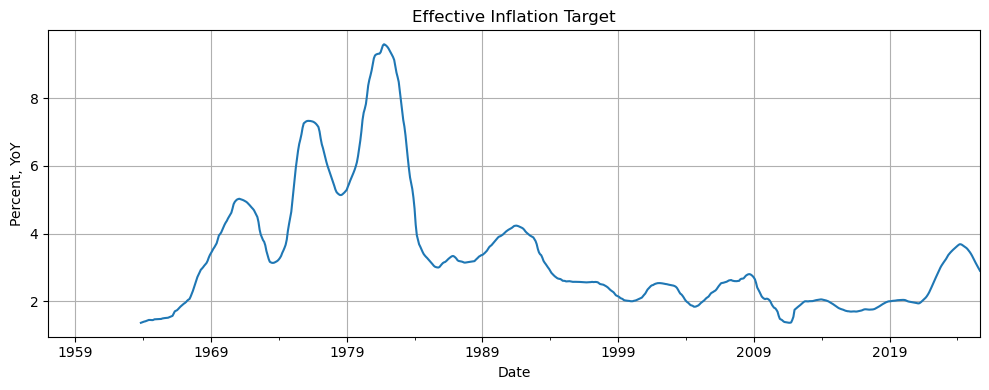

In [7]:
# --- visualization of effective inflation target --- 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
df['INFTFEFF_NSA'].plot()
plt.title("Effective Inflation Target")
plt.xlabel("Date")
plt.ylabel("Percent, YoY")
plt.grid(True)
plt.tight_layout()
plt.show()

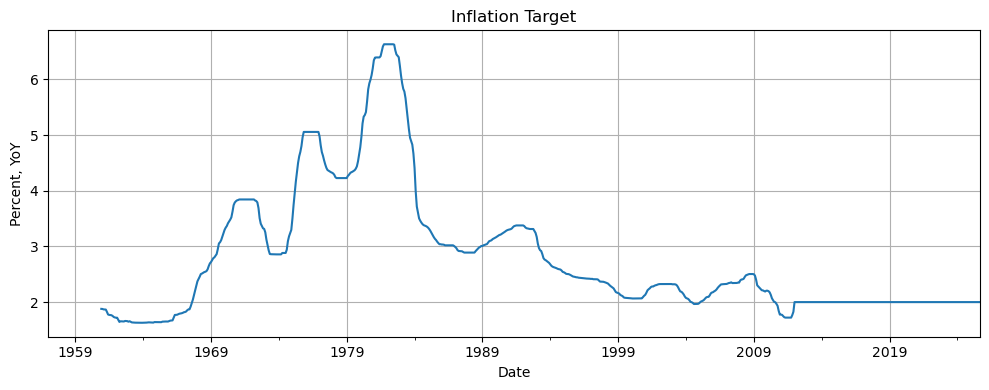

In [8]:
# --- visualization of inflation target ---
plt.figure(figsize=(10, 4))
df['inflation_target'].plot()
plt.title("Inflation Target")
plt.xlabel("Date")
plt.ylabel("Percent, YoY")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# --- creating main dataframe in JPMaQS QDF format ---

cid = "USA"

def to_qdf_monthly(df_monthly, col, xcat, cid):
    s = df_monthly[[col]].copy()
    s.index.name = "real_date"           # monthly real_date
    return (
        s.reset_index()
         .assign(cid=cid, xcat=xcat)
         .rename(columns={col: "value"})
         [["cid", "xcat", "real_date", "value"]]
    )


In [10]:
# --- create sample df to store all constructed factors ---

start = "1990-01-01"
end   = "2025-09-01"

# --- Empty master monthly container ---
sample_index = pd.date_range(start=start, end=end, freq="MS")
sample_df = pd.DataFrame(index=sample_index)

# --- Helper to add a factor from any source df ---
def add_factor_to_sample(source_df, col_name, new_col_name=None):
    """
    source_df : DataFrame with DateTimeIndex
    col_name  : column in source_df containing the factor
    new_col_name : name to use in sample_df (defaults to col_name)
    """
    global sample_df
    if new_col_name is None:
        new_col_name = col_name

    # ensure monthly and aligned to master index
    tmp = (
        source_df[[col_name]]
        .sort_index()
        .asfreq("MS")              # monthly
        .loc[start:end]            # clip to sample period
        .reindex(sample_df.index)  # align to master index
    )

    sample_df[new_col_name] = tmp[col_name]


In [11]:
#CPIC factor construction
#------------------------------------

# --- 3‑month change in core CPI YoY (%‑points) ---
df['CPIC_YOY_D3'] = df['CPIC_inf_yoy'] - df['CPIC_inf_yoy'].shift(3)

# --- adding constructed factor into sample df --- 
add_factor_to_sample(df, "CPIC_YOY_D3")

#check 
sample_df


CPIC_YOY_D3
1990-01-01     0.113778
1990-02-01     0.191547
1990-03-01     0.343625
1990-04-01     0.424453
1990-05-01     0.183954
...                 ...
2025-05-01    -0.376519
2025-06-01     0.099136
2025-07-01     0.267082
2025-08-01     0.345042
2025-09-01     0.117673

[429 rows x 1 columns]

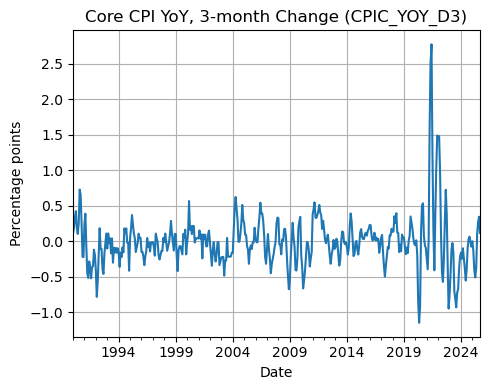

In [12]:
# --- visualizing change in core inflation over 3 months ---
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sample_df['CPIC_YOY_D3'].dropna().plot()
plt.title('Core CPI YoY, 3‑month Change (CPIC_YOY_D3)')
plt.xlabel('Date')
plt.ylabel('Percentage points')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
#XCPIC factor construction
#------------------------------------

# --- excess core CPI oya% --- 
df['XCPIC_YOY'] = df['CPIC_inf_yoy'] - df['INFTFEFF_NSA']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(df, "XCPIC_YOY")

#check 
sample_df

CPIC_YOY_D3 XCPIC_YOY
1990-01-01     0.113778   0.60902
1990-02-01     0.191547  0.711301
1990-03-01     0.343625  0.892387
1990-04-01     0.424453  0.933706
1990-05-01     0.183954  0.826436
...                 ...       ...
2025-05-01    -0.376519 -0.382873
2025-06-01     0.099136 -0.177384
2025-07-01     0.267082  0.022848
2025-08-01     0.345042  0.145177
2025-09-01     0.117673  0.119573

[429 rows x 2 columns]

In [14]:
#CPIH factor construction
#------------------------------------

# --- 3‑month change in headline CPI YoY (%‑points) ---
df['CPIH_YOY_D3'] = df['CPIH_inf_yoy'] - df['CPIH_inf_yoy'].shift(3)

# --- adding constructed factor into sample df --- 
add_factor_to_sample(df, "CPIH_YOY_D3")


In [15]:
#XCPIH factor construction
#------------------------------------

# --- excess headline CPI oya% --- 
df['XCPIH_YOY'] = df['CPIH_inf_yoy'] - df['INFTFEFF_NSA']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(df, "XCPIH_YOY")

#check 
sample_df

CPIC_YOY_D3 XCPIC_YOY  CPIH_YOY_D3 XCPIH_YOY
1990-01-01     0.113778   0.60902     0.610864  1.380163
1990-02-01     0.191547  0.711301     0.608129  1.403931
1990-03-01     0.343625  0.892387     0.597714  1.341634
1990-04-01     0.424453  0.933706    -0.486403  0.793992
1990-05-01     0.183954  0.826436    -0.897758  0.437355
...                 ...       ...          ...       ...
2025-05-01    -0.376519 -0.382873    -0.438336 -0.774088
2025-06-01     0.099136 -0.177384     0.267098  -0.41257
2025-07-01     0.267082  0.022848     0.398055 -0.293953
2025-08-01     0.345042  0.145177     0.563286 -0.027794
2025-09-01     0.117673  0.119573     0.350016   0.11673

[429 rows x 4 columns]

In [16]:
#XPPI factor construction
#------------------------------------

# --- Read file and prepare date index ---
ppi_df = pd.read_excel("/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Inflation/PPI, CPIE, CPIF.xlsx")
ppi_df['DATE'] = pd.to_datetime(ppi_df['observation_date'])
ppi_df = ppi_df.sort_values('DATE').set_index('DATE')

# --- Build composite PPI series: intermediate until 2016, final from 2016 ---
switch_date = pd.Timestamp("2016-01-01")
ppi_df['PPI_combo']= ppi_df['PPI_Intermediate']
ppi_df.loc[ppi_df.index >= switch_date, 'PPI_combo'] = ppi_df.loc[ppi_df.index >= switch_date, 'PPI_ Final']

# --- YOY % change of composite PPI ---
ppi_df['PPI_yoy']= ppi_df['PPI_combo'].pct_change(periods=12)*100.00

# --- Excess PPIH calculation ---
ppi_df['XPPI_YOY'] = ppi_df['PPI_yoy']- df['INFTFEFF_NSA']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ppi_df, "XPPI_YOY")


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [17]:
#CPIF factor construction 
#------------------------------------

ppi_df['CPIF_yoy']= ppi_df['CPIF'].pct_change(periods=12)*100.0

# --- 3‑month change in headline CPI YoY (%‑points) ---
ppi_df['CPIF_YOY_D3'] = ppi_df['CPIF_yoy'] - ppi_df['CPIF_yoy'].shift(3)

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ppi_df, "CPIF_YOY_D3")

In [18]:
#XCPIF factor construction 
#------------------------------------

# --- excess food inflation oya% ---
ppi_df['XCPIF_YOY'] = ppi_df['CPIF_yoy'] - df['INFTFEFF_NSA']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ppi_df, "XCPIF_YOY")

In [19]:
#CPIE factor construction 
#------------------------------------

ppi_df['CPIE_yoy']= ppi_df['CPIE'].pct_change(periods=12)*100.0

# --- 3‑month change in headline CPI YoY (%‑points) ---
ppi_df['CPIE_YOY_D3'] = ppi_df['CPIE_yoy'] - ppi_df['CPIE_yoy'].shift(3)

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ppi_df, "CPIE_YOY_D3")

In [20]:
#XCPIE factor construction 
#------------------------------------

# --- excess food inflation oya% ---
ppi_df['XCPIE_YOY'] = ppi_df['CPIE_yoy'] - df['INFTFEFF_NSA']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ppi_df, "XCPIE_YOY")

#check 
sample_df

CPIC_YOY_D3 XCPIC_YOY  CPIH_YOY_D3 XCPIH_YOY  XPPI_YOY  \
1990-01-01     0.113778   0.60902     0.610864  1.380163  0.164043   
1990-02-01     0.191547  0.711301     0.608129  1.403931  -0.61013   
1990-03-01     0.343625  0.892387     0.597714  1.341634 -1.474158   
1990-04-01     0.424453  0.933706    -0.486403  0.793992 -2.314775   
1990-05-01     0.183954  0.826436    -0.897758  0.437355 -2.691296   
...                 ...       ...          ...       ...       ...   
2025-05-01    -0.376519 -0.382873    -0.438336 -0.774088 -1.970175   
2025-06-01     0.099136 -0.177384     0.267098  -0.41257 -1.198235   
2025-07-01     0.267082  0.022848     0.398055 -0.293953 -1.118273   
2025-08-01     0.345042  0.145177     0.563286 -0.027794  -1.04861   
2025-09-01     0.117673  0.119573     0.350016   0.11673  0.377758   

            CPIF_YOY_D3 XCPIF_YOY  CPIE_YOY_D3 XCPIE_YOY  
1990-01-01     1.182024    2.6842     4.401315  5.705952  
1990-02-01     1.144658  2.845597     3.584078  4.290553  
1990-03-01     0.636652   2.27816     1.184154  2.422401  
1990-04-01    -0.924046  1.660387    -8.592133 -2.985947  
1990-05-01    -1.648644  1.128135    -8.868466 -4.646731  
...                 ...       ...          ...       ...  
2025-05-01     0.295298 -0.335793    -2.786044 -6.269889  
2025-06-01     0.004520  -0.19124     2.571431 -3.732803  
2025-07-01     0.107211   -0.2315     2.189072 -4.314183  
2025-08-01     0.303521  0.150737     3.508828 -2.578053  
2025-09-01     0.156963  0.145007     3.532215 -0.021305  

[429 rows x 9 columns]

In [21]:
# --- build list of QDF DataFrames from sample_df ---
qdf_list = []
for col in sample_df.columns:
    qdf_list.append(
        to_qdf_monthly(sample_df, col=col, xcat=col, cid=cid)
    )

# Combine this block
qdf_inflation_block = pd.concat(qdf_list, ignore_index=True)

qdf_main = qdf_inflation_block.copy()

qdf_main
 

cid         xcat  real_date     value
0     USA  CPIC_YOY_D3 1990-01-01  0.113778
1     USA  CPIC_YOY_D3 1990-02-01  0.191547
2     USA  CPIC_YOY_D3 1990-03-01  0.343625
3     USA  CPIC_YOY_D3 1990-04-01  0.424453
4     USA  CPIC_YOY_D3 1990-05-01  0.183954
...   ...          ...        ...       ...
3856  USA    XCPIE_YOY 2025-05-01 -6.269889
3857  USA    XCPIE_YOY 2025-06-01 -3.732803
3858  USA    XCPIE_YOY 2025-07-01 -4.314183
3859  USA    XCPIE_YOY 2025-08-01 -2.578053
3860  USA    XCPIE_YOY 2025-09-01 -0.021305

[3861 rows x 4 columns]

In [22]:
#Unemployment rate factor construction 
#------------------------------------

# --- Read file and prepare date index ---
emp_df = pd.read_excel("/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Employment/UNRATE.xlsx", sheet_name = "Monthly")
emp_df['DATE'] = pd.to_datetime(emp_df['observation_date'])
emp_df = emp_df.sort_values('DATE').set_index('DATE')

# --- 3mma of monthly unemployment rate ---
emp_df['unemp_3mma'] = emp_df['UNRATE'].rolling(window =3, min_periods=3).mean()

# ---YoY difference of 3mma monthly unemployment rate ---
emp_df['UNEMP_3MMA_DYOY'] = emp_df['unemp_3mma'] - emp_df['unemp_3mma'].shift(12)

# --- adding constructed factor into sample df --- 
add_factor_to_sample(emp_df, 'UNEMP_3MMA_DYOY')


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [23]:
#Unemployemnet rate 3MMA v 5MMA factor construction 
#------------------------------------

# --- 5mma of monthly unemployment rate ---
emp_df['unemp_5yma'] = emp_df['UNRATE'].rolling(window=60, min_periods=60).mean()

# --- unemp rate 3mma v 5yma ---
emp_df['UNEMP_3MMAv5YMA'] = emp_df['unemp_3mma']- emp_df['unemp_5yma']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(emp_df, "UNEMP_3MMAv5YMA")


In [24]:
#Exports factor construction 
#------------------------------------

# --- Read file and prepare date index ---
exp_df = pd.read_excel("/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Exports of Goods.xlsx")
exp_df['DATE'] = pd.to_datetime(exp_df['observation_date'])
exp_df = exp_df.sort_values('DATE').set_index('DATE')

# --- yoy % change exports  ---
exp_df['exp_yoy'] = exp_df['BOPGEXP'].pct_change(periods=12)*100.0

# ---3mma of Yoy % change of exports ---
exp_df['EXP_YOY_3MMA'] = exp_df['exp_yoy'].rolling(window=3, min_periods=1).mean()

# --- adding constructed factor into sample df --- 
add_factor_to_sample(exp_df, "EXP_YOY_3MMA")

#check 
sample_df

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


CPIC_YOY_D3 XCPIC_YOY  CPIH_YOY_D3 XCPIH_YOY  XPPI_YOY  \
1990-01-01     0.113778   0.60902     0.610864  1.380163  0.164043   
1990-02-01     0.191547  0.711301     0.608129  1.403931  -0.61013   
1990-03-01     0.343625  0.892387     0.597714  1.341634 -1.474158   
1990-04-01     0.424453  0.933706    -0.486403  0.793992 -2.314775   
1990-05-01     0.183954  0.826436    -0.897758  0.437355 -2.691296   
...                 ...       ...          ...       ...       ...   
2025-05-01    -0.376519 -0.382873    -0.438336 -0.774088 -1.970175   
2025-06-01     0.099136 -0.177384     0.267098  -0.41257 -1.198235   
2025-07-01     0.267082  0.022848     0.398055 -0.293953 -1.118273   
2025-08-01     0.345042  0.145177     0.563286 -0.027794  -1.04861   
2025-09-01     0.117673  0.119573     0.350016   0.11673  0.377758   

            CPIF_YOY_D3 XCPIF_YOY  CPIE_YOY_D3 XCPIE_YOY  UNEMP_3MMA_DYOY  \
1990-01-01     1.182024    2.6842     4.401315  5.705952         0.066667   
1990-02-01     1.144658  2.845597     3.584078  4.290553         0.066667   
1990-03-01     0.636652   2.27816     1.184154  2.422401         0.100000   
1990-04-01    -0.924046  1.660387    -8.592133 -2.985947         0.166667   
1990-05-01    -1.648644  1.128135    -8.868466 -4.646731         0.200000   
...                 ...       ...          ...       ...              ...   
2025-05-01     0.295298 -0.335793    -2.786044 -6.269889         0.266667   
2025-06-01     0.004520  -0.19124     2.571431 -3.732803         0.166667   
2025-07-01     0.107211   -0.2315     2.189072 -4.314183         0.066667   
2025-08-01     0.303521  0.150737     3.508828 -2.578053         0.033333   
2025-09-01     0.156963  0.145007     3.532215 -0.021305         0.133333   

            UNEMP_3MMAv5YMA  EXP_YOY_3MMA  
1990-01-01        -0.791667           NaN  
1990-02-01        -0.793333           NaN  
1990-03-01        -0.826667           NaN  
1990-04-01        -0.795000           NaN  
1990-05-01        -0.731667           NaN  
...                     ...           ...  
2025-05-01        -0.440000      7.824411  
2025-06-01        -0.358333      6.486717  
2025-07-01        -0.258333      4.168719  
2025-08-01        -0.156667      2.425396  
2025-09-01         0.000000      3.597446  

[429 rows x 12 columns]

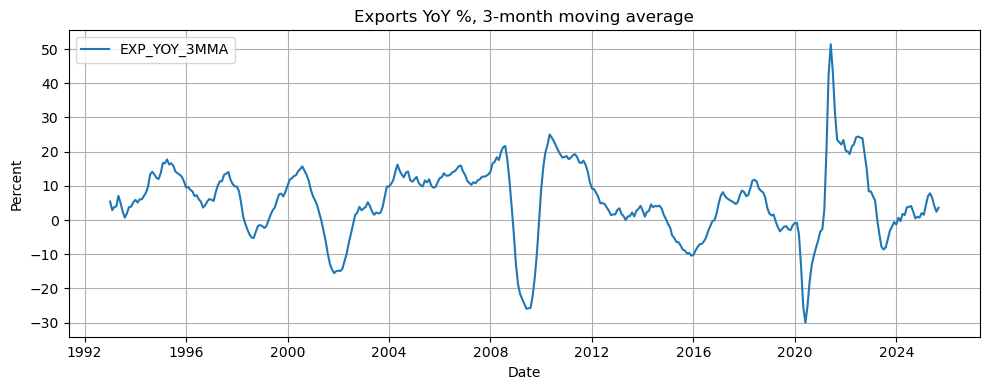

In [25]:
# --- visual check: exports ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(exp_df.index, exp_df['EXP_YOY_3MMA'],
         linewidth=1.5,   # line only, no markers
         label='EXP_YOY_3MMA')
plt.title('Exports YoY %, 3‑month moving average')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


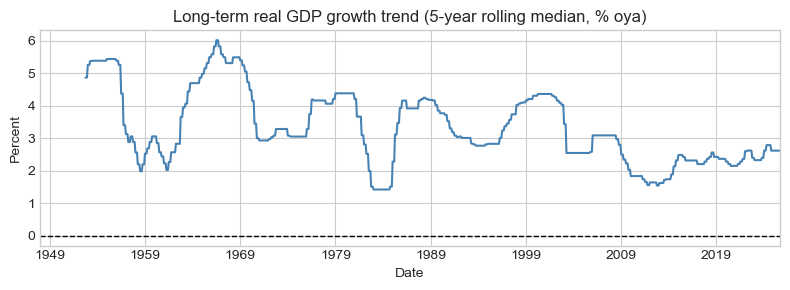

In [26]:
#Calculation of GDP growth trend 
#------------------------------------

# --- importing data ---
gdp_df = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/GDP/RGDPC1_PC1.xlsx')
gdp_df['DATE'] = pd.to_datetime(gdp_df['observation_date'])
gdp_df = gdp_df.sort_values('DATE').set_index('DATE')

# --- calculation of 5 year median ---
gdp_df['RGDP_TREND']= gdp_df['GDPC1_PC1'].rolling(window=20, min_periods =20).median()

# --- convert into monthly data; carry last quarterly value forward ---
gdp_monthly = (gdp_df.resample('MS').ffill())

# --- visualizing ---
plt.style.use("seaborn-v0_8-whitegrid")  

plt.figure(figsize=(8, 3))
gdp_monthly['RGDP_TREND'].plot(color='steelblue')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title('Long-term real GDP growth trend (5-year rolling median, % oya)')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.tight_layout()
plt.show()

In [27]:
gdp_monthly.loc['1990':'2025-09-30']

observation_date  GDPC1_PC1  RGDP_TREND
DATE                                              
1990-01-01       1990-01-01    2.82101    3.773625
1990-02-01       1990-01-01    2.82101    3.773625
1990-03-01       1990-01-01    2.82101    3.773625
1990-04-01       1990-04-01    2.41270    3.773625
1990-05-01       1990-04-01    2.41270    3.773625
...                     ...        ...         ...
2025-05-01       2025-04-01    2.08047    2.622590
2025-06-01       2025-04-01    2.08047    2.622590
2025-07-01       2025-04-01    2.08047    2.622590
2025-08-01       2025-04-01    2.08047    2.622590
2025-09-01       2025-04-01    2.08047    2.622590

[429 rows x 3 columns]

In [28]:
#exports yoy 3MMA v GDP growth trend factor construction 
#------------------------------------

# --- excess exports over 5 years median ---
exp_df['XEXP_YOY'] = exp_df['EXP_YOY_3MMA'] - gdp_monthly['RGDP_TREND'] - df['INFTFEFF_NSA']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(exp_df, "XEXP_YOY")


In [29]:
# --- add list of factors from sample_df to QDF main ---

qdf_list = [
    to_qdf_monthly(sample_df, col=c, xcat=c, cid=cid)
    for c in sample_df.columns
]
qdf_main = pd.concat(qdf_list, ignore_index=True)

qdf_main

cid         xcat  real_date     value
0     USA  CPIC_YOY_D3 1990-01-01  0.113778
1     USA  CPIC_YOY_D3 1990-02-01  0.191547
2     USA  CPIC_YOY_D3 1990-03-01  0.343625
3     USA  CPIC_YOY_D3 1990-04-01  0.424453
4     USA  CPIC_YOY_D3 1990-05-01  0.183954
...   ...          ...        ...       ...
5572  USA     XEXP_YOY 2025-05-01  2.051799
5573  USA     XEXP_YOY 2025-06-01  0.778874
5574  USA     XEXP_YOY 2025-07-01 -1.479626
5575  USA     XEXP_YOY 2025-08-01 -3.164208
5576  USA     XEXP_YOY 2025-09-01 -1.931114

[5577 rows x 4 columns]

In [30]:
#Excess industrial production calculation
#------------------------------------

# --- Read file and prepare date index ---
ip_df = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Industrial production SA.xlsx')
ip_df['DATE'] = pd.to_datetime(ip_df['observation_date'])
ip_df = ip_df.sort_values('DATE').set_index('DATE')
ip_df = ip_df.sort_index().asfreq('MS')

# --- YoY % change in IP ---
ip_df['IP_YOY'] = ip_df['INDPRO'].pct_change(periods= 12) * 100.0

# --- 3‑month moving average of YoY IP ---
ip_df['IP_YOY_3MMA'] = ip_df['IP_YOY'].rolling(window=3, min_periods=3).mean()

# --- excess industrial production ---
ip_df['XIP_YOY'] = ip_df['IP_YOY'] - gdp_monthly['RGDP_TREND']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ip_df, "XIP_YOY")


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [31]:
#Real private consumption 
#------------------------------------

# --- Read file and prepare date index ---
pce_df = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/PCE/PCE combined.xlsx')
pce_df['DATE'] = pd.to_datetime(pce_df['observation_date'])
pce_df = pce_df.sort_values('DATE').set_index('DATE')
pce_df = pce_df.sort_index().asfreq('MS')

# --- converting nominal series into real series --- 
mask_pre2007 = (pce_df.index >= '1959-01-01') & (pce_df.index <= '2006-12-01')
pce_df.loc[mask_pre2007, 'Real_PCE_deflated'] = (
    pce_df.loc[mask_pre2007, 'Nominal PCE'] * 100.0 / pce_df.loc[mask_pre2007, 'PCE index ']
)
mask_2007on = pce_df.index >= '2007-01-01'

# --- Use official real PCE from 2007 onward, build continuous real series ---
pce_df['Real_PCE_final'] = np.nan
pce_df.loc[mask_pre2007, 'Real_PCE_final'] = pce_df.loc[mask_pre2007, 'Real_PCE_deflated']
pce_df.loc[mask_2007on,  'Real_PCE_final'] = pce_df.loc[mask_2007on,  'Real PCE']

# --- % oya calculation of PCE ---
pce_df['RPCE_yoy'] = pce_df['Real_PCE_final'].pct_change(12) * 100

# --- Moving average of YoY (3‑month) ---
pce_df['RPCE_yoy_3mma'] = pce_df['RPCE_yoy'].rolling(window = 3, min_periods = 3).mean()

# --- excess consumption factor: construction ---
pce_df['XRPCE_YOY_3MMA'] = pce_df['RPCE_yoy_3mma']- gdp_monthly['RGDP_TREND']

# --- adding constructed factor into sample df --- 
add_factor_to_sample(pce_df, "XRPCE_YOY_3MMA")


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


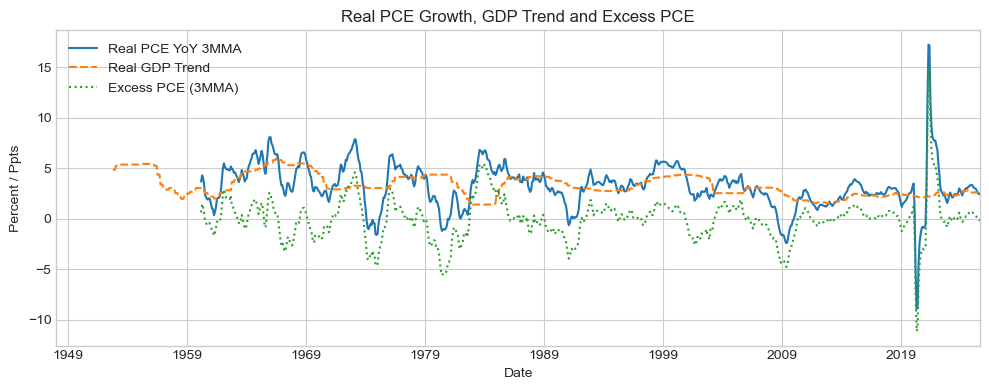

In [32]:
#visualization 
plt.figure(figsize=(10, 4))

pce_df['RPCE_yoy_3mma'].plot(ax=plt.gca(), label='Real PCE YoY 3MMA')
gdp_monthly['RGDP_TREND'].plot(ax=plt.gca(), label='Real GDP Trend', linestyle='--')
pce_df['XRPCE_YOY_3MMA'].plot(ax=plt.gca(), label='Excess PCE (3MMA)', linestyle=':')

plt.title('Real PCE Growth, GDP Trend and Excess PCE')
plt.xlabel('Date')
plt.ylabel('Percent / Ppts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
#Excess private credit
#------------------------------------

# --- Read file and prepare date index ---
loan_df = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/LOANS.xlsx')
loan_df['DATE'] = pd.to_datetime(loan_df['observation_date'])
loan_df = loan_df.sort_values('DATE').set_index('DATE')
loan_df = loan_df.sort_index().asfreq('MS')

def jump_adjust(s: pd.Series, window: int = 12, jump_sigma: float = 2.0) -> pd.Series:
    """
    Jump-adjust a seasonally adjusted series:
    - Jumps: |x_t - rolling_mean_t| > jump_sigma * rolling_std_t
    - Spikes: two consecutive jumps with opposite signs -> both replaced by their mean
    - Breaks: remaining single jumps -> replaced by rolling mean
    """
    s = s.astype(float).copy()

    # 1) Rolling mean and std over 1 year
    roll_mean = s.rolling(window=window, min_periods=window).mean()
    roll_std  = s.rolling(window=window, min_periods=window).std()

    # 2) Identify jumps
    diff  = s - roll_mean
    jumps = diff.abs() > (jump_sigma * roll_std)

    # 3) Identify spikes: jump followed by jump in opposite direction
    sign_diff   = np.sign(diff)
    spikes_first = jumps & jumps.shift(-1) & (sign_diff != sign_diff.shift(-1))

    # Work on a copy
    s_adj = s.copy()

    # 4) Replace spike pairs by their mean
    spike_first_idx = spikes_first[spikes_first].index
    for t1 in spike_first_idx:
        # t2 is the next month in the index
        try:
            t2 = s_adj.index[s_adj.index.get_loc(t1) + 1]
        except IndexError:
            continue
        pair_mean = 0.5 * (s_adj.loc[t1] + s_adj.loc[t2])
        s_adj.loc[t1] = pair_mean
        s_adj.loc[t2] = pair_mean

    # 5) Recompute jumps after spike correction
    roll_mean2 = s_adj.rolling(window=window, min_periods=window).mean()
    roll_std2  = s_adj.rolling(window=window, min_periods=window).std()
    diff2  = s_adj - roll_mean2
    jumps2 = diff2.abs() > (jump_sigma * roll_std2)

    # 6) Breaks: remaining jumps that are not part of spikes
    spike_mask = spikes_first | spikes_first.shift(1, fill_value=False)
    breaks = jumps2 & ~spike_mask

    # 7) Replace breaks by 1‑year rolling mean
    s_adj[breaks] = roll_mean2[breaks]

    return s_adj

# --- Apply to loans series ---
loan_df['LOANS_JA'] = jump_adjust(loan_df['LOANS'])

# --- YoY % change of jump-adjusted loans ---
loan_df['LOANS_SAJA_yoy']= loan_df['LOANS_JA'].pct_change(12)*100

# --- Construct the factor ---
loan_df['XCREDIT'] = loan_df['LOANS_SAJA_yoy'] - (gdp_monthly['RGDP_TREND']+ df['INFTFEFF_NSA'])

# --- adding constructed factor into sample df --- 
add_factor_to_sample(loan_df, "XCREDIT")

#check 
sample_df

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


CPIC_YOY_D3 XCPIC_YOY  CPIH_YOY_D3 XCPIH_YOY  XPPI_YOY  \
1990-01-01     0.113778   0.60902     0.610864  1.380163  0.164043   
1990-02-01     0.191547  0.711301     0.608129  1.403931  -0.61013   
1990-03-01     0.343625  0.892387     0.597714  1.341634 -1.474158   
1990-04-01     0.424453  0.933706    -0.486403  0.793992 -2.314775   
1990-05-01     0.183954  0.826436    -0.897758  0.437355 -2.691296   
...                 ...       ...          ...       ...       ...   
2025-05-01    -0.376519 -0.382873    -0.438336 -0.774088 -1.970175   
2025-06-01     0.099136 -0.177384     0.267098  -0.41257 -1.198235   
2025-07-01     0.267082  0.022848     0.398055 -0.293953 -1.118273   
2025-08-01     0.345042  0.145177     0.563286 -0.027794  -1.04861   
2025-09-01     0.117673  0.119573     0.350016   0.11673  0.377758   

            CPIF_YOY_D3 XCPIF_YOY  CPIE_YOY_D3 XCPIE_YOY  UNEMP_3MMA_DYOY  \
1990-01-01     1.182024    2.6842     4.401315  5.705952         0.066667   
1990-02-01     1.144658  2.845597     3.584078  4.290553         0.066667   
1990-03-01     0.636652   2.27816     1.184154  2.422401         0.100000   
1990-04-01    -0.924046  1.660387    -8.592133 -2.985947         0.166667   
1990-05-01    -1.648644  1.128135    -8.868466 -4.646731         0.200000   
...                 ...       ...          ...       ...              ...   
2025-05-01     0.295298 -0.335793    -2.786044 -6.269889         0.266667   
2025-06-01     0.004520  -0.19124     2.571431 -3.732803         0.166667   
2025-07-01     0.107211   -0.2315     2.189072 -4.314183         0.066667   
2025-08-01     0.303521  0.150737     3.508828 -2.578053         0.033333   
2025-09-01     0.156963  0.145007     3.532215 -0.021305         0.133333   

            UNEMP_3MMAv5YMA  EXP_YOY_3MMA  XEXP_YOY   XIP_YOY  XRPCE_YOY_3MMA  \
1990-01-01        -0.791667           NaN       NaN -4.622359       -1.275096   
1990-02-01        -0.793333           NaN       NaN -3.277190       -1.171155   
1990-03-01        -0.826667           NaN       NaN -3.028496       -1.026733   
1990-04-01        -0.795000           NaN       NaN -3.277388       -1.128973   
1990-05-01        -0.731667           NaN       NaN -2.395384       -1.113737   
...                     ...           ...       ...       ...             ...   
2025-05-01        -0.440000      7.824411  2.051799 -2.509268        0.331386   
2025-06-01        -0.358333      6.486717  0.778874 -2.093322        0.102260   
2025-07-01        -0.258333      4.168719 -1.479626 -1.006897       -0.111543   
2025-08-01        -0.156667      2.425396 -3.164208 -1.727348       -0.081392   
2025-09-01         0.000000      3.597446 -1.931114 -0.999981       -0.202559   

             XCREDIT  
1990-01-01  0.429444  
1990-02-01 -0.316986  
1990-03-01 -0.259135  
1990-04-01 -0.714631  
1990-05-01 -1.152355  
...              ...  
2025-05-01 -2.029042  
2025-06-01 -1.746011  
2025-07-01 -1.340949  
2025-08-01 -1.035903  
2025-09-01 -0.762661  

[429 rows x 16 columns]

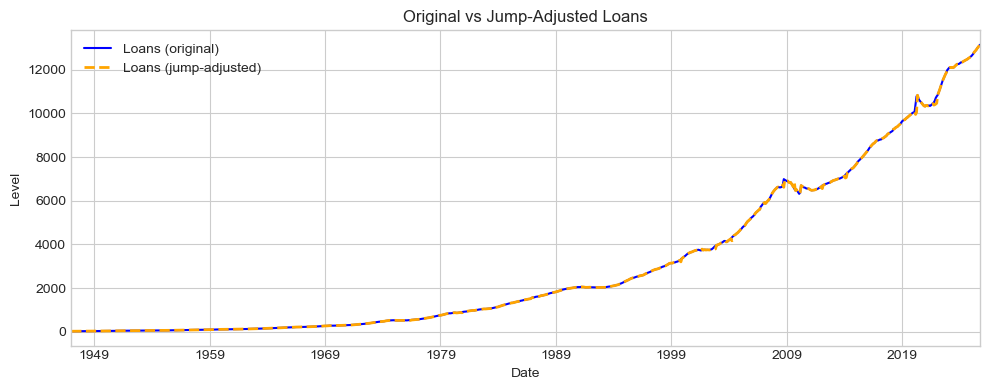

In [34]:
plt.figure(figsize=(10, 4))

loan_df['LOANS'].plot(
    ax=plt.gca(), label='Loans (original)',
    color='blue', linewidth=1.5
)
loan_df['LOANS_JA'].plot(
    ax=plt.gca(), label='Loans (jump-adjusted)',
    color='orange', linestyle='--', linewidth=2
)

plt.title('Original vs Jump-Adjusted Loans')
plt.xlabel('Date')
plt.ylabel('Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

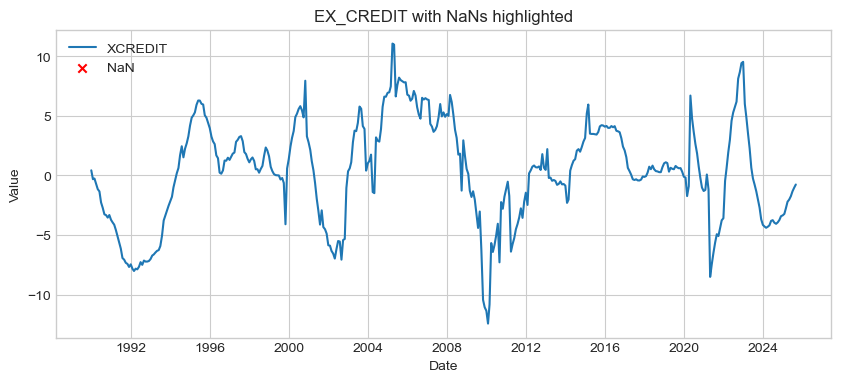

In [35]:
# --- visualization and check for NaNs ---
na_mask = sample_df['XCREDIT'].isna()

plt.figure(figsize=(10,4))
plt.plot(sample_df.index, sample_df['XCREDIT'], label='XCREDIT')
plt.scatter(sample_df.index[na_mask],
            [sample_df['XCREDIT'].mean()]*na_mask.sum(),
            color='red', marker='x', label='NaN')
plt.title('EX_CREDIT with NaNs highlighted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
#Consumer confidence score
#------------------------------------

# --- Read file and prepare date index ---
ccs_df = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/University of Michigan Consumer confidence scores.xlsx')
ccs_df['DATE'] = pd.to_datetime(ccs_df['observation_date'])
ccs_df = ccs_df.sort_values('DATE').set_index('DATE')
ccs_df = ccs_df.sort_index().asfreq('MS')

# --- seasonal adjustment of raw index using STL decomposition ---
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

cutoff = '1966-01-01'  #since the data is disjoint before this time 
s = ccs_df.loc[cutoff:, 'UMCSENT'].dropna()  
stl = STL(s, period=12, robust=True)
res = stl.fit()

# --- Seasonally adjusted series = original - seasonal component ---
ccs_df['CCS_SA'] = s - res.seasonal

# --- standardize --- 
mean_cc = ccs_df['CCS_SA'].mean()
std_cc  = ccs_df['CCS_SA'].std()
ccs_df['CCS_SA_Z'] = (ccs_df['CCS_SA'] - mean_cc) / std_cc

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ccs_df, "CCS_SA_Z")



/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


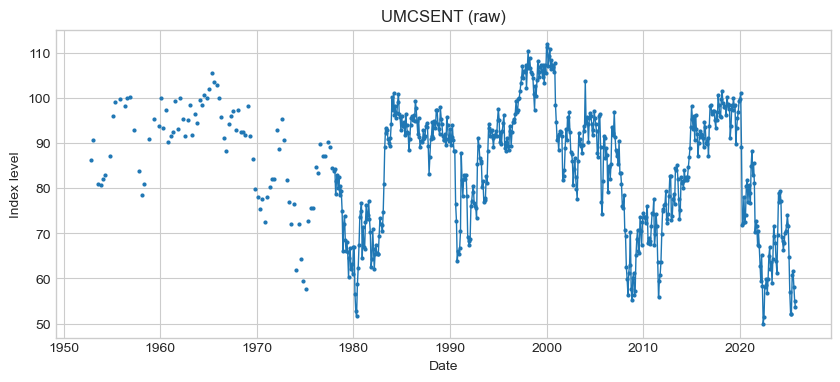

In [37]:
plt.figure(figsize=(10,4))
plt.plot(ccs_df.index, ccs_df['UMCSENT'], marker='o', markersize=2, linewidth=1)
plt.title('UMCSENT (raw)')
plt.xlabel('Date')
plt.ylabel('Index level')
plt.grid(True)
plt.show()

In [38]:
#Consumer confidence score difference of 3mo v 3mo
#------------------------------------

# --- 3‑month moving average of the z‑score ---
ccs_df['CCS_SA_Z_MA3'] = ccs_df['CCS_SA_Z'].rolling(3).mean()

# --- 3‑over‑3 difference: last 3 months minus previous 3 months ---
ccs_df['CCS_SA_Z_D3M'] = (ccs_df['CCS_SA_Z_MA3']- ccs_df['CCS_SA_Z_MA3'].shift(3))

# --- adding constructed factor into sample df --- 
add_factor_to_sample(ccs_df, "CCS_SA_Z_D3M")


In [39]:
ccs_df

observation_date  UMCSENT     CCS_SA  CCS_SA_Z  CCS_SA_Z_MA3  \
DATE                                                                      
1952-11-01       1952-11-01     86.2        NaN       NaN           NaN   
1952-12-01       1952-12-01      NaN        NaN       NaN           NaN   
1953-01-01       1953-01-01      NaN        NaN       NaN           NaN   
1953-02-01       1953-02-01     90.7        NaN       NaN           NaN   
1953-03-01       1953-03-01      NaN        NaN       NaN           NaN   
...                     ...      ...        ...       ...           ...   
2025-06-01       2025-06-01     60.7  58.498291 -1.926282     -1.873998   
2025-07-01       2025-07-01     61.7  59.510801 -1.850431     -1.891492   
2025-08-01       2025-08-01     58.2  55.951654 -2.117061     -1.964591   
2025-09-01       2025-09-01     55.1  54.187536 -2.249219     -2.072237   
2025-10-01       2025-10-01     53.6  54.294803 -2.241183     -2.202488   

            CCS_SA_Z_D3M  
DATE                      
1952-11-01           NaN  
1952-12-01           NaN  
1953-01-01           NaN  
1953-02-01           NaN  
1953-03-01           NaN  
...                  ...  
2025-06-01     -0.144962  
2025-07-01     -0.113050  
2025-08-01     -0.154802  
2025-09-01     -0.198239  
2025-10-01     -0.310996  

[876 rows x 6 columns]

In [40]:
#Manufacturing confidence score
#------------------------------------

# --- Read file and prepare DATE as month-begin (to match sample_df) ---
mcs_df = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/ISM Manufacturing PMI SA.xlsx')

mcs_df["observation_date"] = pd.to_datetime(mcs_df["observation_date"])

# --- Convert month-end observation_date to month-begin and make it the index ---
mcs_df["DATE"] = mcs_df["observation_date"] - pd.offsets.MonthBegin(1)
mcs_df = mcs_df.set_index("DATE") 

# --- standardize --- 
mean_mc = mcs_df['MBCSCORE_SA'].mean()
std_mc  = mcs_df['MBCSCORE_SA'].std()
mcs_df['MBCSCORE_SA_Z'] = (mcs_df['MBCSCORE_SA'] - mean_mc) / std_mc

# --- adding constructed factor into sample df --- 
add_factor_to_sample(mcs_df, "MBCSCORE_SA_Z")

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [41]:
#Manufacturing confidence score difference of prev 3mo over 3mo
#------------------------------------

# --- 3‑month moving average of the z‑score ---
mcs_df["MBCSCORE_SA_Z_MA3"] = mcs_df["MBCSCORE_SA_Z"].rolling(3).mean()

# --- 3‑over‑3 difference ---
mcs_df["MBCSCORE_SA_Z_D3M"] = (
    mcs_df["MBCSCORE_SA_Z_MA3"] - mcs_df["MBCSCORE_SA_Z_MA3"].shift(3))

# --- adding constructed factor into sample df --- 
add_factor_to_sample(mcs_df, "MBCSCORE_SA_Z_D3M")

In [42]:
#check - mcs_df
print(len(mcs_df))                        
print(mcs_df["MBCSCORE_SA_Z_D3M"].isna().sum())   # small number (early months only)


431
5


In [43]:
#Refined vs Crude oil returns 
#------------------------------------

# --- Read file ---
oil_df = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/WTI and HO futures.xlsx')

# --- Clean up Excel column names ---
oil_df.columns = ['date_cl1', 'CL1', 'date_ho', 'HO1']

# --- Convert both date columns to datetime ---
oil_df['date_cl1'] = pd.to_datetime(oil_df['date_cl1'], errors='coerce')
oil_df['date_ho']  = pd.to_datetime(oil_df['date_ho'], errors='coerce')

# --- Create separate price series for each commodity ---
cl1_df = oil_df[['date_cl1', 'CL1']].dropna(subset=['date_cl1']).set_index('date_cl1').sort_index()
ho1_df = oil_df[['date_ho', 'HO1']].dropna(subset=['date_ho']).set_index('date_ho').sort_index()

# --- FIXED: True union of dates (no duplicates) ---
all_dates = cl1_df.index.union(ho1_df.index)  

oil_df = pd.DataFrame(index=all_dates)
oil_df['CL1'] = cl1_df.reindex(all_dates).ffill()
oil_df['HO1'] = ho1_df.reindex(all_dates).ffill()
oil_df = oil_df.dropna()

print(f"oil_df final shape: {oil_df.shape}")
print(f"Date range: {oil_df.index.min()} to {oil_df.index.max()}")
print(f"Any duplicate dates? {oil_df.index.duplicated().any()}")  # Should be False


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


oil_df final shape: (9050, 2)
Date range: 1990-01-02 00:00:00 to 2025-12-31 00:00:00
Any duplicate dates? False


In [44]:
oil_df

CL1     HO1
1990-01-02  32.38   24.79
1990-01-03  33.50   25.05
1990-01-04  33.12   23.44
1990-01-05  32.65   21.73
1990-01-08  30.58   20.61
...           ...     ...
2025-12-24  58.35  215.76
2025-12-26  56.74  210.70
2025-12-29  58.08  212.75
2025-12-30  57.95  215.05
2025-12-31  57.42  212.06

[9050 rows x 2 columns]

In [45]:
oil_df['HO1'].isna().sum()

0

In [46]:
#Refined vs Crude oil-returns 
#------------------------------------

# Compute COXR_VT10vWTI_21DMA (as before)
import numpy as np

rets = oil_df.pct_change()
rets.columns = ["CL1_RET", "HO1_RET"]

target_vol = 0.10; lookback = 60
daily_vol = rets.rolling(lookback).std()
ann_vol = daily_vol * np.sqrt(252)
pos_scale = target_vol / ann_vol.clip(upper=5.0, lower=0.1)
coxr_vt10 = rets * pos_scale
coxr_vt10.columns = ["CL1_COXR_VT10", "HO1_COXR_VT10"]

coxr_spread = coxr_vt10["HO1_COXR_VT10"] - coxr_vt10["CL1_COXR_VT10"]
COXR_VT10vWTI_21DMA = coxr_spread.rolling(21, min_periods=21).mean()


In [47]:
print(COXR_VT10vWTI_21DMA.loc["2020-07-01":"2020-07-31"])

2020-07-01    0.000463
2020-07-02    0.000744
2020-07-06    0.000749
2020-07-07    0.000434
2020-07-08    0.000489
2020-07-09    0.000327
2020-07-10    0.000320
2020-07-13    0.000554
2020-07-14    0.000468
2020-07-15    0.000394
2020-07-16    0.000154
2020-07-17    0.000110
2020-07-20    0.000123
2020-07-21    0.000236
2020-07-22    0.000165
2020-07-23    0.000231
2020-07-24    0.000402
2020-07-27    0.000327
2020-07-28    0.000435
2020-07-29    0.000352
2020-07-30    0.000282
2020-07-31    0.000185
dtype: float64


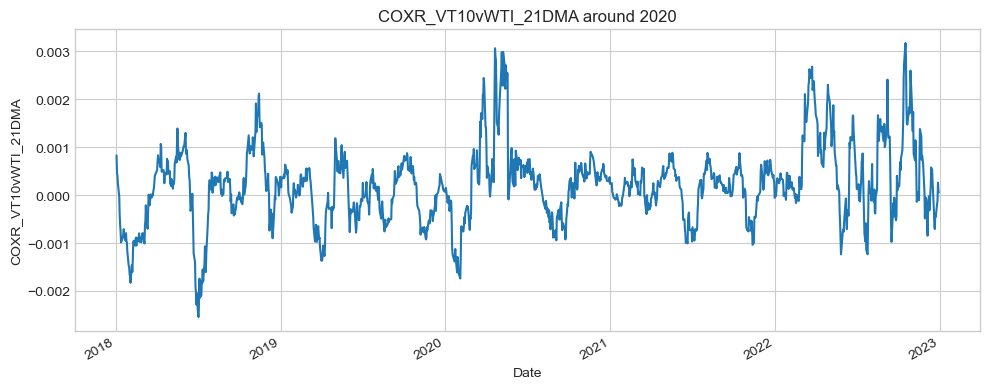

In [48]:
# --- examining missing data ---
plt.figure(figsize=(10, 4))
COXR_VT10vWTI_21DMA.loc["2018-01-01":"2022-12-31"].plot()
plt.title("COXR_VT10vWTI_21DMA around 2020")
plt.xlabel("Date")
plt.ylabel("COXR_VT10vWTI_21DMA")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# --- adding constructed factor to sample df ---
# 1) Daily factor to DataFrame
factor_daily = pd.DataFrame({"COXR_VT10vWTI_21DMA": COXR_VT10vWTI_21DMA})

# 2) Resample to month‑end, using 'ME' (new alias for month-end)
factor_monthly = (
    factor_daily
    .resample("ME")      # month-end frequency
    .last()              # last non-NaN in the month
)

# 3) Convert month-end index to month-begin datetime index
#    Step 1: convert to monthly PeriodIndex ('M')
#    Step 2: to_timestamp() gives month-begin by default
factor_monthly.index = factor_monthly.index.to_period("M").to_timestamp()
factor_monthly.index.name = "DATE"

# 4) Add to sample_df (helper uses month-begin index)
add_factor_to_sample(factor_monthly, "COXR_VT10vWTI_21DMA")


In [50]:
sample_df

CPIC_YOY_D3 XCPIC_YOY  CPIH_YOY_D3 XCPIH_YOY  XPPI_YOY  \
1990-01-01     0.113778   0.60902     0.610864  1.380163  0.164043   
1990-02-01     0.191547  0.711301     0.608129  1.403931  -0.61013   
1990-03-01     0.343625  0.892387     0.597714  1.341634 -1.474158   
1990-04-01     0.424453  0.933706    -0.486403  0.793992 -2.314775   
1990-05-01     0.183954  0.826436    -0.897758  0.437355 -2.691296   
...                 ...       ...          ...       ...       ...   
2025-05-01    -0.376519 -0.382873    -0.438336 -0.774088 -1.970175   
2025-06-01     0.099136 -0.177384     0.267098  -0.41257 -1.198235   
2025-07-01     0.267082  0.022848     0.398055 -0.293953 -1.118273   
2025-08-01     0.345042  0.145177     0.563286 -0.027794  -1.04861   
2025-09-01     0.117673  0.119573     0.350016   0.11673  0.377758   

            CPIF_YOY_D3 XCPIF_YOY  CPIE_YOY_D3 XCPIE_YOY  UNEMP_3MMA_DYOY  \
1990-01-01     1.182024    2.6842     4.401315  5.705952         0.066667   
1990-02-01     1.144658  2.845597     3.584078  4.290553         0.066667   
1990-03-01     0.636652   2.27816     1.184154  2.422401         0.100000   
1990-04-01    -0.924046  1.660387    -8.592133 -2.985947         0.166667   
1990-05-01    -1.648644  1.128135    -8.868466 -4.646731         0.200000   
...                 ...       ...          ...       ...              ...   
2025-05-01     0.295298 -0.335793    -2.786044 -6.269889         0.266667   
2025-06-01     0.004520  -0.19124     2.571431 -3.732803         0.166667   
2025-07-01     0.107211   -0.2315     2.189072 -4.314183         0.066667   
2025-08-01     0.303521  0.150737     3.508828 -2.578053         0.033333   
2025-09-01     0.156963  0.145007     3.532215 -0.021305         0.133333   

            ...  EXP_YOY_3MMA  XEXP_YOY   XIP_YOY  XRPCE_YOY_3MMA   XCREDIT  \
1990-01-01  ...           NaN       NaN -4.622359       -1.275096  0.429444   
1990-02-01  ...           NaN       NaN -3.277190       -1.171155 -0.316986   
1990-03-01  ...           NaN       NaN -3.028496       -1.026733 -0.259135   
1990-04-01  ...           NaN       NaN -3.277388       -1.128973 -0.714631   
1990-05-01  ...           NaN       NaN -2.395384       -1.113737 -1.152355   
...         ...           ...       ...       ...             ...       ...   
2025-05-01  ...      7.824411  2.051799 -2.509268        0.331386 -2.029042   
2025-06-01  ...      6.486717  0.778874 -2.093322        0.102260 -1.746011   
2025-07-01  ...      4.168719 -1.479626 -1.006897       -0.111543 -1.340949   
2025-08-01  ...      2.425396 -3.164208 -1.727348       -0.081392 -1.035903   
2025-09-01  ...      3.597446 -1.931114 -0.999981       -0.202559 -0.762661   

            CCS_SA_Z  CCS_SA_Z_D3M  MBCSCORE_SA_Z  MBCSCORE_SA_Z_D3M  \
1990-01-01  0.463066     -0.006122      -1.023883                NaN   
1990-02-01  0.460524     -0.206386      -0.635905                NaN   
1990-03-01  0.418349     -0.204564      -0.472547                NaN   
1990-04-01  0.752054     -0.025026      -0.452127                NaN   
1990-05-01  0.563394      0.095847      -0.554226                NaN   
...              ...           ...            ...                ...   
2025-05-01 -1.897763     -0.255439      -0.758425          -0.285878   
2025-06-01 -1.926282     -0.144962      -0.656325          -0.272265   
2025-07-01 -1.850431     -0.113050      -0.860524          -0.170165   
2025-08-01 -2.117061     -0.154802      -0.717585          -0.034033   
2025-09-01 -2.249219     -0.198239      -0.635905          -0.027226   

            COXR_VT10vWTI_21DMA  
1990-01-01                  NaN  
1990-02-01                  NaN  
1990-03-01                  NaN  
1990-04-01             0.002498  
1990-05-01             0.000787  
...                         ...  
2025-05-01            -0.000575  
2025-06-01             0.001037  
2025-07-01            -0.000469  
2025-08-01             0.000217  
2025-09-01             0.000646  

[429 rows x 21 columns]

In [51]:
# --- check for NANs ---
sample_df['COXR_VT10vWTI_21DMA'].isna().sum()

3

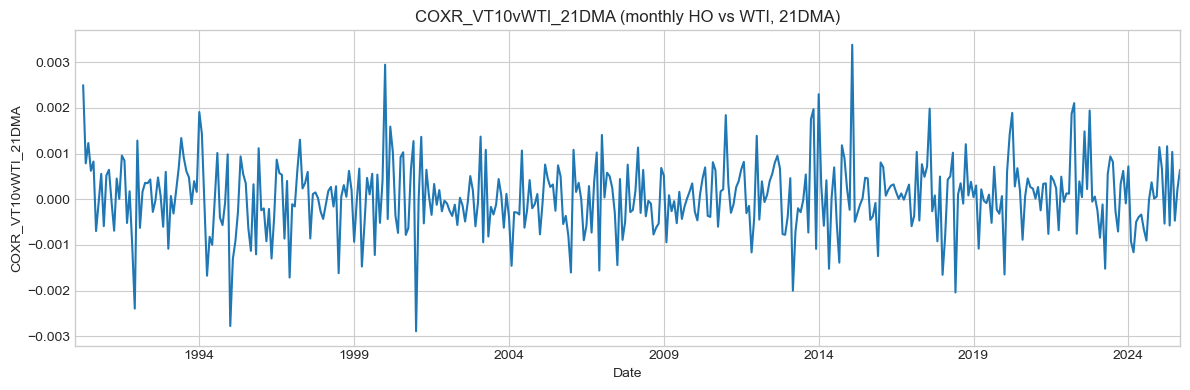

In [52]:
# --- visualization of the constructed factor ---
import matplotlib.pyplot as plt

# Basic full-history plot
plt.figure(figsize=(12, 4))
sample_df["COXR_VT10vWTI_21DMA"].plot()
plt.title("COXR_VT10vWTI_21DMA (monthly HO vs WTI, 21DMA)")
plt.xlabel("Date")
plt.ylabel("COXR_VT10vWTI_21DMA")
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
#Inventory score construction 
#------------------------------------

# --- importing file ---
oil_df = pd.read_excel(
    "/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Inventory /Crude oil, gasoline, HOL.xlsx")  # weekly: Gasoline, Distillate, Crude oil

ng_df = pd.read_excel(
    "/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Inventory /Natural gas.xlsx")  # monthly: Natural gas

# --- Parse dates ---
oil_df["Observation_date"] = pd.to_datetime(oil_df["Observation_date"])
ng_df["Observation_date"]  = pd.to_datetime(ng_df["Observation_date"])

oil_df = oil_df.set_index("Observation_date").sort_index()
ng_df  = ng_df.set_index("Observation_date").sort_index()

# --- Rename columns for clarity ---
oil_df = oil_df.rename(columns={
    "Gasoline":   "GSO_INV",
    "Distillate": "HOL_INV",
    "Crude oil":  "WTI_INV"
})
ng_df  = ng_df.rename(columns={
    "Natural gas": "NGS_INV"
})


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packagin

In [54]:
# --- Clean column names: strip spaces and standardize case --- 
oil_df.columns = oil_df.columns.str.strip()
ng_df.columns  = ng_df.columns.str.strip()

print("Cleaned oil cols:", oil_df.columns.tolist())
print("Cleaned ng cols:", ng_df.columns.tolist())

# --- rename using clean names ---
oil_df = oil_df.rename(columns={
    "Gasoline":   "GSO_INV",
    "Distillate": "HOL_INV",
    "Crude oil":  "WTI_INV"
})
ng_df  = ng_df.rename(columns={
    "Natural gas": "NGS_INV"
})

print("Renamed oil cols:", oil_df.columns.tolist())
print("Renamed ng cols:", ng_df.columns.tolist())


Cleaned oil cols: ['Gasoline', 'Distillate', 'Crude oil']
Cleaned ng cols: ['Natural gas']
Renamed oil cols: ['GSO_INV', 'HOL_INV', 'WTI_INV']
Renamed ng cols: ['NGS_INV']


In [55]:
#Inventory score construction - continuation
#------------------------------------

# --- monthly data ---
oil_month_end = (
    oil_df
    .resample("ME")   # month-end
    .mean()
) # weekly data is converted into monthly ones by averaging 

# --- shift to month-begin to match sample_df convention ---
oil_month = oil_month_end.copy()
oil_month.index = oil_month.index.to_period("M").to_timestamp()  # month-start
oil_month.index.name = "DATE"

# --- natural gas is monthly already; align index to month-start ---
ng_month = ng_df.copy()
ng_month.index = ng_month.index.to_period("M").to_timestamp()
ng_month.index.name = "DATE"

# --- Combine into a single monthly DataFrame from Jan-1990 ---
start = "1990-01-01"
inv_month = (
    oil_month.join(ng_month, how="outer")
    .loc[start:]            # from 1990-01-01
    .sort_index()
)

print(inv_month)

              GSO_INV    HOL_INV    WTI_INV    NGS_INV
DATE                                                  
1990-01-01  218823.25  113248.00  325584.25  2270000.0
1990-02-01  242131.75  121018.25  328151.50  2004000.0
1990-03-01  242285.20  107789.00  334290.00  1875000.0
1990-04-01  225245.25   97516.50  350901.75  1946000.0
1990-05-01  218931.25   98341.50  359099.00  2180000.0
...               ...        ...        ...        ...
2025-08-01  223563.00  114569.80  422008.60  3328534.0
2025-09-01  218727.50  122974.50  417826.75  3636795.0
2025-10-01  214269.00  115575.00  420800.80  3942177.0
2025-11-01  209195.25  112125.50  426542.00        NaN
2025-12-01  227317.25  119417.25  424454.50        NaN

[432 rows x 4 columns]


In [56]:
#Inventory score construction - continuation
#------------------------------------

# --- computing excess inventories ---
months_2y  = 18
months_15y = 10 * 12  # 180

excess = pd.DataFrame(index=inv_month.index)

for col in ["GSO_INV", "HOL_INV", "WTI_INV", "NGS_INV"]:
    med = (
        inv_month[col]
        .rolling(window=months_15y, min_periods=months_2y)
        .median()
    )
    excess[col.replace("_INV", "_XINV")] = inv_month[col] - med

print(excess.head(40))
print(excess.tail(40))

             GSO_XINV   HOL_XINV   WTI_XINV   NGS_XINV
DATE                                                  
1990-01-01        NaN        NaN        NaN        NaN
1990-02-01        NaN        NaN        NaN        NaN
1990-03-01        NaN        NaN        NaN        NaN
1990-04-01        NaN        NaN        NaN        NaN
1990-05-01        NaN        NaN        NaN        NaN
1990-06-01        NaN        NaN        NaN        NaN
1990-07-01        NaN        NaN        NaN        NaN
1990-08-01        NaN        NaN        NaN        NaN
1990-09-01        NaN        NaN        NaN        NaN
1990-10-01        NaN        NaN        NaN        NaN
1990-11-01        NaN        NaN        NaN        NaN
1990-12-01        NaN        NaN        NaN        NaN
1991-01-01        NaN        NaN        NaN        NaN
1991-02-01        NaN        NaN        NaN        NaN
1991-03-01        NaN        NaN        NaN        NaN
1991-04-01        NaN        NaN        NaN        NaN
1991-05-01

In [57]:
# --- Seasonal adjustment (simple seasonal-mean removal) ---
xinv_sa = pd.DataFrame(index=excess.index)

for col in excess.columns:
    # Monthly dummy-based seasonal mean
    tmp = excess[col].copy()
    month_means = tmp.groupby(tmp.index.month).transform("mean")
    xinv_sa[col + "_SA"] = tmp - month_means

print(xinv_sa.head(40))

            GSO_XINV_SA   HOL_XINV_SA   WTI_XINV_SA    NGS_XINV_SA
DATE                                                              
1990-01-01          NaN           NaN           NaN            NaN
1990-02-01          NaN           NaN           NaN            NaN
1990-03-01          NaN           NaN           NaN            NaN
1990-04-01          NaN           NaN           NaN            NaN
1990-05-01          NaN           NaN           NaN            NaN
1990-06-01          NaN           NaN           NaN            NaN
1990-07-01          NaN           NaN           NaN            NaN
1990-08-01          NaN           NaN           NaN            NaN
1990-09-01          NaN           NaN           NaN            NaN
1990-10-01          NaN           NaN           NaN            NaN
1990-11-01          NaN           NaN           NaN            NaN
1990-12-01          NaN           NaN           NaN            NaN
1991-01-01          NaN           NaN           NaN           

In [58]:
# Z-scores from excess inventories
# --------------------
xinvscore = pd.DataFrame(index=xinv_sa.index)

for col in ["GSO_XINV_SA", "HOL_XINV_SA", "WTI_XINV_SA", "NGS_XINV_SA"]:
    s = xinv_sa[col]
    roll_mean = s.rolling(window=60, min_periods=18).mean()  # 5-year mean
    roll_std  = s.rolling(window=60, min_periods=18).std()

    xinvscore[col.replace("_XINV_SA", "_XINVSCORE_SA")] = (s - roll_mean) / roll_std

print(xinvscore.head(40))

            GSO_XINVSCORE_SA  HOL_XINVSCORE_SA  WTI_XINVSCORE_SA  \
DATE                                                               
1990-01-01               NaN               NaN               NaN   
1990-02-01               NaN               NaN               NaN   
1990-03-01               NaN               NaN               NaN   
1990-04-01               NaN               NaN               NaN   
1990-05-01               NaN               NaN               NaN   
1990-06-01               NaN               NaN               NaN   
1990-07-01               NaN               NaN               NaN   
1990-08-01               NaN               NaN               NaN   
1990-09-01               NaN               NaN               NaN   
1990-10-01               NaN               NaN               NaN   
1990-11-01               NaN               NaN               NaN   
1990-12-01               NaN               NaN               NaN   
1991-01-01               NaN               NaN  

In [59]:
# --- check NANs ---
for col in ["GSO_XINVSCORE_SA", "HOL_XINVSCORE_SA", "WTI_XINVSCORE_SA", "NGS_XINVSCORE_SA"]:
    first_valid = xinvscore[col].first_valid_index()
    print(f"{col} first non-NaN:", first_valid)



GSO_XINVSCORE_SA first non-NaN: 1992-11-01 00:00:00
HOL_XINVSCORE_SA first non-NaN: 1992-11-01 00:00:00
WTI_XINVSCORE_SA first non-NaN: 1992-11-01 00:00:00
NGS_XINVSCORE_SA first non-NaN: 1992-11-01 00:00:00


In [60]:
# Composite factors
# --------------------

# Refined products: Gasoline + Heating Oil
REFIXINVCSCORE_SA = xinvscore[["GSO_XINVSCORE_SA", "HOL_XINVSCORE_SA"]].mean(axis=1)

# Base energy: WTI + Natural Gas
BASEXINVCSCORE_SA = xinvscore[["WTI_XINVSCORE_SA", "NGS_XINVSCORE_SA"]].mean(axis=1)

composites = pd.DataFrame({
    "REFIXINVCSCORE_SA": REFIXINVCSCORE_SA,
    "BASEXINVCSCORE_SA": BASEXINVCSCORE_SA
}, index=xinvscore.index)

print(composites.tail())


            REFIXINVCSCORE_SA  BASEXINVCSCORE_SA
DATE                                            
2025-08-01          -0.390875          -0.367988
2025-09-01          -0.276820          -0.324064
2025-10-01          -0.652339          -0.214729
2025-11-01          -0.877147          -0.602628
2025-12-01           0.073849          -0.442614


In [61]:
add_factor_to_sample(composites, "REFIXINVCSCORE_SA")
add_factor_to_sample(composites, "BASEXINVCSCORE_SA")


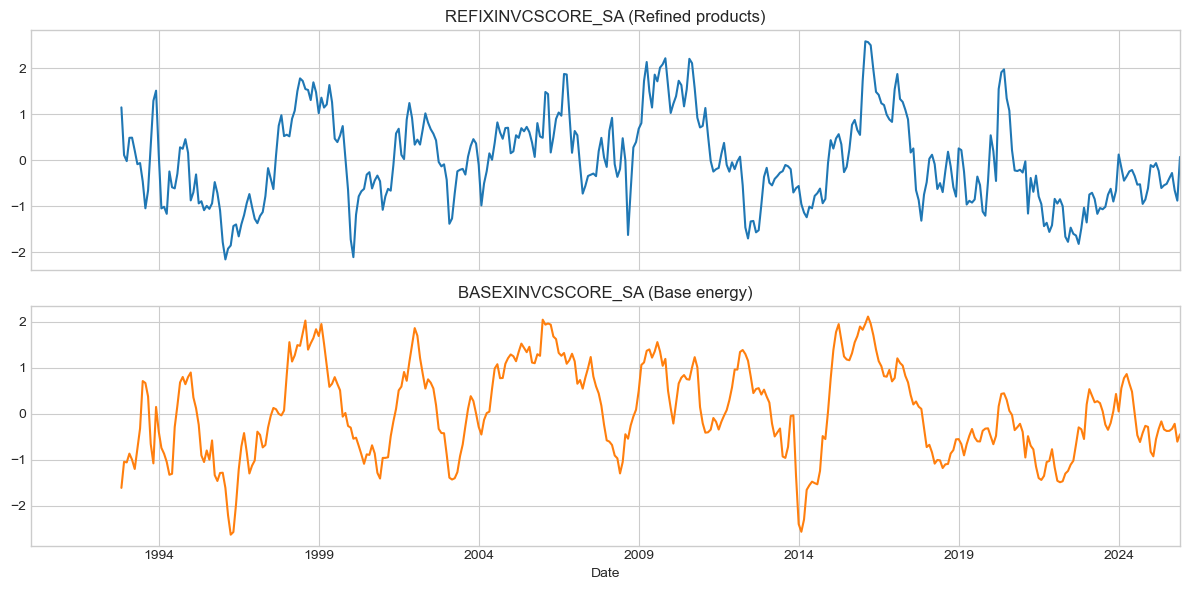

In [123]:
# --- visual check ---
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
composites["REFIXINVCSCORE_SA"].plot(ax=axes[0], color="tab:blue")
axes[0].set_title("REFIXINVCSCORE_SA (Refined products)")
axes[0].grid(True)

composites["BASEXINVCSCORE_SA"].plot(ax=axes[1], color="tab:orange")
axes[1].set_title("BASEXINVCSCORE_SA (Base energy)")
axes[1].set_xlabel("Date")
axes[1].grid(True)

plt.tight_layout()
plt.show()



In [125]:
# --- add list of factors from sample_df to QDF main ---

qdf_list = [
    to_qdf_monthly(sample_df, col=c, xcat=c, cid=cid)
    for c in sample_df.columns
]
qdf_main = pd.concat(qdf_list, ignore_index=True)

qdf_main

cid               xcat  real_date     value
0     USA        CPIC_YOY_D3 1990-01-01  0.113778
1     USA        CPIC_YOY_D3 1990-02-01  0.191547
2     USA        CPIC_YOY_D3 1990-03-01  0.343625
3     USA        CPIC_YOY_D3 1990-04-01  0.424453
4     USA        CPIC_YOY_D3 1990-05-01  0.183954
...   ...                ...        ...       ...
9862  USA  BASEXINVCSCORE_SA 2025-05-01 -0.162233
9863  USA  BASEXINVCSCORE_SA 2025-06-01 -0.335762
9864  USA  BASEXINVCSCORE_SA 2025-07-01 -0.370625
9865  USA  BASEXINVCSCORE_SA 2025-08-01 -0.367988
9866  USA  BASEXINVCSCORE_SA 2025-09-01 -0.324064

[9867 rows x 4 columns]

In [127]:
# --- completeness check ---
na_by_xcat = (
    qdf_main
    .groupby('xcat')['value']
    .apply(lambda s: s.isna().sum())
    .sort_values(ascending=False)
)

print(na_by_xcat)

xcat
EXP_YOY_3MMA           36
XEXP_YOY               36
BASEXINVCSCORE_SA      34
REFIXINVCSCORE_SA      34
MBCSCORE_SA_Z_D3M       5
COXR_VT10vWTI_21DMA     3
CPIC_YOY_D3             0
XCPIE_YOY               0
XPPI_YOY                0
XIP_YOY                 0
CCS_SA_Z_D3M            0
XCREDIT                 0
XCPIH_YOY               0
XCPIF_YOY               0
UNEMP_3MMAv5YMA         0
XCPIC_YOY               0
CPIE_YOY_D3             0
UNEMP_3MMA_DYOY         0
CCS_SA_Z                0
MBCSCORE_SA_Z           0
CPIH_YOY_D3             0
CPIF_YOY_D3             0
XRPCE_YOY_3MMA          0
Name: value, dtype: int64


In [129]:
# --- fixing the data ---
qdf_fix = qdf_main.copy()
qdf_fix['real_date'] = pd.to_datetime(qdf_fix['real_date'])

# --- shift each date to the corresponding business month‑end ---
from pandas.tseries.offsets import BMonthEnd
qdf_fix['real_date'] = qdf_fix['real_date'] + BMonthEnd(0)

# --- restricting the data to the period of study ---
qdf_1993 = qdf_fix.loc[qdf_fix['real_date'] >= '1993-01-01'].copy()

# --- check ---
qdf_1993['real_date'].sort_values().head()
qdf_1993['real_date'].sort_values().tail()

9437   2025-09-30
3002   2025-09-30
6863   2025-09-30
8150   2025-09-30
9866   2025-09-30
Name: real_date, dtype: datetime64[ns]

In [131]:
# --- construction of z score of all the variables --- 
orig_xcats = sorted(qdf_1993['xcat'].unique())
cids_eqx   = ['USA']
zscore_threshold = 3

dfx = qdf_1993.copy()
dfa = pd.DataFrame(columns=dfx.columns)

for xc in orig_xcats:
    dfaa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cids_eqx,
        sequential=True,
        min_obs= 12 * 5,      # 5 years of monthly data
        neutral="zero",
        pan_weight=1,
        thresh=zscore_threshold,
        postfix="_ZN",
        est_freq="Q",
    )
    dfa = msm.update_df(dfa, dfaa)

# dfx now has raw + scored; build final scored-only panel
dfx = msm.update_df(dfx, dfa)

scored_xcats = [s + "_ZN" for s in orig_xcats]

qdfx = dfx.loc[dfx["xcat"].isin(scored_xcats)].copy()

In [133]:
qdfx

cid                  xcat  real_date     value
393    USA  BASEXINVCSCORE_SA_ZN 1993-03-31 -1.179125
394    USA  BASEXINVCSCORE_SA_ZN 1993-04-30 -1.417308
395    USA  BASEXINVCSCORE_SA_ZN 1993-05-31 -0.901551
396    USA  BASEXINVCSCORE_SA_ZN 1993-06-30 -0.373894
397    USA  BASEXINVCSCORE_SA_ZN 1993-07-30  0.846738
...    ...                   ...        ...       ...
18027  USA     XRPCE_YOY_3MMA_ZN 2025-05-30  0.278851
18028  USA     XRPCE_YOY_3MMA_ZN 2025-06-30  0.086559
18029  USA     XRPCE_YOY_3MMA_ZN 2025-07-31 -0.094416
18030  USA     XRPCE_YOY_3MMA_ZN 2025-08-29 -0.068895
18031  USA     XRPCE_YOY_3MMA_ZN 2025-09-30 -0.172628

[8993 rows x 4 columns]

In [135]:
# --- sanity checks (1) ----
# NA counts by xcats 
na_by_xcat = (
    qdfx.groupby('xcat')['value']
        .apply(lambda s: s.isna().sum())
        .sort_values(ascending=False)
)
print(na_by_xcat)

xcat
BASEXINVCSCORE_SA_ZN      0
UNEMP_3MMA_DYOY_ZN        0
XPPI_YOY_ZN               0
XIP_YOY_ZN                0
XEXP_YOY_ZN               0
XCREDIT_ZN                0
XCPIH_YOY_ZN              0
XCPIF_YOY_ZN              0
XCPIE_YOY_ZN              0
XCPIC_YOY_ZN              0
UNEMP_3MMAv5YMA_ZN        0
REFIXINVCSCORE_SA_ZN      0
CCS_SA_Z_D3M_ZN           0
MBCSCORE_SA_Z_ZN          0
MBCSCORE_SA_Z_D3M_ZN      0
EXP_YOY_3MMA_ZN           0
CPIH_YOY_D3_ZN            0
CPIF_YOY_D3_ZN            0
CPIE_YOY_D3_ZN            0
CPIC_YOY_D3_ZN            0
COXR_VT10vWTI_21DMA_ZN    0
CCS_SA_Z_ZN               0
XRPCE_YOY_3MMA_ZN         0
Name: value, dtype: int64


In [137]:
# --- sanity check (2) ----
# summary staistics 
summary = (
    qdfx.groupby('xcat')['value']
        .agg(['mean', 'std', 'min', 'max'])
)

(summary)

mean       std       min       max
xcat                                                          
BASEXINVCSCORE_SA_ZN    0.080957  1.126623      -3.0  2.332554
CCS_SA_Z_D3M_ZN        -0.004865  1.404473      -3.0       3.0
CCS_SA_Z_ZN             0.096814  1.239780      -3.0  2.399271
COXR_VT10vWTI_21DMA_ZN  0.073132  1.205634      -3.0       3.0
CPIC_YOY_D3_ZN          -0.13158  1.496799      -3.0       3.0
CPIE_YOY_D3_ZN          0.019254  1.475735      -3.0       3.0
CPIF_YOY_D3_ZN          0.050498  1.392529      -3.0       3.0
CPIH_YOY_D3_ZN           0.00349  1.518453      -3.0       3.0
EXP_YOY_3MMA_ZN         0.595061  1.106605      -3.0       3.0
MBCSCORE_SA_Z_D3M_ZN   -0.030617  1.178155      -3.0       3.0
MBCSCORE_SA_Z_ZN        0.104886  1.270240      -3.0       3.0
REFIXINVCSCORE_SA_ZN   -0.004524  1.206037   -2.6278       3.0
UNEMP_3MMA_DYOY_ZN     -0.280008  1.393562      -3.0       3.0
UNEMP_3MMAv5YMA_ZN     -0.226989  1.336561 -2.077463       3.0
XCPIC_YOY_ZN            0.085883  1.582851      -3.0       3.0
XCPIE_YOY_ZN            0.132996  1.619019      -3.0       3.0
XCPIF_YOY_ZN             0.34401  1.546473      -3.0       3.0
XCPIH_YOY_ZN            0.224979  1.608299      -3.0       3.0
XCREDIT_ZN              0.249011  1.203176      -3.0       3.0
XEXP_YOY_ZN              0.11468  1.445844      -3.0       3.0
XIP_YOY_ZN             -0.362439  1.300217      -3.0       3.0
XPPI_YOY_ZN             0.029519  1.533435      -3.0       3.0
XRPCE_YOY_3MMA_ZN       0.126459  1.411259      -3.0       3.0

/var/folders/tc/b4dwhc6n1x99n484fh4lpj700000gn/T/ipykernel_21214/3729268255.py:51: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


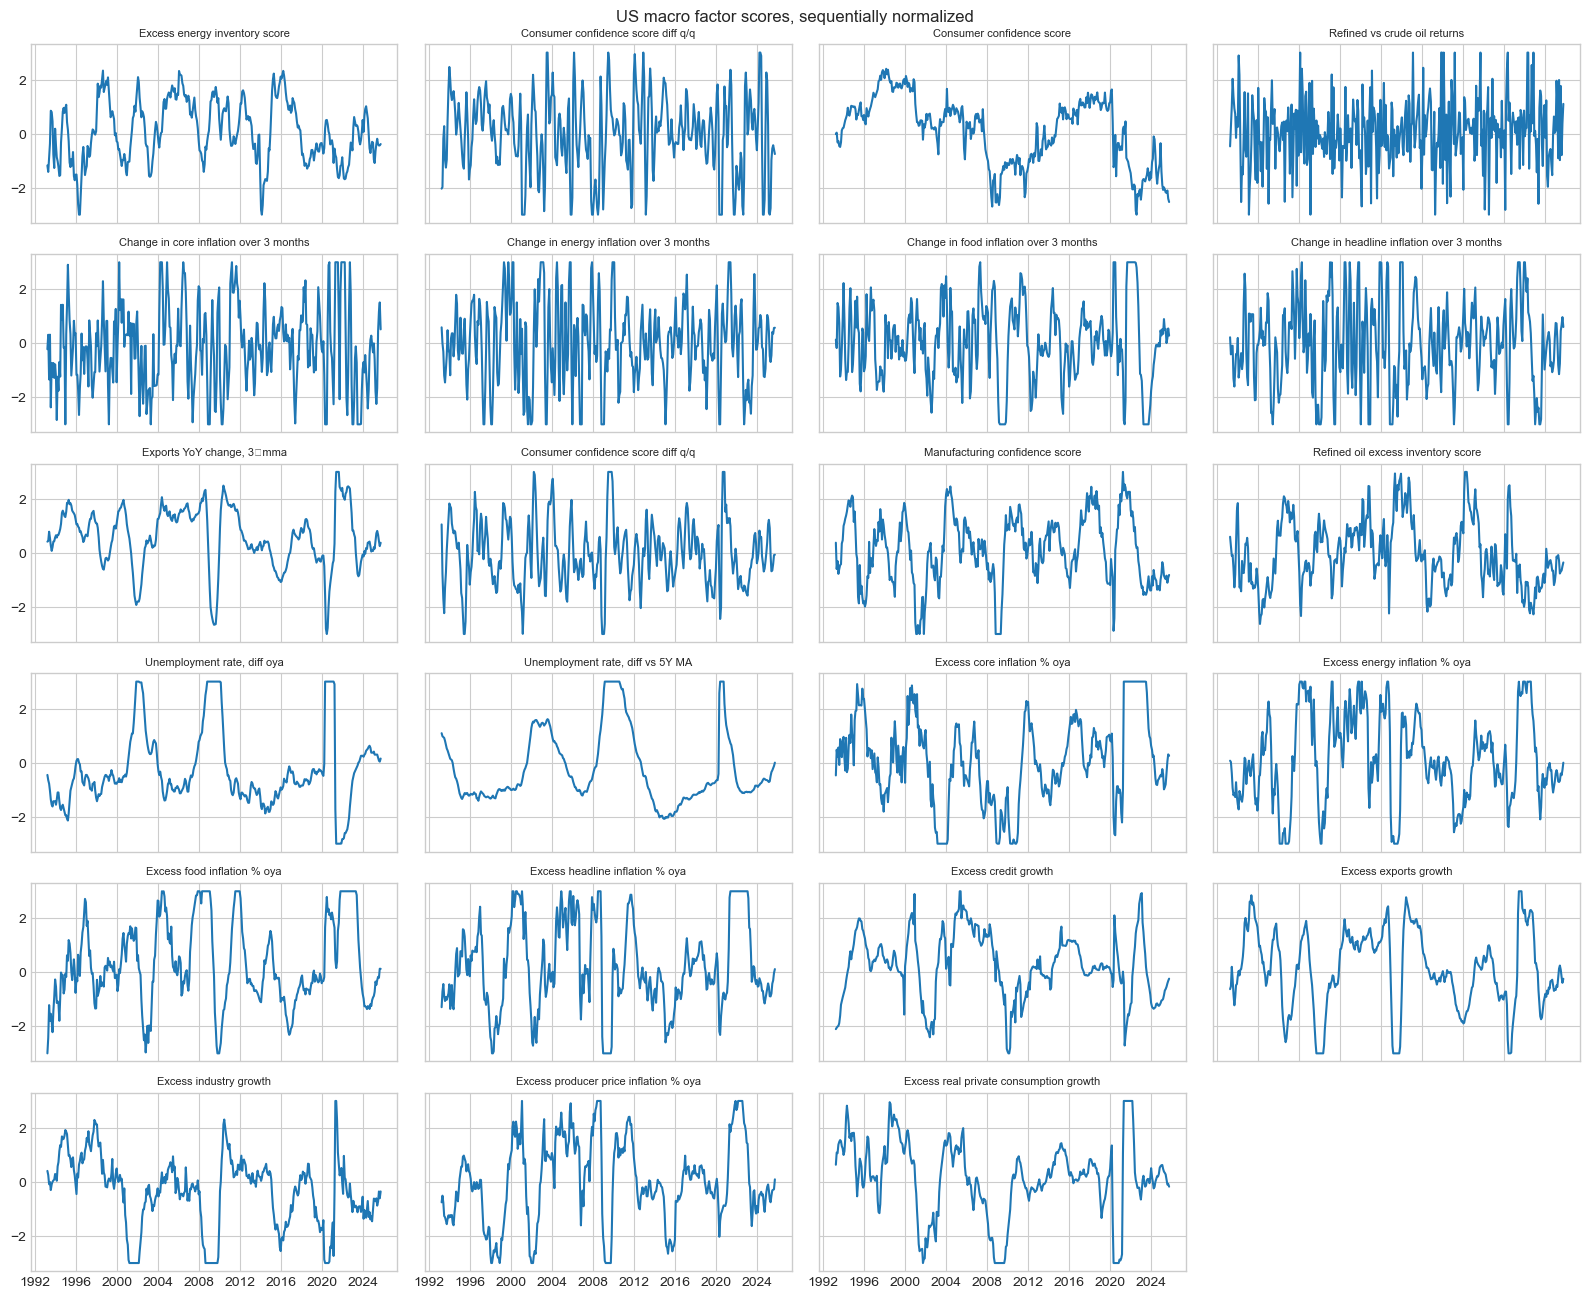

In [145]:
# --- sanity check (3) ----
# visualization of US macro 
import matplotlib.pyplot as plt

label_map = {
    "CPIC_YOY_D3_ZN"      : "Change in core inflation over 3 months",
    "XCPIC_YOY_ZN"        : "Excess core inflation % oya",
    "CPIH_YOY_D3_ZN"      : "Change in headline inflation over 3 months",
    "XCPIH_YOY_ZN"        : "Excess headline inflation % oya",
    "XPPI_YOY_ZN"         : "Excess producer price inflation % oya",
    "CPIF_YOY_D3_ZN"      : "Change in food inflation over 3 months",
    "XCPIF_YOY_ZN"        : "Excess food inflation % oya",
    "CPIE_YOY_D3_ZN"      : "Change in energy inflation over 3 months",
    "XCPIE_YOY_ZN"        : "Excess energy inflation % oya",
    "UNEMP_3MMA_DYOY_ZN"  : "Unemployment rate, diff oya",
    "UNEMP_3MMAv5YMA_ZN"  : "Unemployment rate, diff vs 5Y MA",
    "EXP_YOY_3MMA_ZN"     : "Exports YoY change, 3‑mma",
    "XEXP_YOY_ZN"         : "Excess exports growth",
    "XIP_YOY_ZN"          : "Excess industry growth",
    "XRPCE_YOY_3MMA_ZN"   : "Excess real private consumption growth",
    "XCREDIT_ZN"          : "Excess credit growth",
    "CCS_SA_Z_ZN"         : "Consumer confidence score",
    "CCS_SA_Z_D3M_ZN"     : "Consumer confidence score diff q/q",
    "MBCSCORE_SA_Z_ZN"       : "Manufacturing confidence score",
    "MBCSCORE_SA_Z_D3M_ZN"   : "Consumer confidence score diff q/q",
    "COXR_VT10vWTI_21DMA_ZN": "Refined vs crude oil returns",
    "REFIXINVCSCORE_SA_ZN" : "Refined oil excess inventory score",
    "BASEXINVCSCORE_SA_ZN": "Excess energy inventory score"
    
}

factorz = sorted(qdfx['xcat'].unique())
n = len(factorz)
ncol = 4
nrow = (n + ncol - 1) // ncol

fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 2.2*nrow),
                         sharex=True, sharey=True)
axes = axes.flatten()

for ax, xc in zip(axes, factorz):
    s = qdfx.loc[qdfx['xcat'] == xc].set_index('real_date')['value']
    ax.plot(s.index, s.values)
    ax.set_title(label_map.get(xc, xc), fontsize=8)   
    ax.grid(True)

for ax in axes[n:]:
    ax.axis('off')

fig.suptitle("US macro factor scores, sequentially normalized", fontsize=12)
plt.tight_layout()
plt.show()


In [147]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_wide = (
    qdfx
    .pivot(index="real_date", columns="xcat", values="value")
    .sort_index()
)
df_wide = df_wide[scored_xcats]


In [149]:
# --- sanity check (4) ---
# Autocorrelation tests: for checking persistency 
max_lag = 12
lb_lags = [1, 4, 8, 12]

auto_rows = []

for col in df_wide.columns:
    s = df_wide[col].dropna()
    if len(s) < max_lag + 5:
        continue

    # ACF
    acf_vals = acf(s, nlags=max_lag, fft=True)
    # Ljung–Box
    lb = acorr_ljungbox(s, lags=lb_lags, return_df=True)

    row = {
        "xcat": col,
        "n_obs": len(s),
    }

    for lag in [1, 3, 6, 12]:
        if lag <= max_lag:
            row[f"acf_lag{lag}"] = acf_vals[lag]
        else:
            row[f"acf_lag{lag}"] = np.nan

    for lg in lb_lags:
        row[f"lb_p_lag{lg}"] = lb.loc[lg, "lb_pvalue"]

    auto_rows.append(row)

auto_df = (
    pd.DataFrame(auto_rows)
    .set_index("xcat")
    .sort_index()
)
display(auto_df)


n_obs  acf_lag1  acf_lag3  acf_lag6  acf_lag12  \
xcat                                                                     
BASEXINVCSCORE_SA_ZN      391  0.944769  0.768381  0.564848   0.150039   
CCS_SA_Z_D3M_ZN           391  0.755976 -0.053374  0.116890  -0.251645   
CCS_SA_Z_ZN               391  0.954223  0.888705  0.829987   0.681592   
COXR_VT10vWTI_21DMA_ZN    391  0.001054  0.024658 -0.033607  -0.026567   
CPIC_YOY_D3_ZN            391  0.710890  0.075444  0.156207  -0.365112   
CPIE_YOY_D3_ZN            391  0.711816 -0.014142  0.026841  -0.441038   
CPIF_YOY_D3_ZN            391  0.840220  0.412427  0.229789  -0.374151   
CPIH_YOY_D3_ZN            391  0.724383  0.053970  0.061741  -0.415253   
EXP_YOY_3MMA_ZN           391  0.972820  0.823891  0.517114  -0.069927   
MBCSCORE_SA_Z_D3M_ZN      391  0.857740  0.319506  0.064407  -0.287791   
MBCSCORE_SA_Z_ZN          391  0.929226  0.785517  0.533582  -0.026371   
REFIXINVCSCORE_SA_ZN      391  0.893733  0.685922  0.523362   0.332172   
UNEMP_3MMA_DYOY_ZN        391  0.970451  0.865401  0.684243   0.273152   
UNEMP_3MMAv5YMA_ZN        391  0.988550  0.945242  0.854609   0.651227   
XCPIC_YOY_ZN              391  0.946090  0.829205  0.661678   0.256370   
XCPIE_YOY_ZN              391  0.936779  0.735728  0.473950  -0.080076   
XCPIF_YOY_ZN              391  0.959109  0.840238  0.603410   0.063151   
XCPIH_YOY_ZN              391  0.938583  0.755779  0.523422   0.009706   
XCREDIT_ZN                391  0.943261  0.827445  0.602254   0.110777   
XEXP_YOY_ZN               391  0.973329  0.835532  0.548182  -0.030208   
XIP_YOY_ZN                391  0.953187  0.840691  0.659483   0.253430   
XPPI_YOY_ZN               391  0.956876  0.821815  0.567056   0.019055   
XRPCE_YOY_3MMA_ZN         391  0.961057  0.810956  0.605996   0.154683   

                           lb_p_lag1      lb_p_lag4      lb_p_lag8  \
xcat                                                                 
BASEXINVCSCORE_SA_ZN    1.819133e-78  1.601358e-229   0.000000e+00   
CCS_SA_Z_D3M_ZN         6.724160e-51   2.813406e-58   3.070687e-62   
CCS_SA_Z_ZN             5.242652e-80  5.751029e-280   0.000000e+00   
COXR_VT10vWTI_21DMA_ZN  9.833113e-01   4.199276e-01   6.960118e-01   
CPIC_YOY_D3_ZN          3.254321e-45   4.798189e-55   7.731032e-63   
CPIE_YOY_D3_ZN          2.506659e-45   2.749758e-48   3.908036e-45   
CPIF_YOY_D3_ZN          1.892764e-62  9.421041e-117  9.307402e-127   
CPIH_YOY_D3_ZN          7.037441e-47   2.361774e-52   4.838753e-50   
EXP_YOY_3MMA_ZN         4.416078e-83  5.385166e-254   0.000000e+00   
MBCSCORE_SA_Z_D3M_ZN    5.284690e-65  2.201360e-102   1.148162e-99   
MBCSCORE_SA_Z_ZN        5.743229e-76  4.343867e-231  8.812682e-312   
REFIXINVCSCORE_SA_ZN    2.049864e-70  2.308943e-192  2.965981e-276   
UNEMP_3MMA_DYOY_ZN      1.096355e-82  5.884086e-272   0.000000e+00   
UNEMP_3MMAv5YMA_ZN      9.965593e-86  1.493868e-311   0.000000e+00   
XCPIC_YOY_ZN            1.110715e-78  7.078686e-253   0.000000e+00   
XCPIE_YOY_ZN            3.546284e-77  3.584796e-215  4.226420e-278   
XCPIF_YOY_ZN            8.268743e-81  6.110543e-258   0.000000e+00   
XCPIH_YOY_ZN            1.817425e-77  6.452989e-223  5.371412e-302   
XCREDIT_ZN              3.192555e-78  6.585884e-250   0.000000e+00   
XEXP_YOY_ZN             3.631086e-83  6.808899e-259   0.000000e+00   
XIP_YOY_ZN              7.745238e-80  3.910144e-258   0.000000e+00   
XPPI_YOY_ZN             1.925305e-80  1.763726e-249   0.000000e+00   
XRPCE_YOY_3MMA_ZN       3.949715e-81  1.445772e-248   0.000000e+00   

                           lb_p_lag12  
xcat                                   
BASEXINVCSCORE_SA_ZN     0.000000e+00  
CCS_SA_Z_D3M_ZN          4.058146e-68  
CCS_SA_Z_ZN              0.000000e+00  
COXR_VT10vWTI_21DMA_ZN   2.358832e-01  
CPIC_YOY_D3_ZN           3.456246e-77  
CPIE_YOY_D3_ZN           3.050811e-62  
CPIF_YOY_D3_ZN          4.634364e-145  
CPIH_YOY_D3_ZN           3.951359e-65  
EXP_YOY_3MMA_ZN       

In [151]:
# --- sanity check (5) ---
# Stationarity tests

adf_rows = []

for col in df_wide.columns:
    s = df_wide[col].dropna()
    if len(s) < 20:
        continue

    res = adfuller(s, autolag="AIC")

    adf_rows.append({
        "xcat": col,
        "n_obs": len(s),
        "adf_stat": res[0],
        "p_value": res[1],
        "lags_used": res[2],
    })

adf_df = (
    pd.DataFrame(adf_rows)
    .set_index("xcat")
    .sort_values("p_value")
)
display(adf_df)


n_obs   adf_stat       p_value  lags_used
xcat                                                             
COXR_VT10vWTI_21DMA_ZN    391 -19.663667  0.000000e+00          0
MBCSCORE_SA_Z_D3M_ZN      391  -6.935283  1.058527e-09          9
CCS_SA_Z_D3M_ZN           391  -6.485640  1.262954e-08         12
CPIE_YOY_D3_ZN            391  -5.954561  2.108224e-07         13
CPIH_YOY_D3_ZN            391  -5.677672  8.629618e-07         12
CPIF_YOY_D3_ZN            391  -5.668781  9.022480e-07         17
CPIC_YOY_D3_ZN            391  -5.636809  1.058486e-06         13
EXP_YOY_3MMA_ZN           391  -5.109071  1.344200e-05         16
MBCSCORE_SA_Z_ZN          391  -5.014604  2.076261e-05         12
XCPIF_YOY_ZN              391  -4.972317  2.517004e-05         14
BASEXINVCSCORE_SA_ZN      391  -4.644006  1.070791e-04          6
XCPIE_YOY_ZN              391  -4.633060  1.122096e-04         17
XCPIH_YOY_ZN              391  -4.608382  1.246517e-04         17
XPPI_YOY_ZN               391  -4.574361  1.439790e-04         16
XEXP_YOY_ZN               391  -4.454521  2.373921e-04         13
REFIXINVCSCORE_SA_ZN      391  -4.042323  1.204408e-03         13
XIP_YOY_ZN                391  -3.478456  8.557943e-03         12
UNEMP_3MMA_DYOY_ZN        391  -3.474072  8.678487e-03         14
XRPCE_YOY_3MMA_ZN         391  -3.375224  1.183303e-02         15
XCPIC_YOY_ZN              391  -3.300413  1.486002e-02         13
XCREDIT_ZN                391  -3.145227  2.338224e-02         12
UNEMP_3MMAv5YMA_ZN        391  -2.474781  1.217316e-01          6
CCS_SA_Z_ZN               391  -1.845961  3.578935e-01          9

/var/folders/tc/b4dwhc6n1x99n484fh4lpj700000gn/T/ipykernel_21214/2183393790.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(freq)
/var/folders/tc/b4dwhc6n1x99n484fh4lpj700000gn/T/ipykernel_21214/2183393790.py:39: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist, method="average")
/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.p

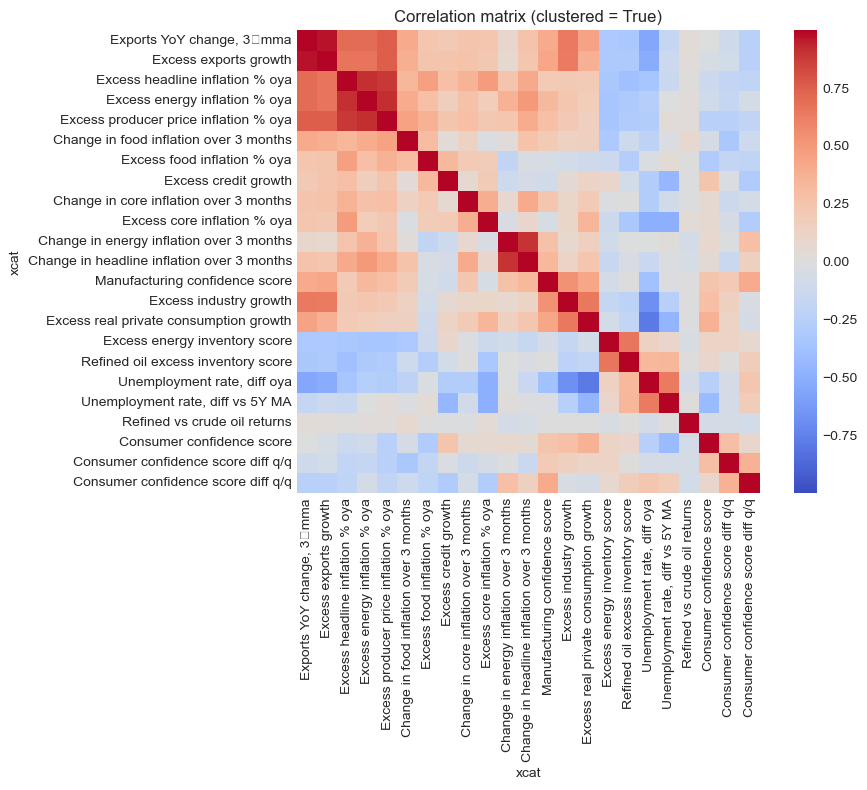

In [153]:
# --- sanity check (6)
# --- correlation ---

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def simple_correl_matrix(
    df_long,
    freq="M",
    xcats=None,
    max_color=0.999,
    size=(6, 4),
    cluster=True,
    xcat_labels=None,
):
    """
    df_long: long-format DataFrame with ['real_date', 'xcat', 'value']
             (USA only in your case)
    """

    d = df_long.copy()

    if xcats is not None:
        d = d[d["xcat"].isin(xcats)]

    wide = (
        d.pivot(index="real_date", columns="xcat", values="value")
         .sort_index()
         .resample(freq)
         .mean()
    )

    wide = wide.dropna(how="all")
    corr = wide.corr()

    if cluster and corr.shape[0] > 1:
        dist = 1 - corr
        Z = linkage(dist, method="average")
        order = leaves_list(Z)
        corr = corr.iloc[order, order]

    vmin, vmax = -max_color, max_color
    plt.figure(figsize=size)

    labels = (
        [xcat_labels.get(c, c) for c in corr.columns]
        if xcat_labels is not None
        else corr.columns
    )

    sns.heatmap(
        corr,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        xticklabels=labels,
        yticklabels=labels,
        square=True,
    )
    plt.title("Correlation matrix (clustered = %s)" % cluster)
    plt.tight_layout()
    plt.show()

    return corr

corr_df_clustered = simple_correl_matrix(
    df_long=qdfx,
    freq="M",
    xcats=scored_xcats,
    max_color=0.999,
    size=(10, 8),
    cluster=True,
    xcat_labels=label_map
)


In [155]:
import pandas as pd

def load_stooq_daily(ticker, start="1990-01-01"):
    url = f"https://stooq.com/q/d/l/?s={ticker}.US&i=d"
    prices = pd.read_csv(url)

    # If there is no 'Date' column at all, return None and handle later
    if "Date" not in prices.columns:
        print(f"{ticker}: no 'Date' column, columns are {list(prices.columns)}")
        return None

    prices["Date"] = pd.to_datetime(prices["Date"])
    prices = prices.set_index("Date").sort_index()
    prices = prices[prices.index >= start]

    # Ensure expected price columns exist
    for col in ["Open", "High", "Low", "Close"]:
        if col not in prices.columns:
            print(f"{ticker}: missing column {col}, columns are {list(prices.columns)}")
            return None

    return prices[["Open", "High", "Low", "Close"]]

tickers_usns = [
    "XOM","APA","NEM","FMC","HD","WEN",
    "PG","SEB","AAPL","DXC","DIS","IPG",
    "JPM","CNA","NEE","MDU","LLY","XRAY",
    "WELL","CUZ","GE","MAN", "CSC"
]

price_dict = {}
for t in tickers_usns:
    print(f"Downloading {t}...")
    prices_t = load_stooq_daily(t)
    if prices_t is not None and not prices_t.empty:
        price_dict[t] = prices_t
    else:
        print(f"{t}: skipped (no usable data)")

# Build close-panel only from successfully downloaded tickers
valid_tickers = list(price_dict.keys())
close_panel = (
    pd.concat({t: price_dict[t]["Close"] for t in valid_tickers}, axis=1)
    .sort_index()
)

print("Tickers with data:", valid_tickers)
print(close_panel.head())


IPG: no 'Date' column, columns are ['No data']
IPG: skipped (no usable data)
CSC: no 'Date' column, columns are ['No data']
CSC: skipped (no usable data)
Tickers with data: ['XOM', 'APA', 'NEM', 'FMC', 'HD', 'WEN', 'PG', 'SEB', 'AAPL', 'DXC', 'DIS', 'JPM', 'CNA', 'NEE', 'MDU', 'LLY', 'XRAY', 'WELL', 'CUZ', 'GE', 'MAN']
                XOM      APA      NEM  FMC       HD       WEN       PG  SEB  \
Date                                                                          
1990-01-02  7.44833  5.27988  26.2143  NaN  1.40519  0.427730  6.17343  NaN   
1990-01-03  7.37441  5.35238  26.0044  NaN  1.41275  0.427730  6.15932  NaN   
1990-01-04  7.30002  5.04583  26.1466  NaN  1.42051  0.404373  6.03965  NaN   
1990-01-05  7.26336  4.90122  26.8325  NaN  1.39782  0.412156  5.93389  NaN   
1990-01-08  7.37441  5.20777  26.2143  NaN  1.38998  0.404373  6.03965  NaN   

                AAPL  DXC  ...      JPM  CNA  NEE  MDU      LLY  XRAY  WELL  \
Date                       ...                

In [157]:
close_panel

XOM       APA       NEM    FMC         HD       WEN  \
Date                                                                    
1990-01-02    7.44833   5.27988   26.2143    NaN    1.40519  0.427730   
1990-01-03    7.37441   5.35238   26.0044    NaN    1.41275  0.427730   
1990-01-04    7.30002   5.04583   26.1466    NaN    1.42051  0.404373   
1990-01-05    7.26336   4.90122   26.8325    NaN    1.39782  0.412156   
1990-01-08    7.37441   5.20777   26.2143    NaN    1.38998  0.404373   
...               ...       ...       ...    ...        ...       ...   
2026-01-26  134.84000  25.40000  125.9200  16.13  386.53000  8.080000   
2026-01-27  136.83000  25.83000  127.0000  16.08  380.36000  7.980000   
2026-01-28  137.58000  26.01000  131.9500  16.02  375.30000  7.940000   
2026-01-29  140.51000  26.26000  126.9300  15.91  371.81000  7.720000   
2026-01-30  141.40000  26.41000  112.3500  15.80  374.59000  7.790000   

                   PG      SEB        AAPL    DXC  ...        JPM    CNA  \
Date                                               ...                     
1990-01-02    6.17343      NaN    0.279184    NaN  ...    4.76553    NaN   
1990-01-03    6.15932      NaN    0.281325    NaN  ...    4.92449    NaN   
1990-01-04    6.03965      NaN    0.281894    NaN  ...    4.93854    NaN   
1990-01-05    5.93389      NaN    0.283112    NaN  ...    4.96045    NaN   
1990-01-08    6.03965      NaN    0.284939    NaN  ...    4.96045    NaN   
...               ...      ...         ...    ...  ...        ...    ...   
2026-01-26  149.49000  4919.46  255.410000  14.75  ...  301.04000  47.02   
2026-01-27  148.34000  5038.71  258.270000  14.67  ...  300.31000  46.74   
2026-01-28  147.34000  4937.43  256.440000  14.43  ...  300.77000  47.23   
2026-01-29  149.90000  5027.23  258.280000  14.41  ...  306.42000  47.78   
2026-01-30  151.77000  5082.28  259.480000  14.43  ...  305.89000  47.86   

              NEE    MDU        LLY   XRAY    WELL    CUZ        GE    MAN  
Date                                                                        
1990-01-02    NaN    NaN    12.0570    NaN     NaN    NaN   26.7472    NaN  
1990-01-03    NaN    NaN    12.0570    NaN     NaN    NaN   26.6985    NaN  
1990-01-04    NaN    NaN    11.9955    NaN     NaN    NaN   26.5503    NaN  
1990-01-05    NaN    NaN    11.8609    NaN     NaN    NaN   26.3077    NaN  
1990-01-08    NaN    NaN    11.8609    NaN     NaN    NaN   26.4565    NaN  
...           ...    ...        ...    ...     ...    ...       ...    ...  
2026-01-26  85.47  20.46  1062.7500  12.72  183.63  25.58  295.0600  30.40  
2026-01-27  87.15  20.52  1039.5100  12.77  183.49  25.55  297.4700  30.10  
2026-01-28  87.57  20.44  1023.8000  12.31  183.94  24.82  292.4800  28.96  
2026-01-29  88.18  20.53  1024.1400  12.27  185.69  25.29  298.8600  33.29  
2026-01-30  87.90  20.51  1037.1500  12.47  188.36  25.24  306.7900  36.33  

[9086 rows x 21 columns]

In [159]:
# --- check for NANs ---

# restrict to data from 1992
close_from_1992 = close_panel[close_panel.index >= "1992-01-01"]

# NaN count per ticker
nan_counts = close_from_1992.isna().sum()
print(nan_counts)

XOM        1
APA        2
NEM        0
FMC     3315
HD         1
WEN        3
PG         0
SEB      912
AAPL       0
DXC     6361
DIS        3
JPM        1
CNA     3315
NEE     3315
MDU     3315
LLY        0
XRAY       5
WELL    3315
CUZ     3315
GE         3
MAN     3315
dtype: int64


In [161]:
# Restrict to dates from 1992 if you want
close_from_1992 = close_panel[close_panel.index >= "1992-01-01"]

first_valid_dates = {}

for ticker in close_from_1992.columns:
    mask = close_from_1992[ticker].notna()
    if mask.any():
        first_valid_dates[ticker] = close_from_1992.index[mask.argmax()]
    else:
        first_valid_dates[ticker] = None  # no data at all

first_valid_series = pd.Series(first_valid_dates, name="first_non_nan_date").sort_index()
print(first_valid_series)


AAPL   1992-01-02
APA    1992-01-02
CNA    2005-02-25
CUZ    2005-02-25
DIS    1992-01-02
DXC    2017-04-04
FMC    2005-02-25
GE     1992-01-02
HD     1992-01-02
JPM    1992-01-02
LLY    1992-01-02
MAN    2005-02-25
MDU    2005-02-25
NEE    2005-02-25
NEM    1992-01-02
PG     1992-01-02
SEB    1992-03-23
WELL   2005-02-25
WEN    1992-01-02
XOM    1992-01-02
XRAY   1992-01-02
Name: first_non_nan_date, dtype: datetime64[ns]


In [163]:
# --- list of stocks that have data available ---
mask_1992 = (
    (first_valid_series >= "1992-01-01") &
    (first_valid_series <  "1993-01-01")
)
tickers_1992 = first_valid_series[mask_1992].index.tolist()

print("Tickers starting in 1992:", tickers_1992)

Tickers starting in 1992: ['AAPL', 'APA', 'DIS', 'GE', 'HD', 'JPM', 'LLY', 'NEM', 'PG', 'SEB', 'WEN', 'XOM', 'XRAY']


In [165]:
# --- filtering the stocks without NAN for the required timeline ---
stock_prices = close_panel.loc[close_panel.index >= "1992-01-01", tickers_1992].copy()
print(stock_prices.head())

                AAPL      APA     DIS       GE       HD      JPM      LLY  \
Date                                                                        
1992-01-02  0.446287  4.87666  7.9865  30.7129  5.73557  4.30398  14.8873   
1992-01-03  0.442356  4.83644  8.2069  30.5649  5.83409  4.39063  14.8873   
1992-01-06  0.434883  4.76403  8.2772  30.4199  5.82634  4.55666  14.8258   
1992-01-07  0.443241  4.52989  8.2862  30.2734  5.78856  4.62170  14.9754   
1992-01-08  0.453445  4.44134  8.4622  30.2284  5.73557  4.83087  15.2359   

                NEM       PG  SEB       WEN      XOM     XRAY  
Date                                                           
1992-01-02  22.9610  8.14485  NaN  0.932957  8.93607  2.37765  
1992-01-03  23.1023  8.09424  NaN  0.932957  8.95484  2.39620  
1992-01-06  22.6021  8.04580  NaN  0.987622  8.87967  2.55309  
1992-01-07  22.6746  8.04580  NaN  1.081060  8.82988  2.62682  
1992-01-08  22.8904  8.05349  NaN  1.073100  8.71871  2.62682  


In [167]:
# --- filtering without SEB ---
print(stock_prices.columns)

# --- Remove SEB from the universe ---
tickers_no_seb = [t for t in stock_prices.columns if t != "SEB"]
prices_df = stock_prices[tickers_no_seb].copy()

# --- Forward‑fill then back‑fill remaining NaNs; negligible number of NaNs per stock --- 
prices_df = prices_df.sort_index()
prices_df = prices_df.ffill().bfill()

# --- Check remaining NaNs per ticker ---
nan_counts_prices = prices_df.isna().sum()
print(nan_counts_prices)



Index(['AAPL', 'APA', 'DIS', 'GE', 'HD', 'JPM', 'LLY', 'NEM', 'PG', 'SEB',
       'WEN', 'XOM', 'XRAY'],
      dtype='object')
AAPL    0
APA     0
DIS     0
GE      0
HD      0
JPM     0
LLY     0
NEM     0
PG      0
WEN     0
XOM     0
XRAY    0
dtype: int64


In [169]:
prices_df

AAPL       APA       DIS        GE         HD        JPM  \
Date                                                                         
1992-01-02    0.446287   4.87666    7.9865   30.7129    5.73557    4.30398   
1992-01-03    0.442356   4.83644    8.2069   30.5649    5.83409    4.39063   
1992-01-06    0.434883   4.76403    8.2772   30.4199    5.82634    4.55666   
1992-01-07    0.443241   4.52989    8.2862   30.2734    5.78856    4.62170   
1992-01-08    0.453445   4.44134    8.4622   30.2284    5.73557    4.83087   
...                ...       ...       ...       ...        ...        ...   
2026-01-26  255.410000  25.40000  111.3100  295.0600  386.53000  301.04000   
2026-01-27  258.270000  25.83000  110.6100  297.4700  380.36000  300.31000   
2026-01-28  256.440000  26.01000  109.5600  292.4800  375.30000  300.77000   
2026-01-29  258.280000  26.26000  111.5800  298.8600  371.81000  306.42000   
2026-01-30  259.480000  26.41000  112.8000  306.7900  374.59000  305.89000   

                  LLY       NEM         PG       WEN        XOM      XRAY  
Date                                                                       
1992-01-02    14.8873   22.9610    8.14485  0.932957    8.93607   2.37765  
1992-01-03    14.8873   23.1023    8.09424  0.932957    8.95484   2.39620  
1992-01-06    14.8258   22.6021    8.04580  0.987622    8.87967   2.55309  
1992-01-07    14.9754   22.6746    8.04580  1.081060    8.82988   2.62682  
1992-01-08    15.2359   22.8904    8.05349  1.073100    8.71871   2.62682  
...               ...       ...        ...       ...        ...       ...  
2026-01-26  1062.7500  125.9200  149.49000  8.080000  134.84000  12.72000  
2026-01-27  1039.5100  127.0000  148.34000  7.980000  136.83000  12.77000  
2026-01-28  1023.8000  131.9500  147.34000  7.940000  137.58000  12.31000  
2026-01-29  1024.1400  126.9300  149.90000  7.720000  140.51000  12.27000  
2026-01-30  1037.1500  112.3500  151.77000  7.790000  141.40000  12.47000  

[8580 rows x 12 columns]

In [171]:
# ---import another set of stocks and prices retrieved from BBG ---
raw = pd.read_excel('/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Sadhana Price Data.xlsx')

all_series = []

# process in (DATE, PRICE) pairs
cols = list(raw.columns)

for i in range(0, len(cols), 2):
    date_col = cols[i]
    price_col = cols[i + 1]

    # Ticker is the part before "_DATE" (safer than replace)
    ticker = str(date_col).split("_DATE")[0].strip()

    # build one series
    tmp = raw[[date_col, price_col]].copy()
    tmp.columns = ["Date", ticker]
    
     # parse dates
    tmp["Date"] = pd.to_datetime(tmp["Date"])

    # drop rows with missing dates or prices
    tmp = tmp.dropna(subset=["Date", ticker])

    # set index and sort
    tmp = tmp.set_index("Date").sort_index()
    all_series.append(tmp)

# Merge all new tickers into wide format
new_df = pd.concat(all_series, axis=1)

# Align to existing prices_df index
new_df = new_df.reindex(prices_df.index)

# update existing columns in-place (preferred)
for col in new_df.columns:
    if col in prices_df.columns:
        # overwrite / fill where new data is available
        prices_df[col] = new_df[col].combine_first(prices_df[col])
    else:
        # add new ticker as a new column
        prices_df[col] = new_df[col]



/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [173]:
# --- check prices_df ---
print(prices_df)
prices_df.shape

                  AAPL       APA       DIS        GE         HD        JPM  \
Date                                                                         
1992-01-02    0.446287   4.87666    7.9865   30.7129    5.73557    4.30398   
1992-01-03    0.442356   4.83644    8.2069   30.5649    5.83409    4.39063   
1992-01-06    0.434883   4.76403    8.2772   30.4199    5.82634    4.55666   
1992-01-07    0.443241   4.52989    8.2862   30.2734    5.78856    4.62170   
1992-01-08    0.453445   4.44134    8.4622   30.2284    5.73557    4.83087   
...                ...       ...       ...       ...        ...        ...   
2026-01-26  255.410000  25.40000  111.3100  295.0600  386.53000  301.04000   
2026-01-27  258.270000  25.83000  110.6100  297.4700  380.36000  300.31000   
2026-01-28  256.440000  26.01000  109.5600  292.4800  375.30000  300.77000   
2026-01-29  258.280000  26.26000  111.5800  298.8600  371.81000  306.42000   
2026-01-30  259.480000  26.41000  112.8000  306.7900  374.59000 

(8580, 22)

In [175]:
# check
nan_counts_prices = prices_df.isna().sum()
print(nan_counts_prices)

AAPL       0
APA        0
DIS        0
GE         0
HD         0
JPM        0
LLY        0
NEM        0
PG         0
WEN        0
XOM        0
XRAY       0
FMC       20
SEB      869
DXC     6368
CNA       20
NEE       20
MDU       20
WELL      20
CUZ       36
MAN       20
IPG       43
dtype: int64


In [177]:
subset = ["FMC", "CNA", "NEE", "MDU", "WELL", "CUZ", "MAN", "IPG"]
na_rows = prices_df[prices_df[subset].isna().any(axis=1)]
print(na_rows[subset])


                FMC      CNA      NEE      MDU     WELL    CUZ     MAN  \
Date                                                                     
1992-01-14   6.0908  33.7983   4.4063   1.8289   21.000    NaN  15.250   
1992-01-22   6.0034  31.5587   4.3750   1.7820   22.000    NaN  16.000   
1992-01-23   5.9159  30.9071   4.3281   1.7914   22.875    NaN  16.000   
1992-01-31   5.5517  28.7489   4.2969   1.7633   20.750    NaN  15.375   
1992-02-06   5.4497  27.6088   4.2656   1.8008   21.125    NaN  15.750   
1992-02-13   5.5954  27.1201   4.2969   1.8665   21.500    NaN  15.375   
1992-03-03   5.6537  26.1021   4.1563   1.8665   21.375    NaN  15.625   
1992-03-12   5.4788  25.9799   4.1719   1.8571   21.000    NaN  16.500   
1992-04-10   5.1582  27.8938   4.1719   1.8289   19.750    NaN  14.750   
1992-05-26   5.6391  27.0387   4.2969   1.7445   19.750    NaN  13.875   
1992-06-22   5.7265  27.7309   4.3594   1.7070   20.000    NaN  13.625   
1992-07-24   5.5371  28.8304   4.6406 

In [179]:
#--- check NANs of CUZ ---
cuz_na = prices_df[prices_df["CUZ"].isna()]
print(cuz_na[["CUZ"]])

            CUZ
Date           
1992-01-14  NaN
1992-01-22  NaN
1992-01-23  NaN
1992-01-31  NaN
1992-02-06  NaN
1992-02-13  NaN
1992-03-03  NaN
1992-03-12  NaN
1992-04-10  NaN
1992-05-26  NaN
1992-06-22  NaN
1992-07-24  NaN
1992-09-18  NaN
1992-09-25  NaN
1992-12-10  NaN
1993-07-02  NaN
2026-01-02  NaN
2026-01-05  NaN
2026-01-06  NaN
2026-01-07  NaN
2026-01-08  NaN
2026-01-09  NaN
2026-01-12  NaN
2026-01-13  NaN
2026-01-14  NaN
2026-01-15  NaN
2026-01-16  NaN
2026-01-20  NaN
2026-01-21  NaN
2026-01-22  NaN
2026-01-23  NaN
2026-01-26  NaN
2026-01-27  NaN
2026-01-28  NaN
2026-01-29  NaN
2026-01-30  NaN


In [181]:
# ---check NANs of IPG ---
ipg_na = prices_df[prices_df["IPG"].isna()]
print(ipg_na[["IPG"]])

            IPG
Date           
2025-11-28  NaN
2025-12-01  NaN
2025-12-02  NaN
2025-12-03  NaN
2025-12-04  NaN
2025-12-05  NaN
2025-12-08  NaN
2025-12-09  NaN
2025-12-10  NaN
2025-12-11  NaN
2025-12-12  NaN
2025-12-15  NaN
2025-12-16  NaN
2025-12-17  NaN
2025-12-18  NaN
2025-12-19  NaN
2025-12-22  NaN
2025-12-23  NaN
2025-12-24  NaN
2025-12-26  NaN
2025-12-29  NaN
2025-12-30  NaN
2025-12-31  NaN
2026-01-02  NaN
2026-01-05  NaN
2026-01-06  NaN
2026-01-07  NaN
2026-01-08  NaN
2026-01-09  NaN
2026-01-12  NaN
2026-01-13  NaN
2026-01-14  NaN
2026-01-15  NaN
2026-01-16  NaN
2026-01-20  NaN
2026-01-21  NaN
2026-01-22  NaN
2026-01-23  NaN
2026-01-26  NaN
2026-01-27  NaN
2026-01-28  NaN
2026-01-29  NaN
2026-01-30  NaN


In [183]:
# ---check NANs for other stocks---
subset = ["FMC", "CNA", "NEE", "MDU", "WELL","MAN"]
na_rows = prices_df[prices_df[subset].isna().any(axis=1)]
print(na_rows[subset])

            FMC  CNA  NEE  MDU  WELL  MAN
Date                                     
2026-01-02  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-05  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-06  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-07  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-08  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-09  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-12  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-13  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-14  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-15  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-16  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-20  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-21  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-22  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-23  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-26  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-27  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-28  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-29  NaN  NaN  NaN  NaN   NaN  NaN
2026-01-30  NaN  NaN  NaN  NaN   NaN  NaN


In [185]:
# --- forward fill for CUZ (as no. of NANs are negligible) ---
prices_df["CUZ"] = prices_df["CUZ"].ffill()
print(cuz_na[["CUZ"]])

            CUZ
Date           
1992-01-14  NaN
1992-01-22  NaN
1992-01-23  NaN
1992-01-31  NaN
1992-02-06  NaN
1992-02-13  NaN
1992-03-03  NaN
1992-03-12  NaN
1992-04-10  NaN
1992-05-26  NaN
1992-06-22  NaN
1992-07-24  NaN
1992-09-18  NaN
1992-09-25  NaN
1992-12-10  NaN
1993-07-02  NaN
2026-01-02  NaN
2026-01-05  NaN
2026-01-06  NaN
2026-01-07  NaN
2026-01-08  NaN
2026-01-09  NaN
2026-01-12  NaN
2026-01-13  NaN
2026-01-14  NaN
2026-01-15  NaN
2026-01-16  NaN
2026-01-20  NaN
2026-01-21  NaN
2026-01-22  NaN
2026-01-23  NaN
2026-01-26  NaN
2026-01-27  NaN
2026-01-28  NaN
2026-01-29  NaN
2026-01-30  NaN


In [187]:
#---keeping the prices of stocks before Nov 2025 ---
cutoff = "2025-11-25"
prices_df = prices_df.loc[prices_df.index <= cutoff]

In [189]:
# --- checking for NANs ---
nan_counts_prices = prices_df.isna().sum()
print(nan_counts_prices)

AAPL       0
APA        0
DIS        0
GE         0
HD         0
JPM        0
LLY        0
NEM        0
PG         0
WEN        0
XOM        0
XRAY       0
FMC        0
SEB      849
DXC     6348
CNA        0
NEE        0
MDU        0
WELL       0
CUZ        0
MAN        0
IPG        0
dtype: int64


In [191]:
seb_na = prices_df[prices_df["SEB"].isna()]
print(seb_na.index.min(), seb_na.index.max())   # range of missing dates
print(seb_na[["SEB"]].head())
print(seb_na[["SEB"]].tail())

1992-01-02 00:00:00 2003-11-19 00:00:00
            SEB
Date           
1992-01-02  NaN
1992-01-03  NaN
1992-01-09  NaN
1992-01-13  NaN
1992-01-14  NaN
            SEB
Date           
2003-08-13  NaN
2003-09-09  NaN
2003-10-02  NaN
2003-11-13  NaN
2003-11-19  NaN


In [193]:
# ---check NANs of IPG ---
ipg_na = prices_df[prices_df["IPG"].isna()]
print(cuz_na[["IPG"]])

                IPG
Date               
1992-01-14   9.1042
1992-01-22   9.1250
1992-01-23   9.0625
1992-01-31   8.8125
1992-02-06   9.3750
1992-02-13   9.3958
1992-03-03   9.3542
1992-03-12   9.4167
1992-04-10   9.4792
1992-05-26   9.4583
1992-06-22   8.8750
1992-07-24   9.3333
1992-09-18  10.5417
1992-09-25  10.1250
1992-12-10  11.5000
1993-07-02   9.0000
2026-01-02      NaN
2026-01-05      NaN
2026-01-06      NaN
2026-01-07      NaN
2026-01-08      NaN
2026-01-09      NaN
2026-01-12      NaN
2026-01-13      NaN
2026-01-14      NaN
2026-01-15      NaN
2026-01-16      NaN
2026-01-20      NaN
2026-01-21      NaN
2026-01-22      NaN
2026-01-23      NaN
2026-01-26      NaN
2026-01-27      NaN
2026-01-28      NaN
2026-01-29      NaN
2026-01-30      NaN


In [195]:
prices_df

AAPL       APA       DIS        GE         HD        JPM  \
Date                                                                         
1992-01-02    0.446287   4.87666    7.9865   30.7129    5.73557    4.30398   
1992-01-03    0.442356   4.83644    8.2069   30.5649    5.83409    4.39063   
1992-01-06    0.434883   4.76403    8.2772   30.4199    5.82634    4.55666   
1992-01-07    0.443241   4.52989    8.2862   30.2734    5.78856    4.62170   
1992-01-08    0.453445   4.44134    8.4622   30.2284    5.73557    4.83087   
...                ...       ...       ...       ...        ...        ...   
2025-11-19  268.560000  24.05000  104.6700  300.8200  334.50000  303.27000   
2025-11-20  266.250000  23.38000  102.7000  290.6200  332.38000  298.38000   
2025-11-21  271.490000  23.95000  104.2800  287.4400  343.32000  298.02000   
2025-11-24  275.920000  24.41000  101.9400  294.0500  336.58000  298.00000   
2025-11-25  276.970000  24.08000  103.3100  293.4400  351.07000  303.00000   

                  LLY      NEM         PG       WEN  ...      FMC      SEB  \
Date                                                 ...                     
1992-01-02    14.8873  22.9610    8.14485  0.932957  ...   5.5371      NaN   
1992-01-03    14.8873  23.1023    8.09424  0.932957  ...   5.4934      NaN   
1992-01-06    14.8258  22.6021    8.04580  0.987622  ...   5.4934   118.00   
1992-01-07    14.9754  22.6746    8.04580  1.081060  ...   5.5662   114.00   
1992-01-08    15.2359  22.8904    8.05349  1.073100  ...   5.7119   116.00   
...               ...      ...        ...       ...  ...      ...      ...   
2025-11-19  1049.6000  87.5100  146.99000  8.120000  ...  12.6900  4173.75   
2025-11-20  1043.2900  82.0000  148.19000  7.870000  ...  12.1800  4184.30   
2025-11-21  1059.7000  83.4900  150.92000  8.290000  ...  12.7500  4284.98   
2025-11-24  1070.1600  86.5300  146.98000  7.900000  ...  13.1800  4392.36   
2025-11-25  1109.9400  86.2700  148.49000  8.430000  ...  13.4200  4581.82   

              DXC      CNA      NEE      MDU     WELL      CUZ     MAN  \
Date                                                                     
1992-01-02    NaN  31.9252   4.5625   1.8477   20.625  20.7238  14.250   
1992-01-03    NaN  32.6174   4.5781   1.8665   20.750  20.7238  14.375   
1992-01-06    NaN  32.5360   4.5313   1.8477   20.625  20.7238  14.000   
1992-01-07    NaN  33.1468   4.5469   1.8477   20.375  20.7238  14.250   
1992-01-08    NaN  34.0427   4.4844   1.8477   20.500  20.2829  14.375   
...           ...      ...      ...      ...      ...      ...     ...   
2025-11-19  11.99  46.0300  84.2700  20.3200  196.900  25.1500  27.190   
2025-11-20  12.19  46.2300  84.3000  20.4800  197.580  24.7500  26.630   
2025-11-21  12.59  46.4800  83.4800  20.5000  199.930  25.0800  28.100   
2025-11-24  12.77  46.4800  84.2300  20.6900  202.300  25.1100  27.460   
2025-11-25  13.06  46.7300  84.8300  21.1600  204.590  25.5600  28.320   

                IPG  
Date                 
1992-01-02   9.2708  
1992-01-03   9.1667  
1992-01-06   8.9583  
1992-01-07   9.2500  
1992-01-08   9.0625  
...             ...  
2025-11-19  24.6900  
2025-11-20  24.5500  
2025-11-21  25.7200  
2025-11-24  25.7100  
2025-11-25  25.0600  

[8536 rows x 22 columns]

In [197]:
# if columns are tickers like 'DXC'
prices_df = prices_df.drop(columns=["DXC"])


In [199]:
# --- converting the prices dataframe into qdf format ---
prices_long = (
    prices_df
    .stack()                 # (Date, Ticker) → value
    .rename("value")
    .reset_index()
)
prices_long.columns = ["real_date", "cid", "value"]
prices_long["xcat"] = "Close"

price_qdf = prices_long[["cid", "xcat", "real_date", "value"]]
price_qdf

cid   xcat  real_date       value
0       AAPL  Close 1992-01-02    0.446287
1        APA  Close 1992-01-02    4.876660
2        DIS  Close 1992-01-02    7.986500
3         GE  Close 1992-01-02   30.712900
4         HD  Close 1992-01-02    5.735570
...      ...    ...        ...         ...
178402   MDU  Close 2025-11-25   21.160000
178403  WELL  Close 2025-11-25  204.590000
178404   CUZ  Close 2025-11-25   25.560000
178405   MAN  Close 2025-11-25   28.320000
178406   IPG  Close 2025-11-25   25.060000

[178407 rows x 4 columns]

In [201]:
# Add daily Close prices to dfx
dfx = msm.update_df(dfx, price_qdf)
dfx

cid   xcat  real_date     value
0       AAPL  Close 1992-01-02  0.446287
1       AAPL  Close 1992-01-03  0.442356
2       AAPL  Close 1992-01-06  0.434883
3       AAPL  Close 1992-01-07  0.443241
4       AAPL  Close 1992-01-08  0.453445
...      ...    ...        ...       ...
196434  XRAY  Close 2025-11-19     10.08
196435  XRAY  Close 2025-11-20      9.89
196436  XRAY  Close 2025-11-21     10.58
196437  XRAY  Close 2025-11-24     10.73
196438  XRAY  Close 2025-11-25     11.09

[196439 rows x 4 columns]

In [203]:
#Target returns calculations 
#------------------------------------

# --- Stocks present in prices_df (and thus in price_qdf) ---
cids_stocks = prices_df.columns.tolist()
print(cids_stocks)

# --- Daily returns from adjusted Close prices ---
calcs = ["EQCR_NSA = Close .pct_change(1) * 100"]

dfa_ret = msp.panel_calculator(
    dfx,
    calcs=calcs,
    cids=cids_stocks,   
)
dfx = msm.update_df(dfx, dfa_ret)

['AAPL', 'APA', 'DIS', 'GE', 'HD', 'JPM', 'LLY', 'NEM', 'PG', 'WEN', 'XOM', 'XRAY', 'FMC', 'SEB', 'CNA', 'NEE', 'MDU', 'WELL', 'CUZ', 'MAN', 'IPG']


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


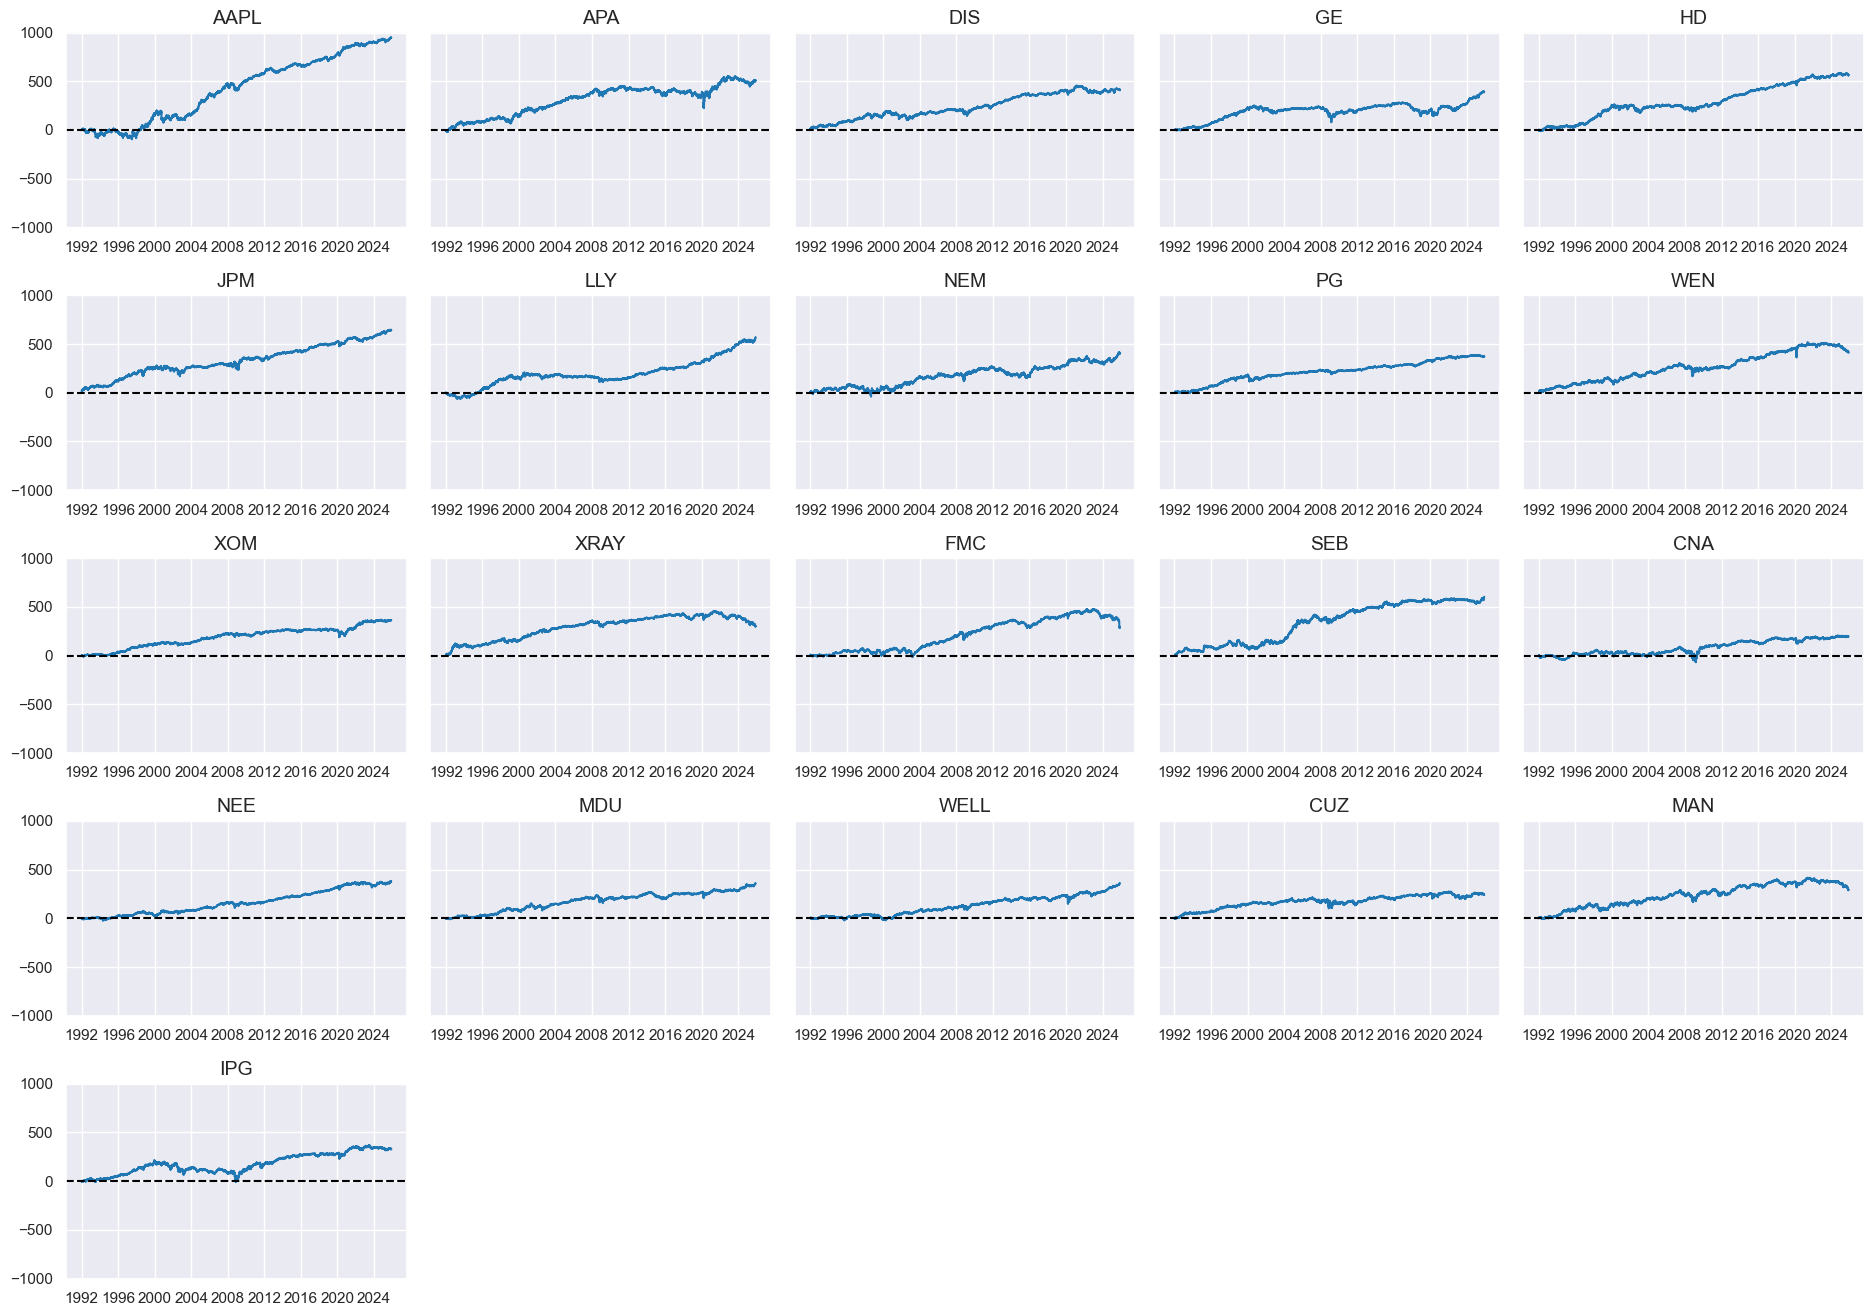

In [205]:
# --- visualization of stock returns ---
# ensure numeric
dfx = dfx.copy()
dfx["value"] = pd.to_numeric(dfx["value"], errors="coerce")

msp.view_timelines(
    df=dfx,
    xcats=["EQCR_NSA"],
    cids=cids_stocks,
    val="value",
    ncol=5,
    all_xticks=True,
    same_y=True,
    cumsum=True,
    start="1992-01-01",
    aspect=1.4,
    height=1.8,
)


In [207]:
# --- stock labels ---
stock_labels = {
    "AAPL": "Apple Inc.",
    "APA": "APA Corporation",
    "CNA": "CNA Financial Corporation",
    "CUZ": "Cousins Properties Inc.",
    "DIS": "The Walt Disney Company",
    "DXC": "DXC Technology Company",
    "FMC": "FMC Corporation",
    "GE": "General Electric Company",
    "HD": "The Home Depot, Inc.",
    "IPG": "Interpublic Group of Companies, Inc.",
    "JPM": "JPMorgan Chase & Co.",
    "LLY": "Eli Lilly and Company",
    "MAN": "ManpowerGroup Inc.",
    "MDU": "MDU Resources Group, Inc.",
    "NEE": "NextEra Energy, Inc.",
    "NEM": "Newmont Corporation",
    "PG": "The Procter & Gamble Company",
    "SEB": "Seaboard Corporation",
    "WELL": "Welltower Inc.",
    "WEN": "The Wendy’s Company",
    "XOM": "Exxon Mobil Corporation",
    "XRAY": "DENTSPLY SIRONA Inc.",
}

In [211]:
# --- importing russell 3000 for relative price benchmark ---

russell_df = pd.read_excel(
    "/Users/sadhana/Desktop/Incred/AMC Project - IGW/Data/Russell 3000 prices.xlsx"
)

russell_df["date"] = pd.to_datetime(russell_df["Observation_date"])
russell_df = russell_df.set_index("date").sort_index()

# --- Convert to qdf format ---
russell_long = (
    russell_df
    .rename(columns={"R3000": "value"})
    .assign(cid="R3000", xcat="Close")
    .reset_index()
    .rename(columns={"date": "real_date"})
)

russell_qdf = russell_long[["cid", "xcat", "real_date", "value"]]

# --- Add Russell 3000 Close to main panel ---
dfx = msm.update_df(dfx, russell_qdf)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [213]:
# --- Stocks present in prices_df ---
cids_stocks = prices_df.columns.tolist()

# Add benchmark cid explicitly
cids_ret = cids_stocks + ["R3000"]

calcs = ["EQCR_NSA = Close .pct_change(1) * 100"]

dfa_ret = msp.panel_calculator(
    dfx,
    calcs=calcs,
    cids=cids_ret,      # includes R3000
)

dfx = msm.update_df(dfx, dfa_ret)


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


In [217]:
cidx = cids_stocks   # only your 21 stocks

# Relative daily return vs Russell 3000
calcs = ["EQCR_NSAvALL = EQCR_NSA - iR3000_EQCR_NSA"]

dfa_rel = msp.panel_calculator(
    df=dfx,
    calcs=calcs,
    cids=cidx,
)

dfx = msm.update_df(dfx, dfa_rel)


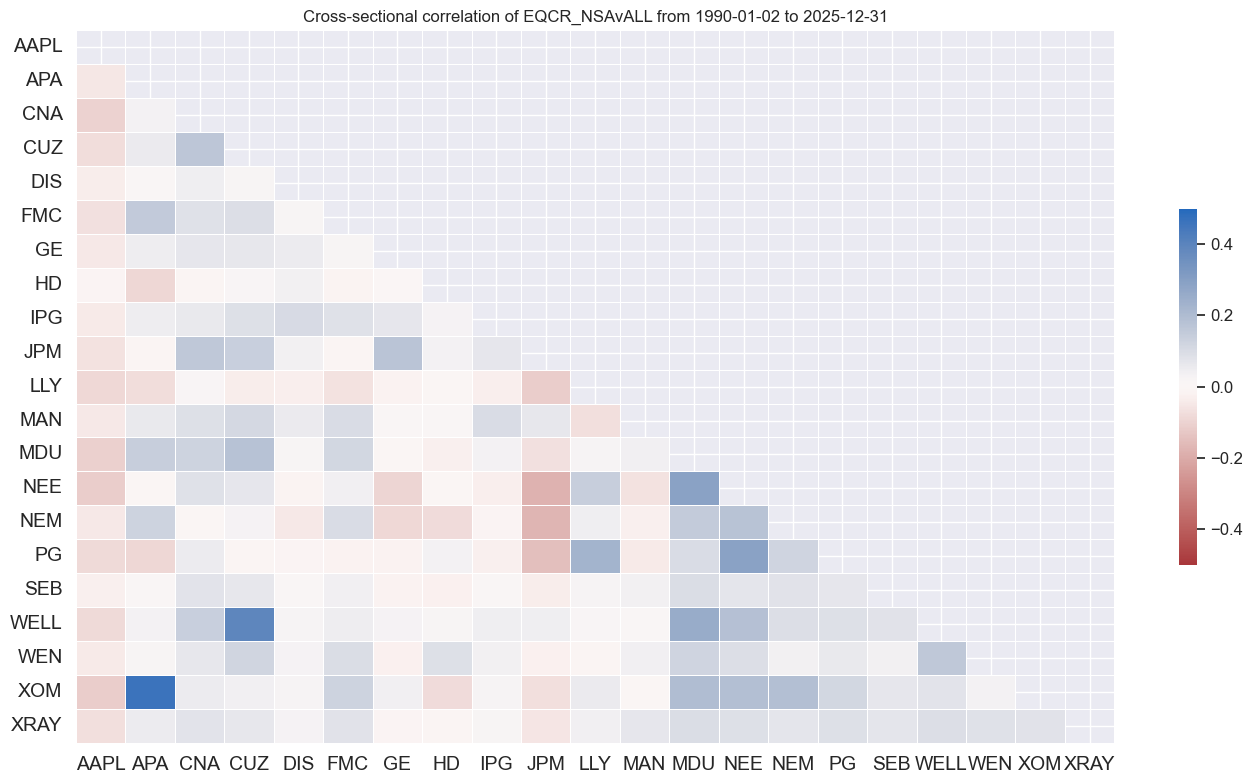

In [219]:
msp.correl_matrix(
    df=dfx,
    xcats=["EQCR_NSAvALL"],
    cids=cids_stocks,
    max_color=0.5,
)


In [221]:
# --- Historic volatility of relative returns ---

xcatx = ["EQCR_NSAvALL"]
cidx = cids_stocks

for xcat in xcatx:
    dfa = msp.historic_vol(
        dfx,
        xcat=xcat,
        cids=cidx,
        lback_meth="xma",   # exponential moving average
        postfix="_ASD",     # will create EQCR_NSAvALL_ASD
        est_freq="M",       # estimate at monthly frequency
    )
    dfx = msm.update_df(dfx, dfa)

In [223]:
# --- Volatility‑targeted (10%) relative returns ---

xcatx = ["EQCR_NSAvALL"]
cidx = cids_stocks

calcs = [
    f"{xcat}_VT10 = {xcat} * ( 10 / ( {xcat}_ASD .shift(1) ) )"
    for xcat in xcatx
]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

In [225]:
# --- Convert entire value column ---
dfx["value"] = pd.to_numeric(dfx["value"], errors="coerce")
print(dfx["value"].dtype)          # should now be float64


float64


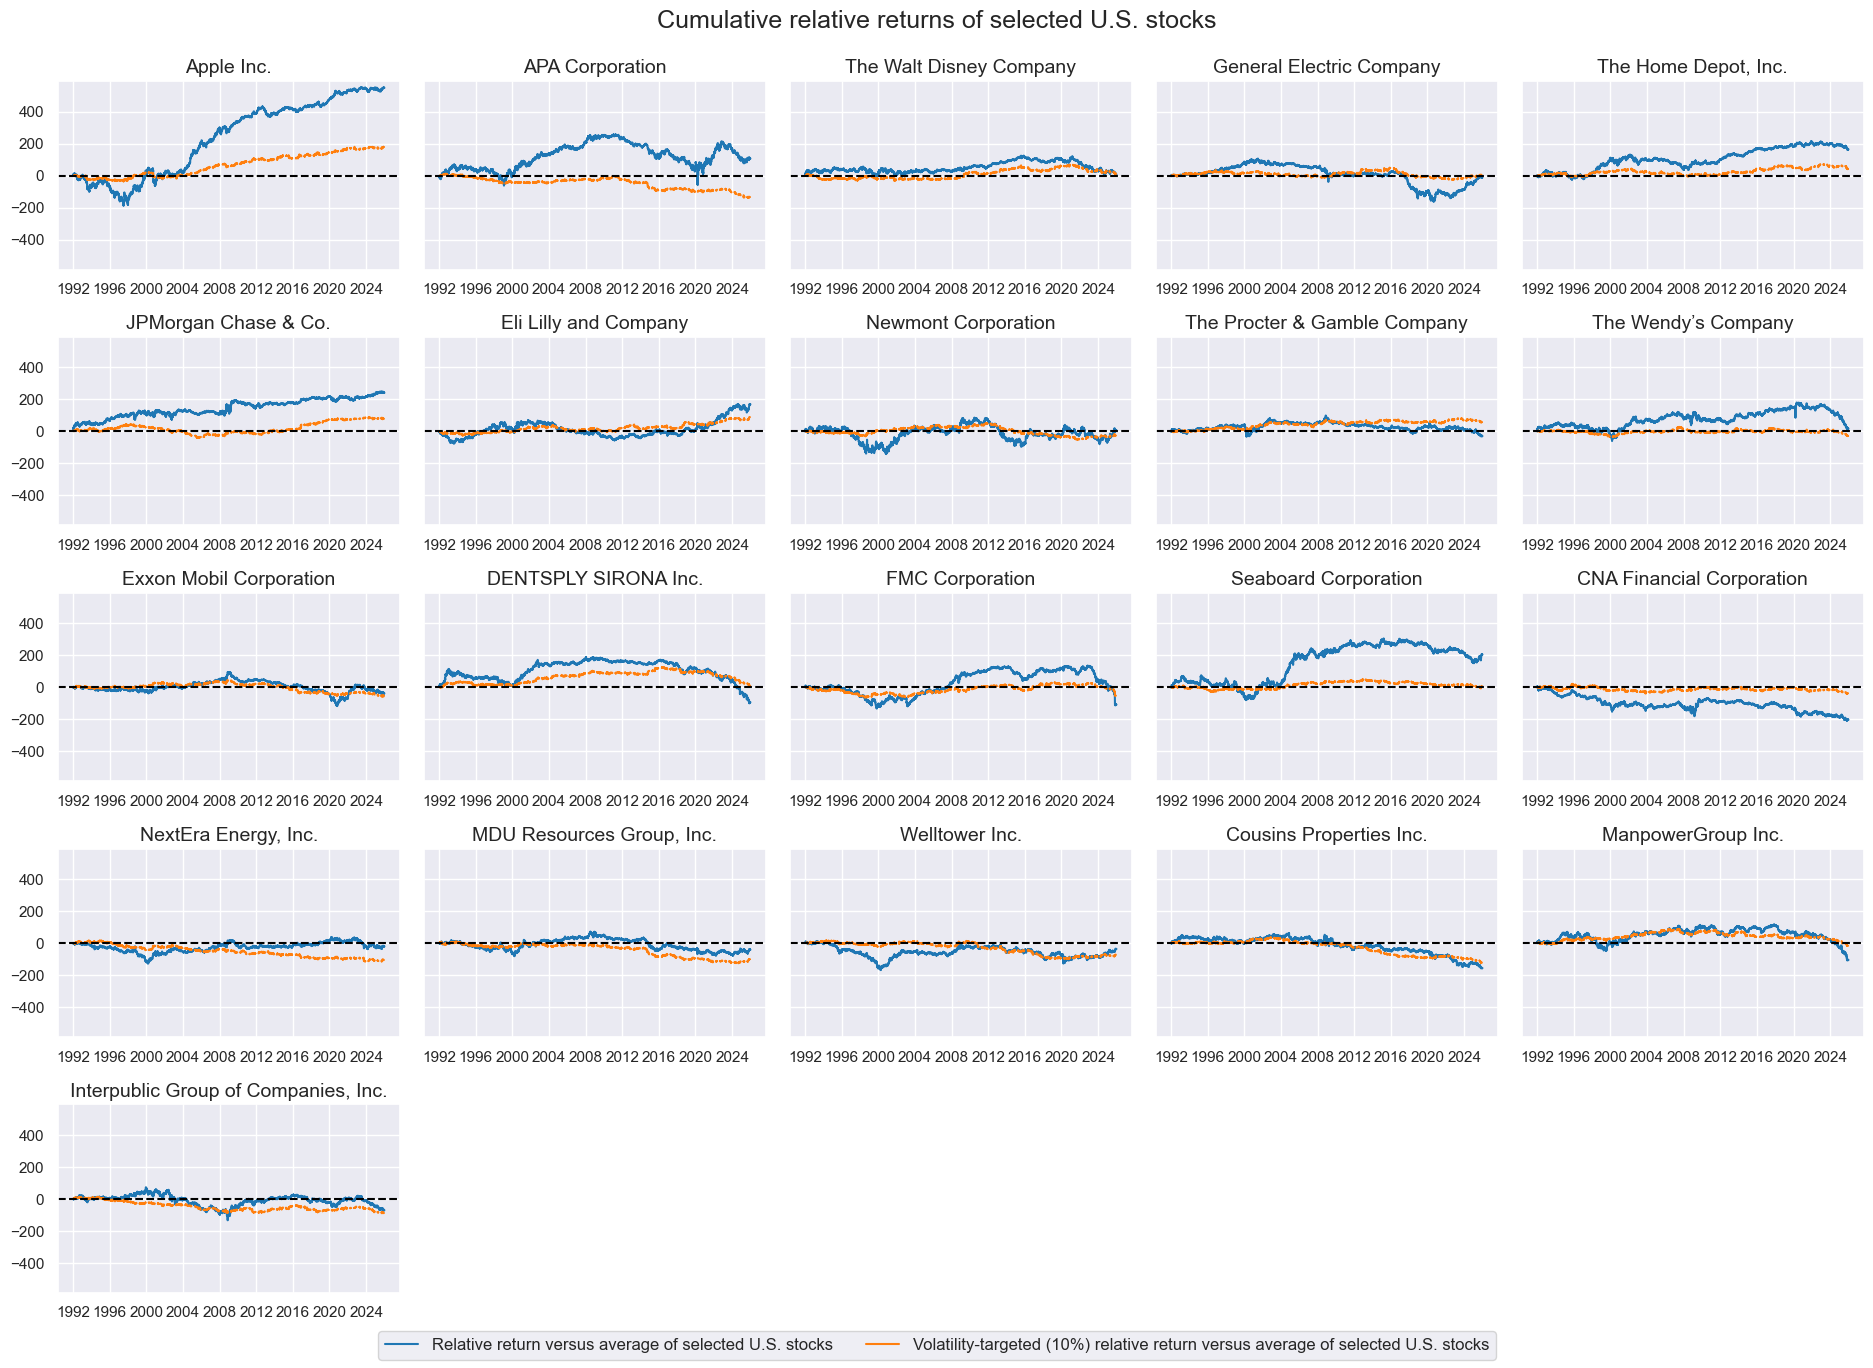

In [227]:
# --- Visual checkup of raw vs vol‑targeted relative returns ---

cidx = cids_stocks
xcatx = ["EQCR_NSAvALL", "EQCR_NSAvALL_VT10"]

vt_return_labels = {
    "EQCR_NSAvALL": "Relative return versus average of selected U.S. stocks",
    "EQCR_NSAvALL_VT10": "Volatility-targeted (10%) relative return versus average of selected U.S. stocks",
}

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=5,
    title="Cumulative relative returns of selected U.S. stocks",
    cid_labels=stock_labels,      # your mapping from tickers to nice labels
    xcat_labels=vt_return_labels, # human-readable legend labels
    all_xticks=True,
    same_y=True,
    cumsum=True,
    start="1990-01-01",
    aspect=1.4,
    height=1.8,
)


In [229]:
dfx

cid            xcat  real_date     value
0        AAPL           Close 1992-01-02  0.446287
1        AAPL           Close 1992-01-03  0.442356
2        AAPL           Close 1992-01-06  0.434883
3        AAPL           Close 1992-01-07  0.443241
4        AAPL           Close 1992-01-08  0.453445
...       ...             ...        ...       ...
1167673  XRAY  EQCR_NSAvR3000 2025-12-24 -0.311220
1167674  XRAY  EQCR_NSAvR3000 2025-12-26  0.043131
1167675  XRAY  EQCR_NSAvR3000 2025-12-29  0.373787
1167676  XRAY  EQCR_NSAvR3000 2025-12-30  0.170279
1167677  XRAY  EQCR_NSAvR3000 2025-12-31  0.749692

[1167678 rows x 4 columns]

In [231]:
return_type = "NSAvALL_VT10"
dfa = msm.reduce_df(
    df=dfx,
    xcats=[f"EQCR_{return_type}"],  # "EQCR_NSAvALL_VT10"
    cids=cids_stocks
).dropna()


In [233]:
return_type = "NSAvALL_VT10"
base_xcat   = f"EQCR_{return_type}"   # "EQCR_NSAvALL_VT10"

# --- Filter dfx manually for the base xcat and stock cids --- 
dfa = dfx[
    (dfx["xcat"] == base_xcat) &
    (dfx["cid"].isin(cids_stocks))
].dropna(subset=["value"])        

print("dfa shape:", dfa.shape)
print("dfa xcats:", dfa["xcat"].unique())
print("dfa cids:", sorted(dfa["cid"].unique()))



dfa shape: (78582, 4)
dfa xcats: ['EQCR_NSAvALL_VT10']
dfa cids: ['AAPL', 'APA', 'CNA', 'CUZ', 'DIS', 'FMC', 'GE', 'HD', 'IPG', 'JPM', 'LLY', 'MAN', 'MDU', 'NEE', 'NEM', 'PG', 'SEB', 'WELL', 'WEN', 'XOM', 'XRAY']


In [235]:
# --- Stock-specific xcats on common cid "USD" ---
dfa["xcat"] = dfa["cid"].apply(lambda x: f"EQC{x}R_{return_type}")
dfa["cid"]  = "USA"

# --- Append to main panel ---
dfx = msm.update_df(dfx, dfa)

dfa

cid                   xcat  real_date     value
36295    USA  EQCAAPLR_NSAvALL_VT10 1992-02-03  0.533948
36296    USA  EQCAAPLR_NSAvALL_VT10 1992-02-04 -0.423462
36297    USA  EQCAAPLR_NSAvALL_VT10 1992-02-05  0.142182
36298    USA  EQCAAPLR_NSAvALL_VT10 1992-02-06 -1.270857
36299    USA  EQCAAPLR_NSAvALL_VT10 1992-02-07  0.166795
...      ...                    ...        ...       ...
1158580  USA  EQCXRAYR_NSAvALL_VT10 2025-12-02 -0.114323
1158581  USA  EQCXRAYR_NSAvALL_VT10 2025-12-03 -0.230501
1158582  USA  EQCXRAYR_NSAvALL_VT10 2025-12-04 -0.081112
1158583  USA  EQCXRAYR_NSAvALL_VT10 2025-12-05 -0.091004
1158584  USA  EQCXRAYR_NSAvALL_VT10 2025-12-08  0.182165

[78582 rows x 4 columns]

In [237]:
# --- defining learning returns ---
learning_returns = sorted(
    dfa["xcat"].unique()
) 

In [239]:
dfx

cid            xcat  real_date     value
0        AAPL           Close 1992-01-02  0.446287
1        AAPL           Close 1992-01-03  0.442356
2        AAPL           Close 1992-01-06  0.434883
3        AAPL           Close 1992-01-07  0.443241
4        AAPL           Close 1992-01-08  0.453445
...       ...             ...        ...       ...
1246255  XRAY  EQCR_NSAvR3000 2025-12-24 -0.311220
1246256  XRAY  EQCR_NSAvR3000 2025-12-26  0.043131
1246257  XRAY  EQCR_NSAvR3000 2025-12-29  0.373787
1246258  XRAY  EQCR_NSAvR3000 2025-12-30  0.170279
1246259  XRAY  EQCR_NSAvR3000 2025-12-31  0.749692

[1246260 rows x 4 columns]

In [241]:
## Get packages

import os
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns

import macrosynergy.learning as msl
import macrosynergy.management as msm
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.panel as msp
import macrosynergy.visuals as msv
from macrosynergy.download import JPMaQSDownload, transform_to_qdf
from macrosynergy.panel.adjust_weights import adjust_weights

from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain

from timeit import default_timer as timer
from datetime import timedelta, date, datetime

import warnings

warnings.simplefilter("ignore")

In [243]:
# --- OLS: Signal optimization - monthly frequency ---
so_ols = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + learning_returns,
    cids=["USA"],
    n_targets=len(learning_returns),
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)


In [245]:
# --- OLS model predict ---
so_ols.calculate_predictions(
    name="OLS_SELECT",
    models={
        "OLS_SELECT": msl.LinearMultiTargetRegression(
            seemingly_unrelated=False,
            feature_selection=msl.KendallSignificanceSelector(),
        ),
    },
    hyperparameters={
        "OLS_SELECT": {
            "feature_selection__alpha": [0.01, 0.05, 0.1],
        },
    },
    scorers={"SORTINO": msl.multi_output_sortino},
    inner_splitters={"Rolling": msl.RollingKFoldPanelSplit(n_splits=5)},
    store_additional_data=["X_features", "fit_intercept", "coefs_"],
    cv_summary="mean",
    min_cids=1,
    min_periods=36,
    test_size=3,
)


  0%|          | 0/79 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [2.61895221 1.14830093        nan]
  warnings.warn(


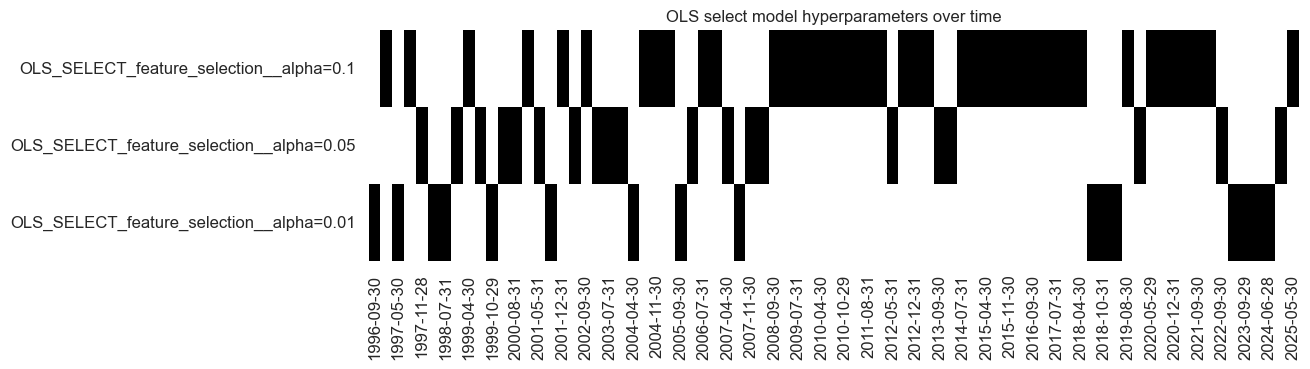

In [247]:
# --- OLS model visualization: Hyperparameters heatmap ---
so_ols.models_heatmap(
    "OLS_SELECT",
    figsize=(12, 3),
    title="OLS select model hyperparameters over time",
)

In [249]:
# --- store optimized signals from the optimizer ---
dfa = so_ols.get_optimized_signals()
dfaa = dfa.copy()
dfaa["cid"] = dfaa["xcat"].apply(
    lambda s: s[s.find("EQC") + 3 : s.find(f"R_{return_type}")]
)
dfaa["xcat"] = "OLS_SELECT"
dfx = msm.update_df(dfx, dfaa)

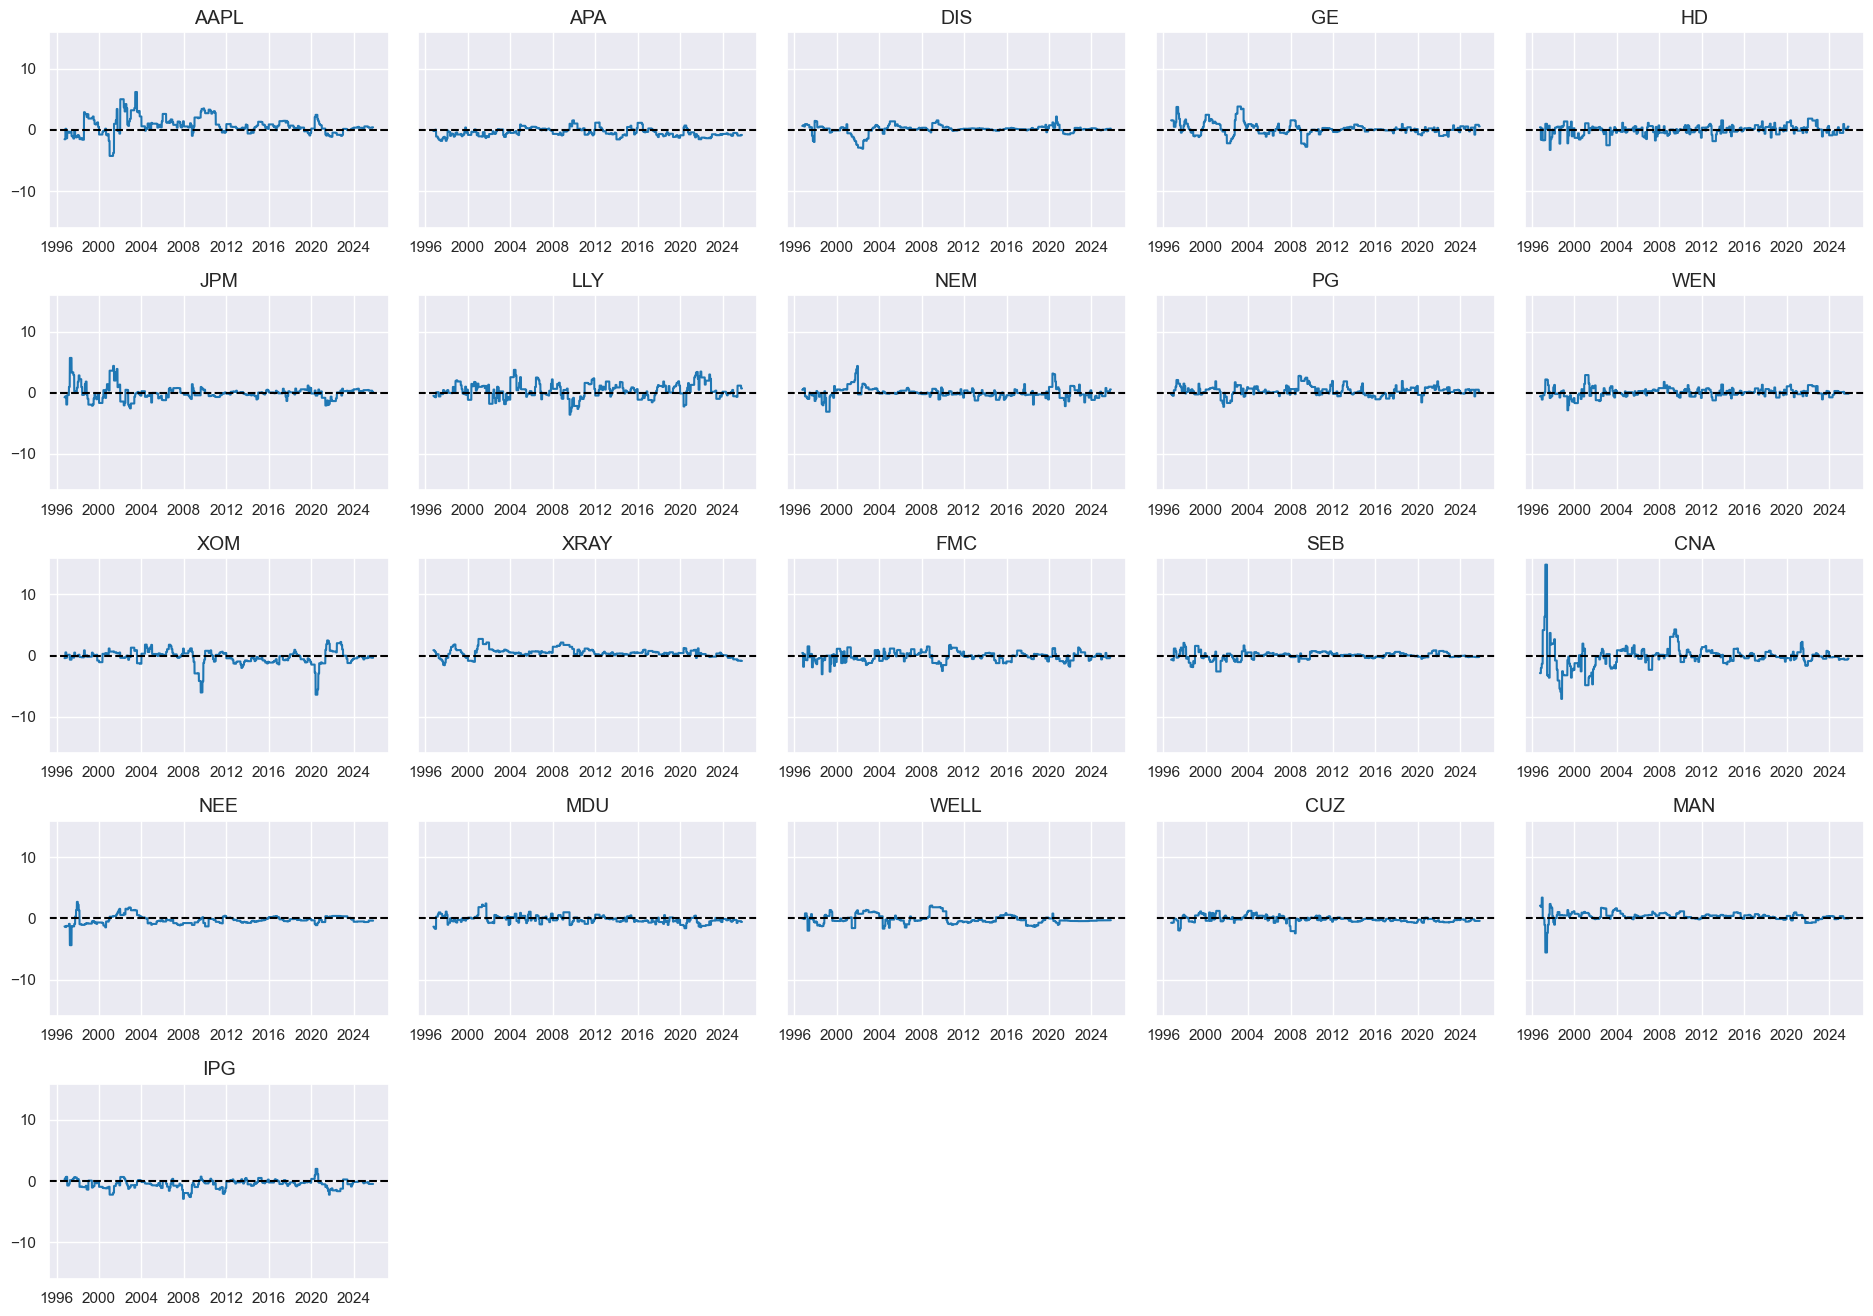

In [251]:
# --- visual checkup for OLS signals --- 
import macrosynergy.panel as msp
cidx  = cids_stocks          # or cids_usns, whichever you are using
xcatx = ["OLS_SELECT"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=5,
    all_xticks=True,
    same_y=True,
    cumsum=False,
    start="1990-01-01",
    aspect=1.4,
    height=1.8,
)

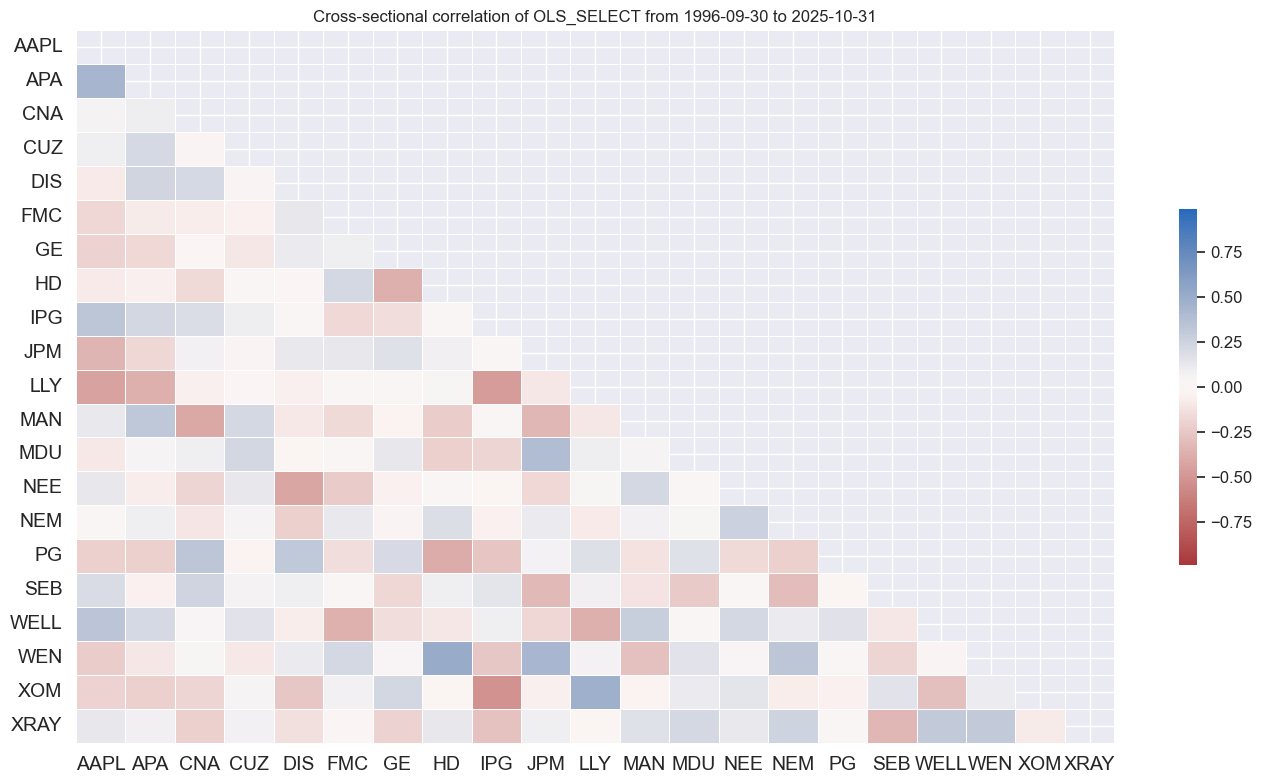

In [253]:
# --- correlation of selected signals ---
msp.correl_matrix(
    df=dfx, freq="M", xcats=["OLS_SELECT"], cids=cids_stocks, max_color=0.99, annot=False
)


#yet to do factor example for two stocks for OLS

In [255]:
# --- LASSO: Signal optimization - monthly frequency ---
so_las = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + learning_returns,
    cids=["USA"],
    n_targets=len(learning_returns),
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)


In [257]:
# --- LASSO model predict ---

so_las.calculate_predictions(
    name="LASSO",
    models={"LASSO": Lasso(random_state=42, fit_intercept=False)},
    hyperparameters={
        "LASSO": {
            "alpha": [0.5, 0.1, 0.05, 0.01],
        },
    },
    scorers={"SORTINO": msl.multi_output_sortino},
    inner_splitters={"Rolling": msl.RollingKFoldPanelSplit(n_splits=5)},
    cv_summary="mean",
    min_cids=1,
    min_periods=36,
    test_size=3,
)

  0%|          | 0/79 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e-01, tolerance: 5.647e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.257e-02, tolerance: 3.536e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.197e-01, toler

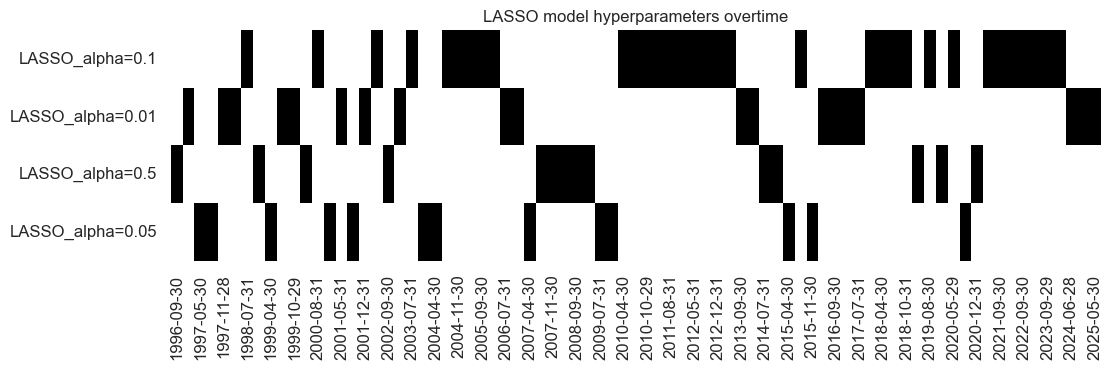

In [259]:
# --- LASSO model visualization: Hyperparameters heatmap ---
so_las.models_heatmap("LASSO", figsize=(12, 3), title="LASSO model hyperparameters overtime")
dfa = so_las.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [261]:
# --- store optimized signals from the optimizer ---
dfa = so_las.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)
dfaa = dfa.copy()
dfaa["cid"] = dfaa["xcat"].apply(
    lambda s: s[s.find("EQC") + 3 : s.find(f"R_{return_type}")]
)
dfaa["xcat"] = "LASSO"
dfx = msm.update_df(dfx, dfaa)

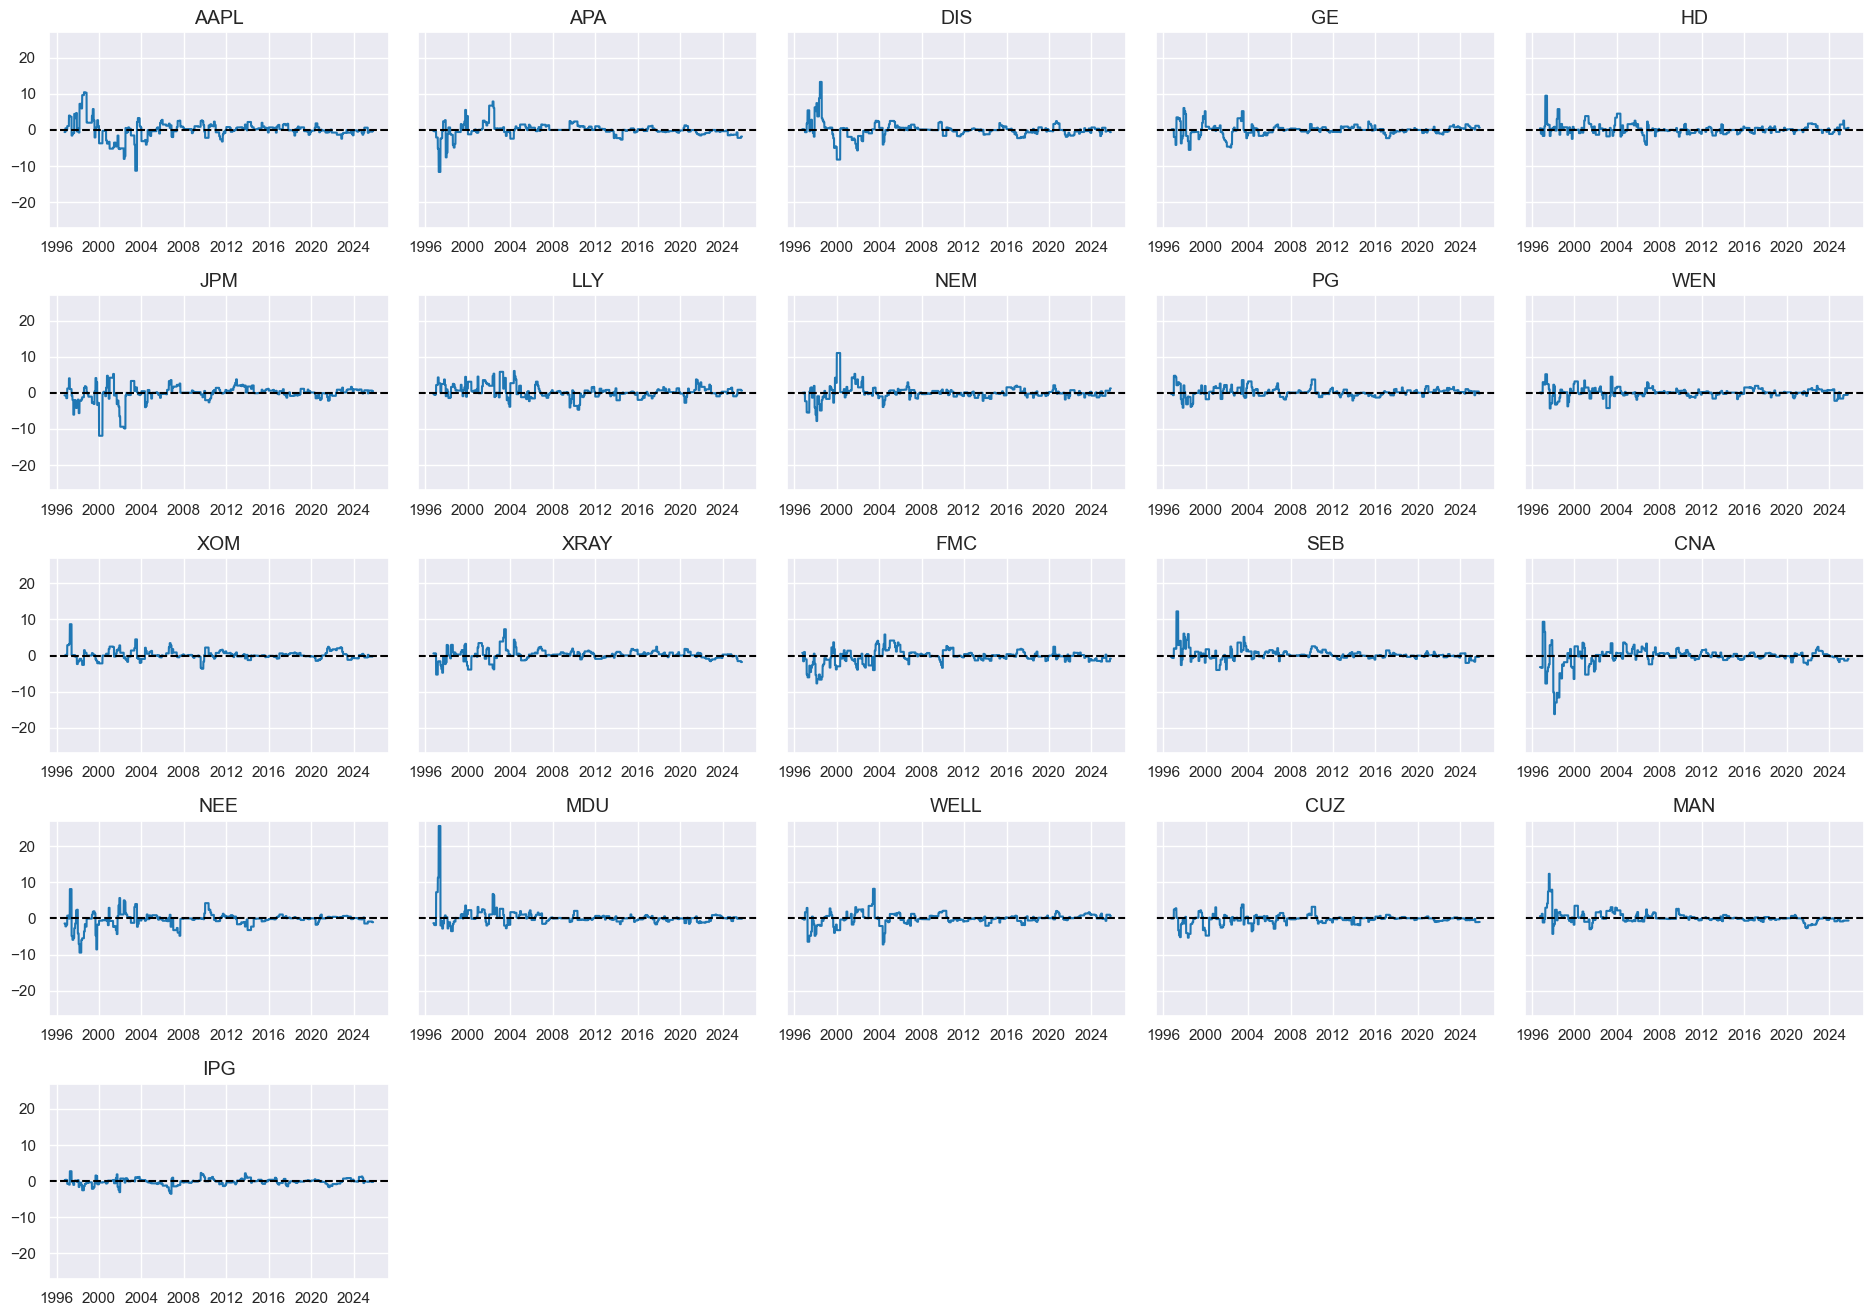

In [263]:
# --- visual check up for LASSO signals ---
cidx  = cids_stocks
xcatx = ["LASSO"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=5,
    all_xticks=True,
    same_y=True,
    cumsum=False,
    start="1990-01-01",
    aspect=1.4,
    height=1.8,
)

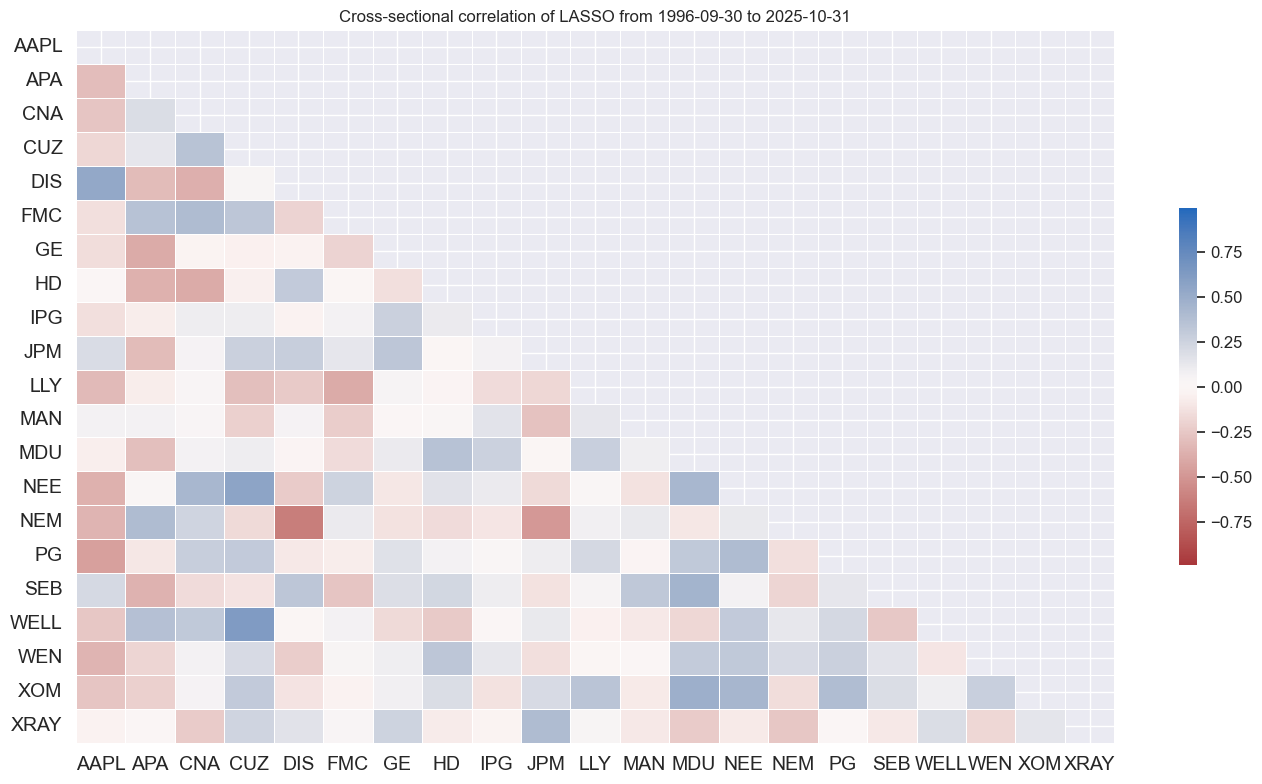

In [265]:
# --- correlation of selected signals ---
msp.correl_matrix(
    df=dfx,
    freq="M",
    xcats=["LASSO"],
    cids=cids_stocks,
    max_color=0.99,
    annot=False,
)


In [267]:
# Convert value to numeric and drop non-numeric rows
dfx["value"] = pd.to_numeric(dfx["value"], errors="coerce")
dfx = dfx.dropna(subset=["value"]).copy()

print(dfx["value"].dtype)  


float64


In [269]:
# --- SUR: Signal optimization - monthly frequency ---
so_sur = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + learning_returns,   # factors + per-stock learning returns
    cids=["USA"],                      
    n_targets=len(learning_returns),
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)

In [271]:
so_sur = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + learning_returns,
    cids=["USA"],
    n_targets=len(learning_returns),
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)

so_sur.calculate_predictions(
    name="SUR_SELECT",
    models={
        "SUR_SELECT": msl.LinearMultiTargetRegression(
            seemingly_unrelated=True,
            feature_selection=msl.KendallSignificanceSelector(),
        )
    },
    hyperparameters={
        "SUR_SELECT": {
            "span": [60, 36, 12],
            "feature_selection__alpha": [0.01, 0.05, 0.1],
        },
    },
    scorers={"SORTINO": msl.multi_output_sortino},
    inner_splitters={"Rolling": msl.RollingKFoldPanelSplit(n_splits=5)},
    cv_summary="mean",
    min_cids=1,
    min_periods=36,
    test_size=3,
)

  0%|          | 0/79 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [ 0.39384823  0.37372117         nan  1.31374096  1.33715652  0.91885266
  0.42326932  0.31619394 -0.16033193]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.64985912 0.74130345        nan 0.92531004 0.63552777 0.11446855
 0.45219525 0.31481391 0.34844092]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [ 0.73000599  0.50293418  0.66748731  0.45930667 -0.0544055   0.15015622
         nan         nan         nan]
  warnings.warn(


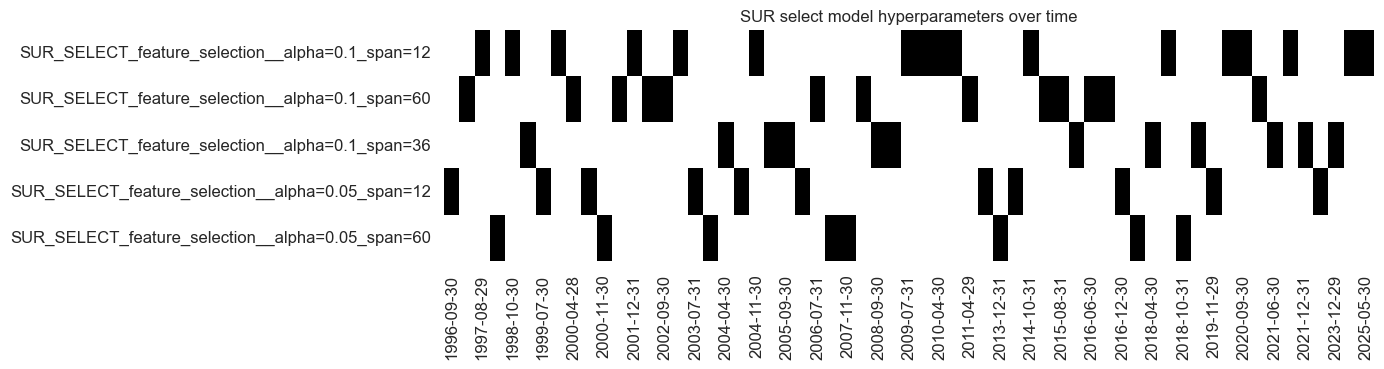

In [273]:
# --- SUR model visualization: Hyperparameters heatmap ---
so_sur.models_heatmap(
    "SUR_SELECT",
    figsize=(12, 3),
    title="SUR select model hyperparameters over time",
)

In [275]:
# --- store optimized signals from the optimizer ---
dfaa = dfa.copy()
dfaa["cid"] = dfaa["xcat"].apply(
    lambda s: s[s.find("EQC") + 3 : s.find(f"R_{return_type}")]
)
dfaa["xcat"] = "SUR_SELECT"

dfx = msm.update_df(dfx, dfaa)

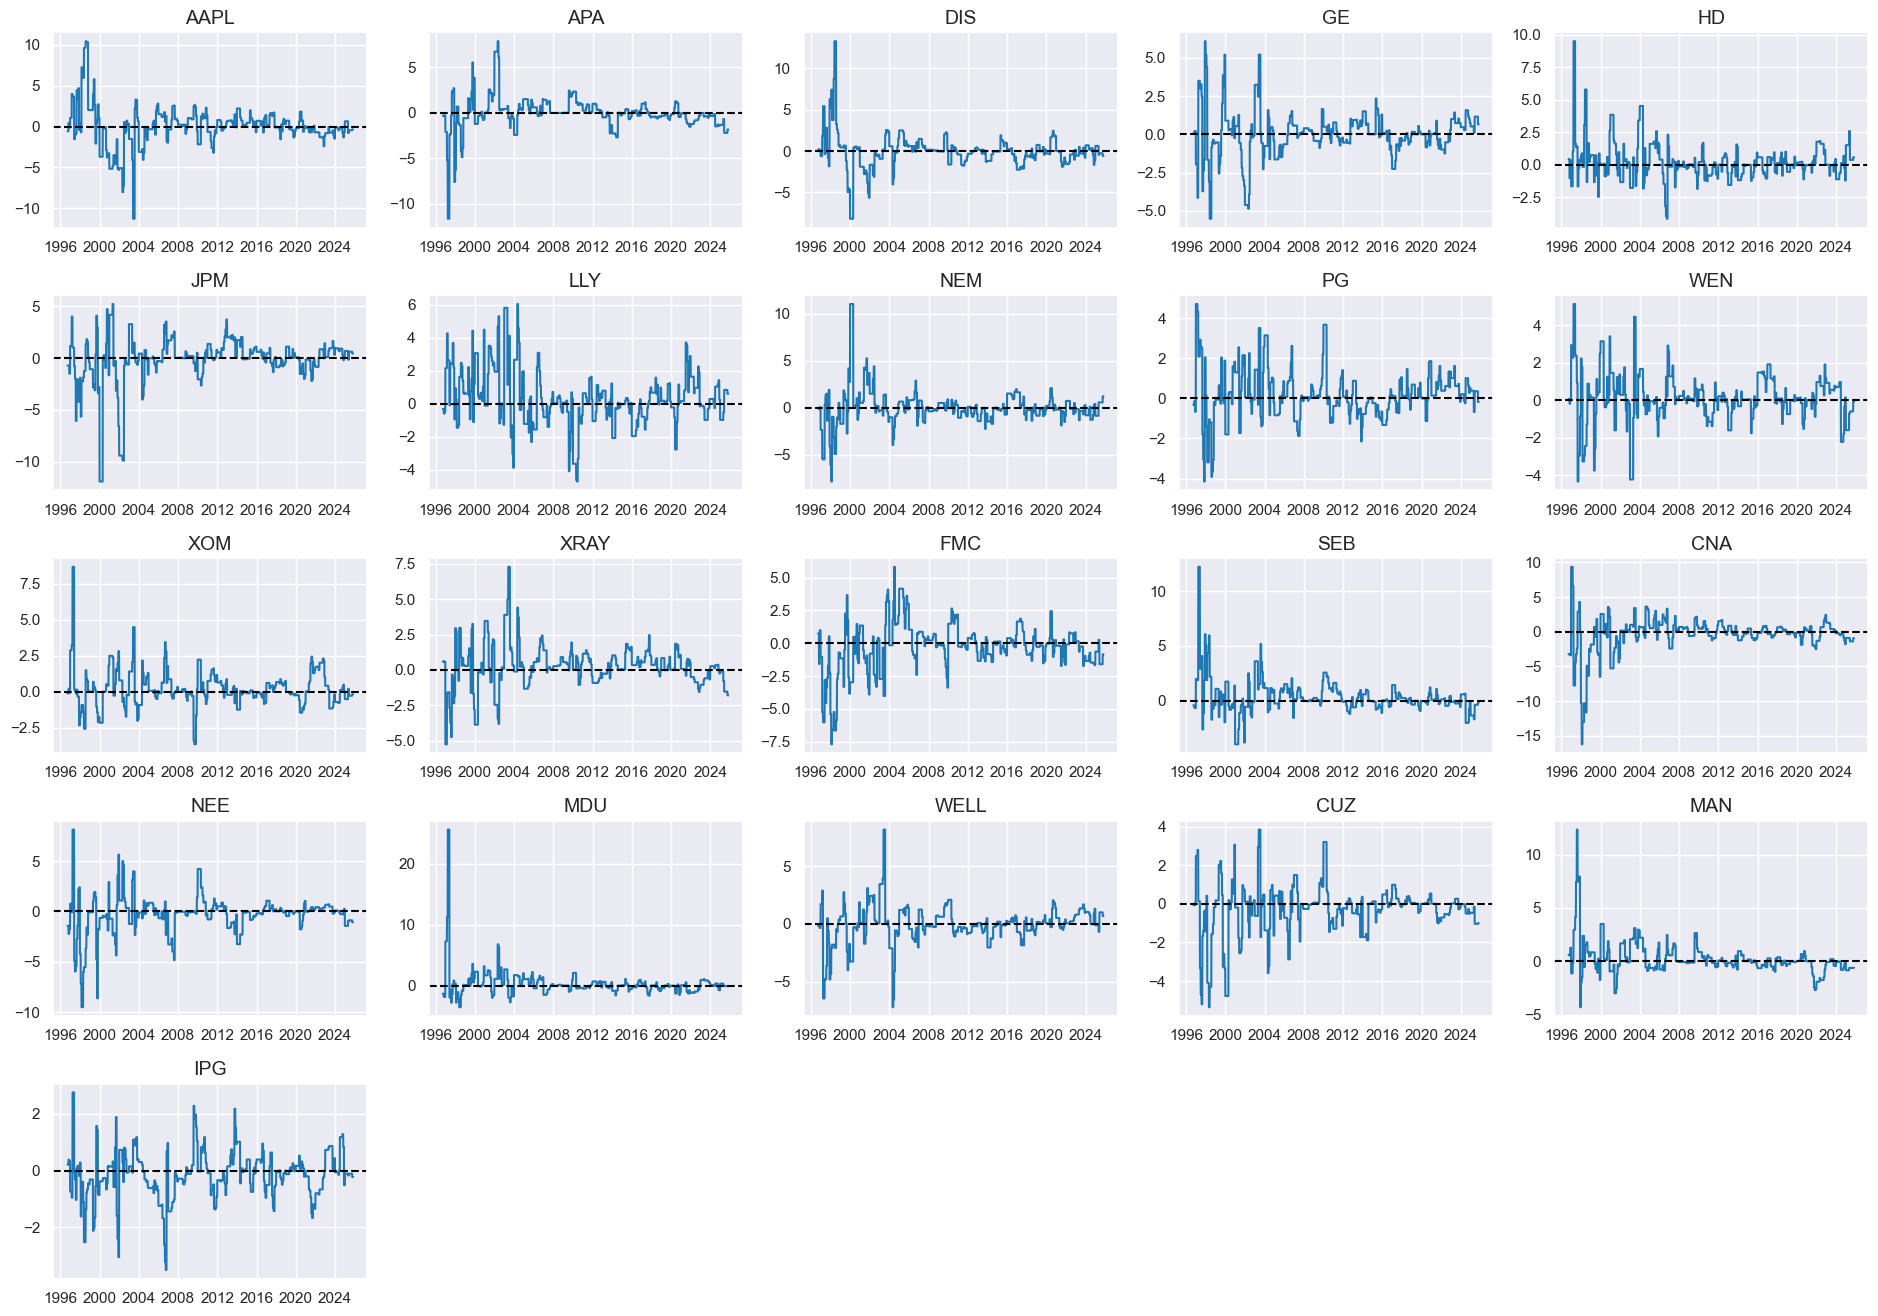

In [277]:
# --- visual check up for SUR signals 
cidx  = cids_stocks        # or cids_usns, your stock universe
xcatx = ["SUR_SELECT"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=5,
    all_xticks=True,
    same_y=False,          # allow stock-specific y‑scales
    cumsum=False,
    start="1990-01-01",
    aspect=1.4,
    height=1.8,
)

In [279]:
so_sur.get_optimal_models("SUR_SELECT")


real_date        name  model_type     score  \
0  1996-09-30  SUR_SELECT  SUR_SELECT  2.097104   
1  1996-12-31  SUR_SELECT  SUR_SELECT  0.730006   
2  1997-05-30  SUR_SELECT  SUR_SELECT  1.582238   
3  1997-08-29  SUR_SELECT  SUR_SELECT  0.892392   
4  1997-11-28  SUR_SELECT  SUR_SELECT  1.337157   
..        ...         ...         ...       ...   
74 2023-09-29  SUR_SELECT  SUR_SELECT  0.298463   
75 2023-12-29  SUR_SELECT  SUR_SELECT  0.293028   
76 2024-06-28  SUR_SELECT  SUR_SELECT  0.177500   
77 2024-11-29  SUR_SELECT  SUR_SELECT  0.185661   
78 2025-05-30  SUR_SELECT  SUR_SELECT  0.125006   

                                           hparams additional_data  \
0   {'feature_selection__alpha': 0.05, 'span': 12}              {}   
1   {'feature_selection__alpha': 0.01, 'span': 60}              {}   
2    {'feature_selection__alpha': 0.1, 'span': 60}              {}   
3    {'feature_selection__alpha': 0.1, 'span': 12}              {}   
4   {'feature_selection__alpha': 0.05, 'span': 36}              {}   
..                                             ...             ...   
74  {'feature_selection__alpha': 0.01, 'span': 60}              {}   
75   {'feature_selection__alpha': 0.1, 'span': 36}              {}   
76  {'feature_selection__alpha': 0.01, 'span': 60}              {}   
77   {'feature_selection__alpha': 0.1, 'span': 12}              {}   
78   {'feature_selection__alpha': 0.1, 'span': 12}              {}   

     n_splits_used  
0   {'Rolling': 5}  
1   {'Rolling': 5}  
2   {'Rolling': 5}  
3   {'Rolling': 5}  
4   {'Rolling': 5}  
..             ...  
74  {'Rolling': 5}  
75  {'Rolling': 5}  
76  {'Rolling': 5}  
77  {'Rolling': 5}  
78  {'Rolling': 5}  

[79 rows x 7 columns]

In [281]:
for x in ["OLS_SELECT", "LASSO", "SUR_SELECT"]:
    print(x, dfx[dfx["xcat"] == x]["value"].describe()[["mean", "std", "min", "max"]])


OLS_SELECT mean     0.024118
std      0.988485
min     -7.081655
max     14.859267
Name: value, dtype: float64
LASSO mean     0.032743
std      1.777736
min    -16.213337
max     25.567848
Name: value, dtype: float64
SUR_SELECT mean     0.032743
std      1.777736
min    -16.213337
max     25.567848
Name: value, dtype: float64


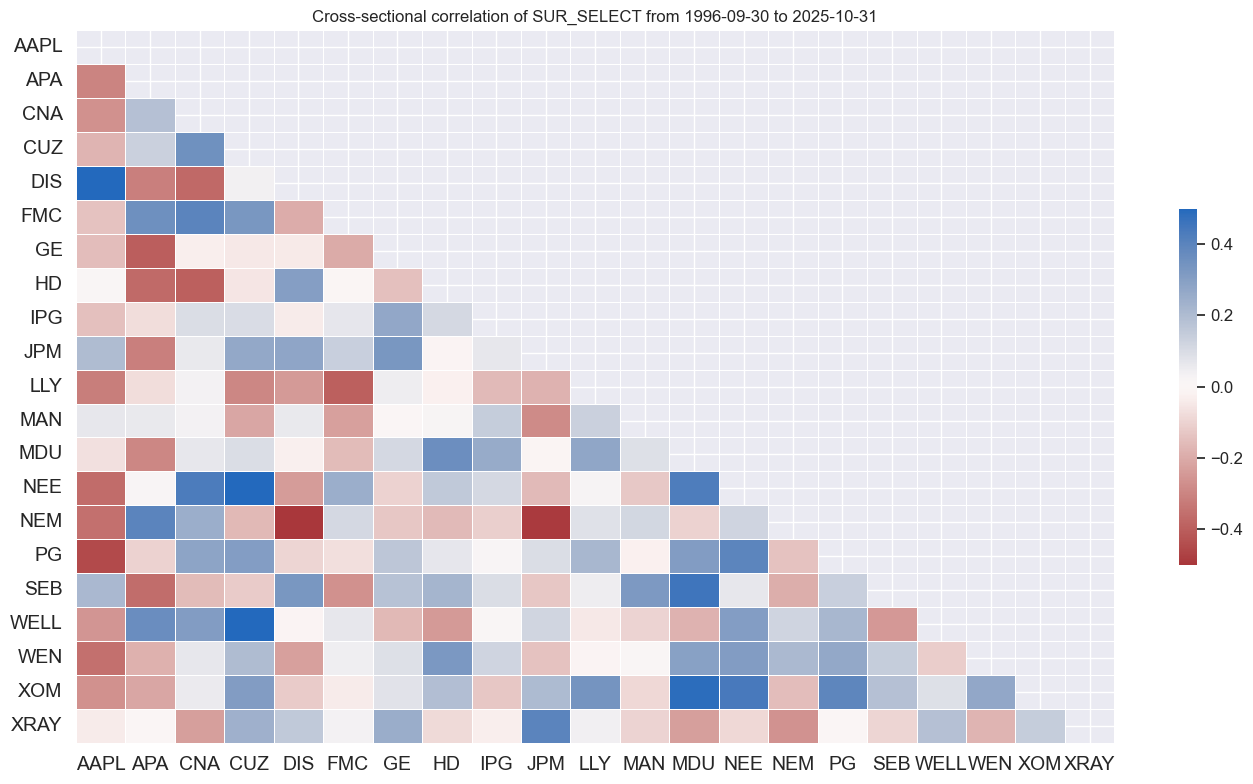

In [283]:
# --- correlation of selected signals ---
msp.correl_matrix(
    df=dfx,
    freq="M",
    xcats=["SUR_SELECT"],
    cids=cids_stocks,
    max_color=0.5,
    annot=False,
)


In [285]:
# --- Time weighted SUR: Signal optimization - monthly frequency ---
so_tw = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + learning_returns,
    cids=["USA"],
    n_targets=len(learning_returns),
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)


In [287]:
# --- Time weighted SUR model predict ---
so_tw.calculate_predictions(
    name="SUR_TW",
    models={
        "SUR_TW": msl.TimeWeightedWrapper(
            msl.LinearMultiTargetRegression(
                seemingly_unrelated=True,
                feature_selection=msl.KendallSignificanceSelector(alpha=0.1),
            ),
            half_life=60,   # default; overridden by hyperparameters grid
        )
    },
    hyperparameters={
        "SUR_TW": {
            "model__span": [60, 36, 12],                     # SUR covariance span
            "half_life": [60, 36, 12],                       # time‑weighting half‑life
            "model__feature_selection__alpha": [0.01, 0.05, 0.1],
        },
    },
    scorers={"SORTINO": msl.multi_output_sortino},
    inner_splitters={"Rolling": msl.RollingKFoldPanelSplit(n_splits=5)},
    cv_summary="mean",
    min_cids=1,
    min_periods=36,
    test_size=3,
)

  0%|          | 0/79 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.40447707 0.44013261 0.68934977 0.87116803 0.76936459 0.80301922
 0.64056484 0.87034444 1.02564786 0.59135399 0.58876705 0.56904652
 1.0162663  0.97782006 1.09300112 0.60716493 0.78904764 0.86079821
 2.05398574        nan 1.15631751 1.4254633  1.10329616 0.81584027
 0.53405012 0.78667548 0.45291991]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [        nan  0.31985328  1.59223541  0.8725564   0.86683905  0.47583429
  0.3769473   0.31066429 -0.1516255   0.24233706  0.2778949   0.3705066
  0.8343176   0.82831501  1.58723928  0.34068992  0.38239161 -0.10854008
  0.29667358  0.3621999   0.5400391   1.80209942  1.79990887  0.14839933
  0.39027681  0.24886171  0.08106124]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/

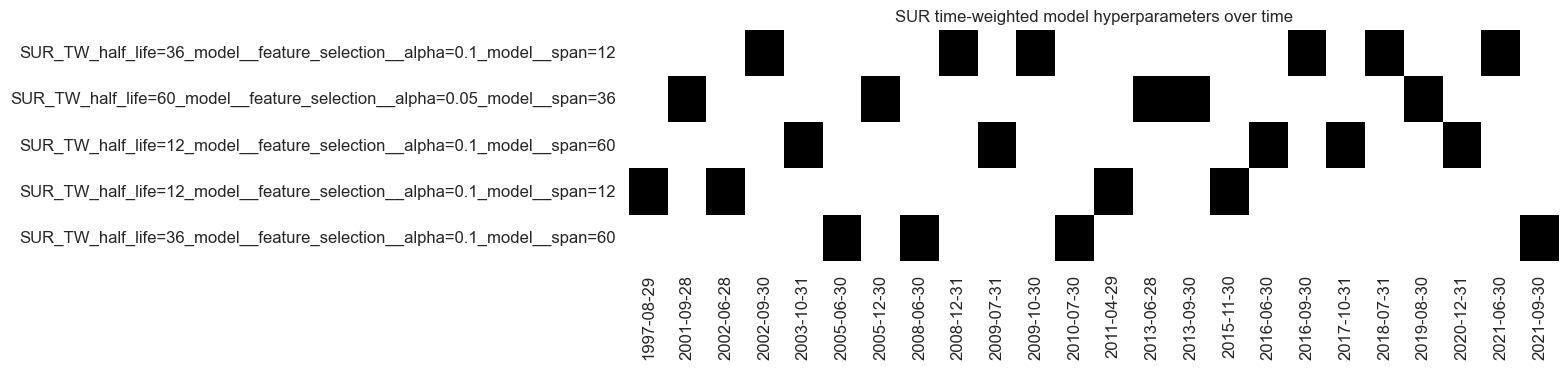

In [289]:
# --- Time weighted SUR model visualization: Hyperparameters heatmap ---
so_tw.models_heatmap(
    "SUR_TW",
    figsize=(12, 3),
    title="SUR time-weighted model hyperparameters over time",
)


In [291]:
# --- store optimized signals from the optimizer ---
dfa = so_tw.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)
dfaa = dfa.copy()
dfaa["cid"] = dfaa["xcat"].apply(
    lambda s: s[s.find("EQC") + 3 : s.find(f"R_{return_type}")]
)
dfaa["xcat"] = "SUR_TW"

dfx = msm.update_df(dfx, dfaa)

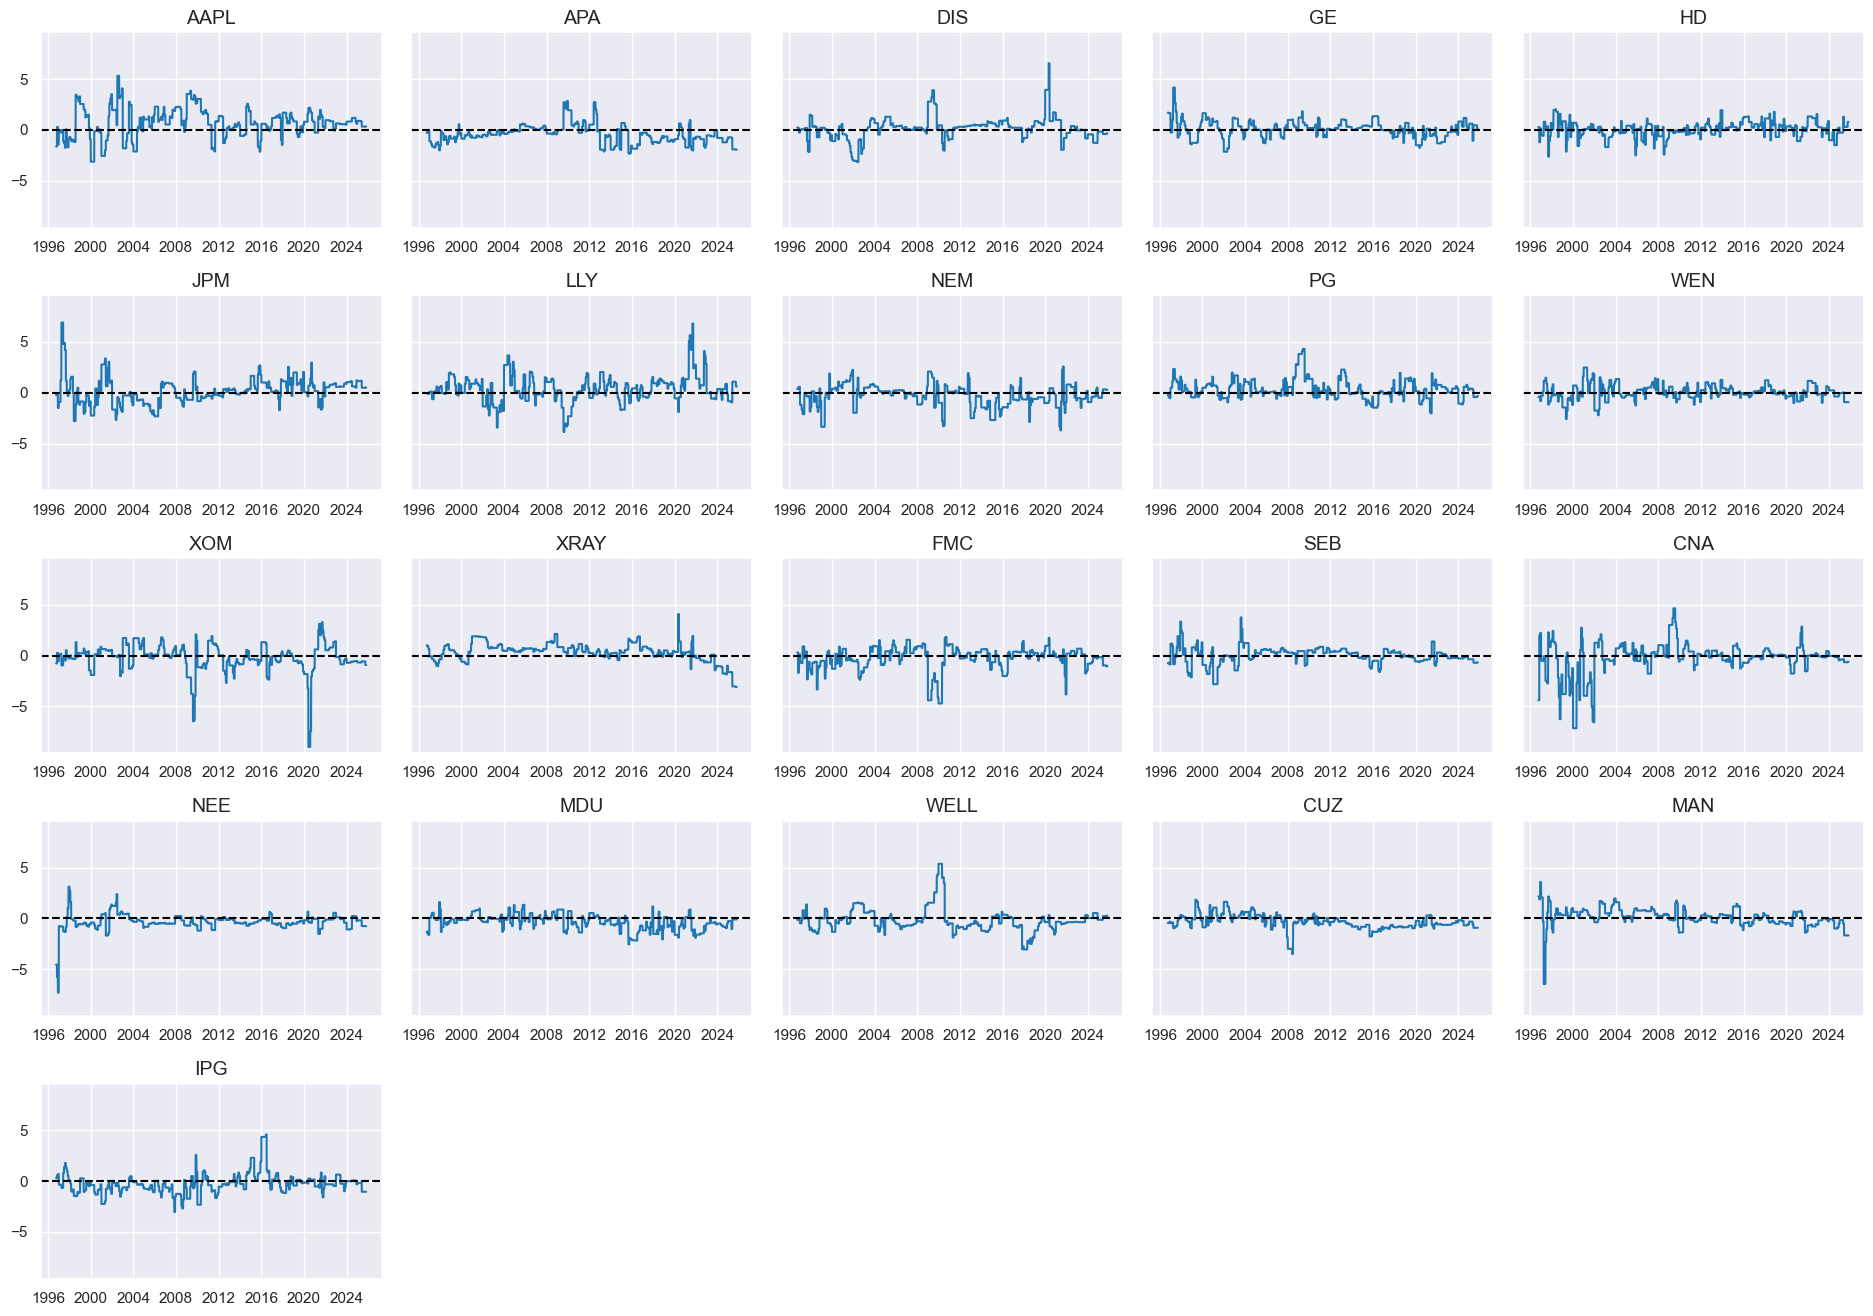

In [293]:
# --- visual check up for Time weighted SUR signals ---
cidx = cids_stocks
xcatx = ["SUR_TW"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=5,
    all_xticks=True,
    same_y=True,
    cumsum=False,
    start="1990-01-01",
    aspect=1.4,
    height=1.8,
)

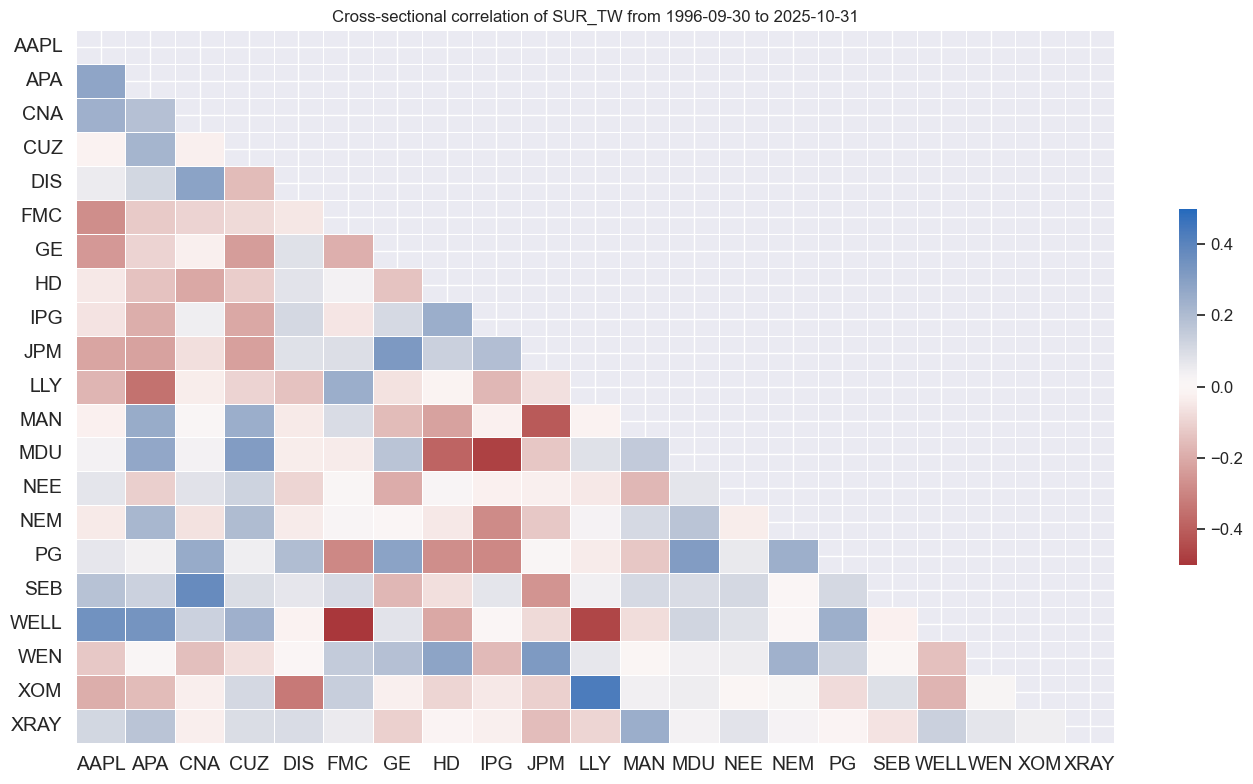

In [295]:
# --- correlation of selected signals ---
msp.correl_matrix(
    df=dfx, freq="M", xcats=["SUR_TW"], cids=cids_stocks, max_color=0.5, annot=False
)

In [297]:
# --- Random Forest: Signal optimization - monthly frequency ---
so_rf = msl.SignalOptimizer(
    df=dfx,
    xcats=factorz + learning_returns,   
    cids=["USA"],                       
    n_targets=len(learning_returns),
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)

In [299]:
# --- Random Forest model predict ---
so_rf.calculate_predictions(
    name="RC",
    models={
        "RF": RegressorChain(
            base_estimator=RandomForestRegressor(
                n_estimators=100,
                max_features=0.3,
                min_samples_leaf=5,
                ccp_alpha=1e-4,
                random_state=42,
            ),
            random_state=42,
        )
    },
    hyperparameters={
        "RF": {
            "base_estimator__min_samples_leaf": [5, 12],
        },
    },
    scorers={"SHARPE": msl.multi_output_sortino},   # Sortino-type scorer
    inner_splitters={"Rolling": msl.RollingKFoldPanelSplit(n_splits=5)},
    cv_summary="mean",
    min_cids=1,
    min_periods=36,
    test_size=3,
)

  0%|          | 0/79 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.62115002]
  warnings.warn(


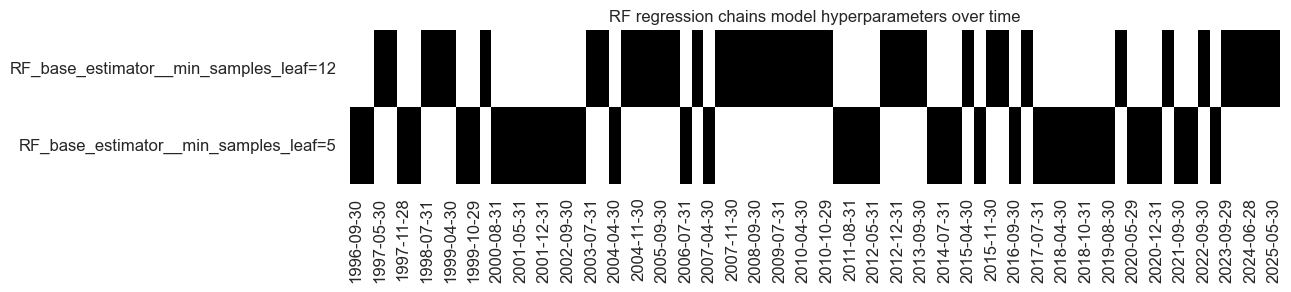

In [301]:
# --- Time weighted SUR model visualization: Hyperparameters heatmap ---
so_rf.models_heatmap(
    "RC",
    figsize=(12, 2),
    title="RF regression chains model hyperparameters over time",
)

In [303]:
# --- store optimized signals from the optimizer ---
dfa = so_rf.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)
dfaa = dfa.copy()
dfaa["cid"] = dfaa["xcat"].apply(
    lambda s: s[s.find("EQC") + 3 : s.find(f"R_{return_type}")]
)
dfaa["xcat"] = "RC"

dfx = msm.update_df(dfx, dfaa)

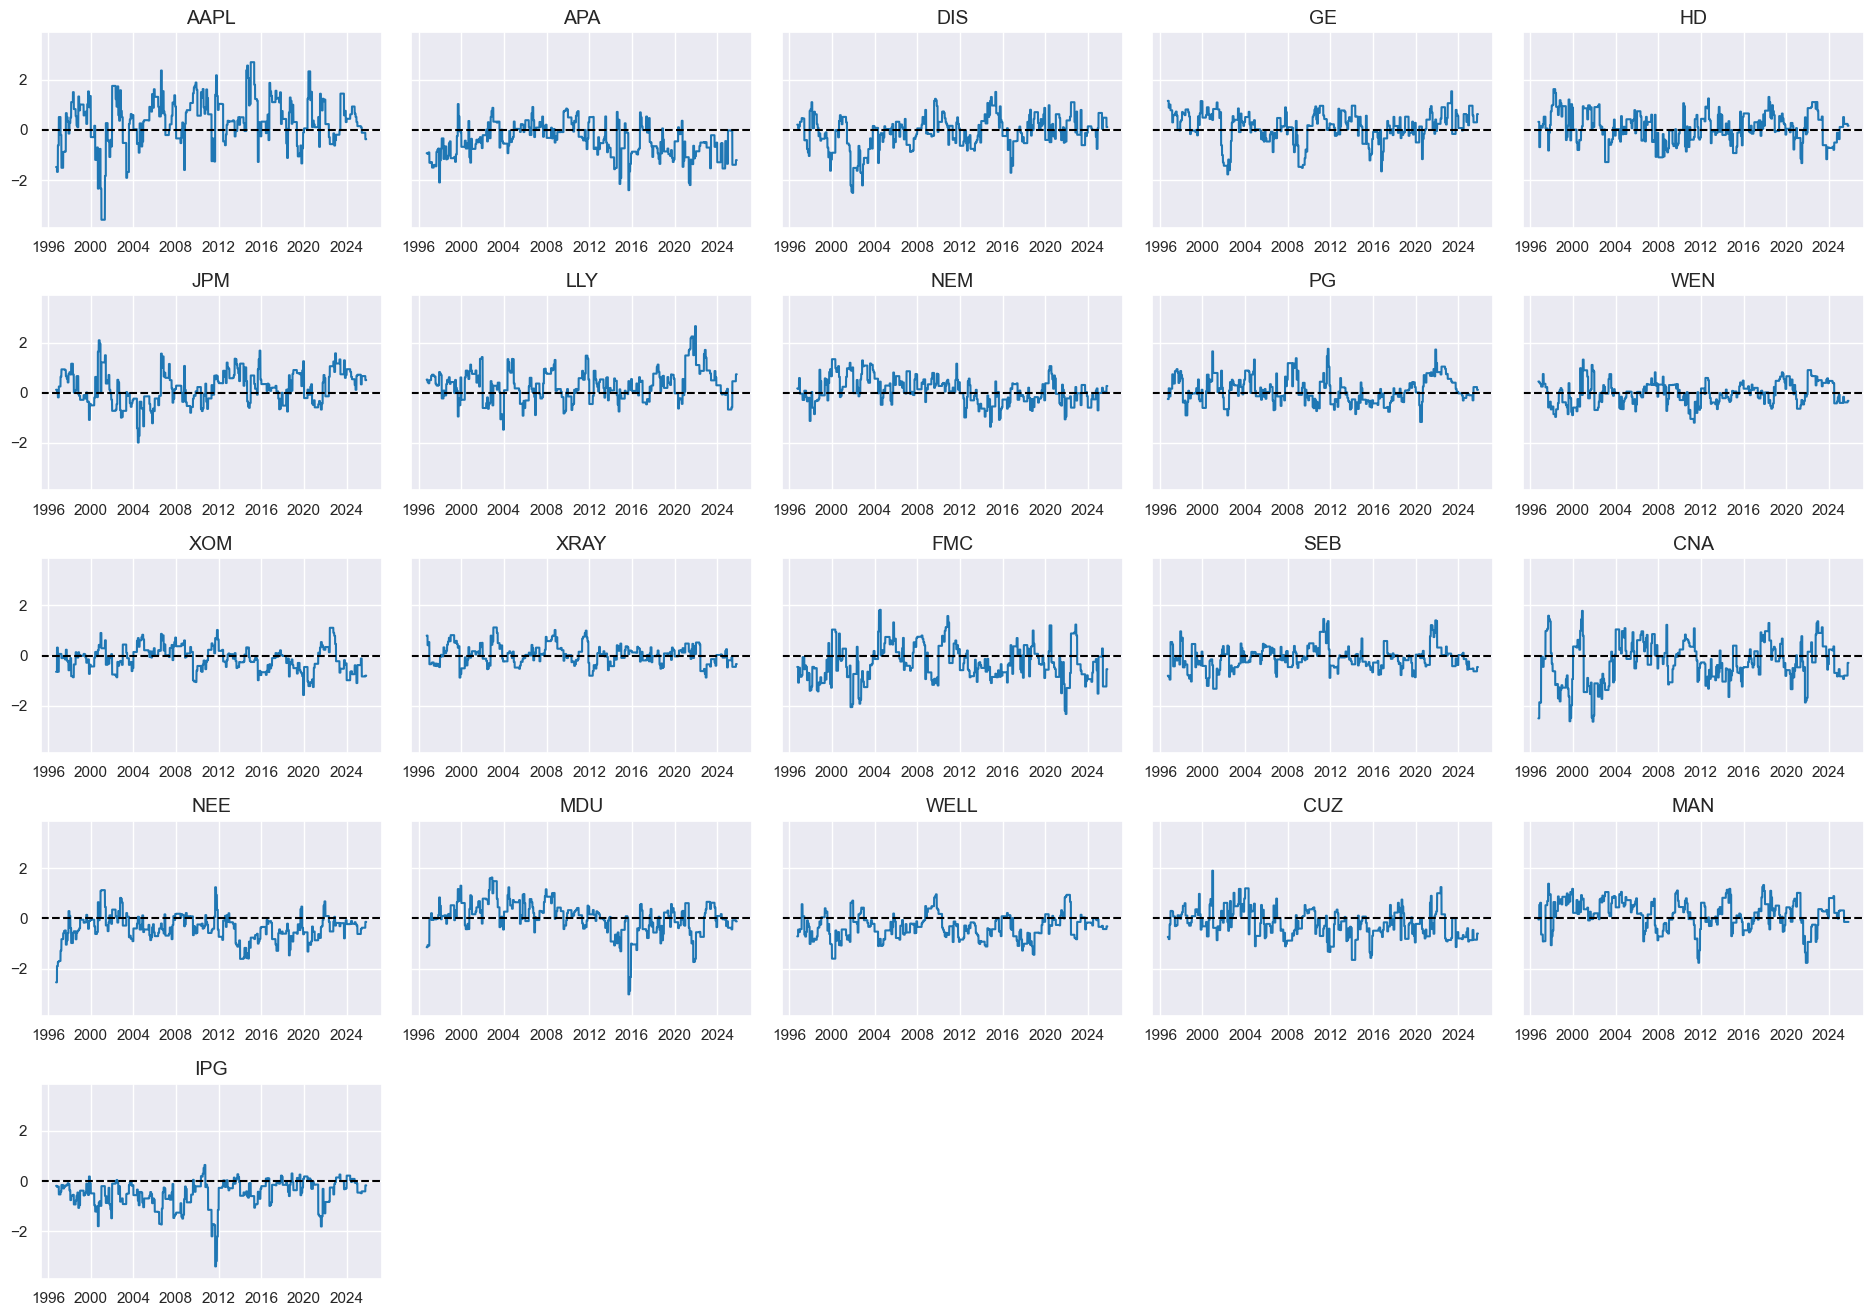

In [305]:
# --- visual check up for Random Forest signals ---
cidx = cids_stocks
xcatx = ["RC"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=5,
    all_xticks=True,
    same_y=True,
    cumsum=False,
    start="1990-01-01",
    aspect=1.4,
    height=1.8,
)

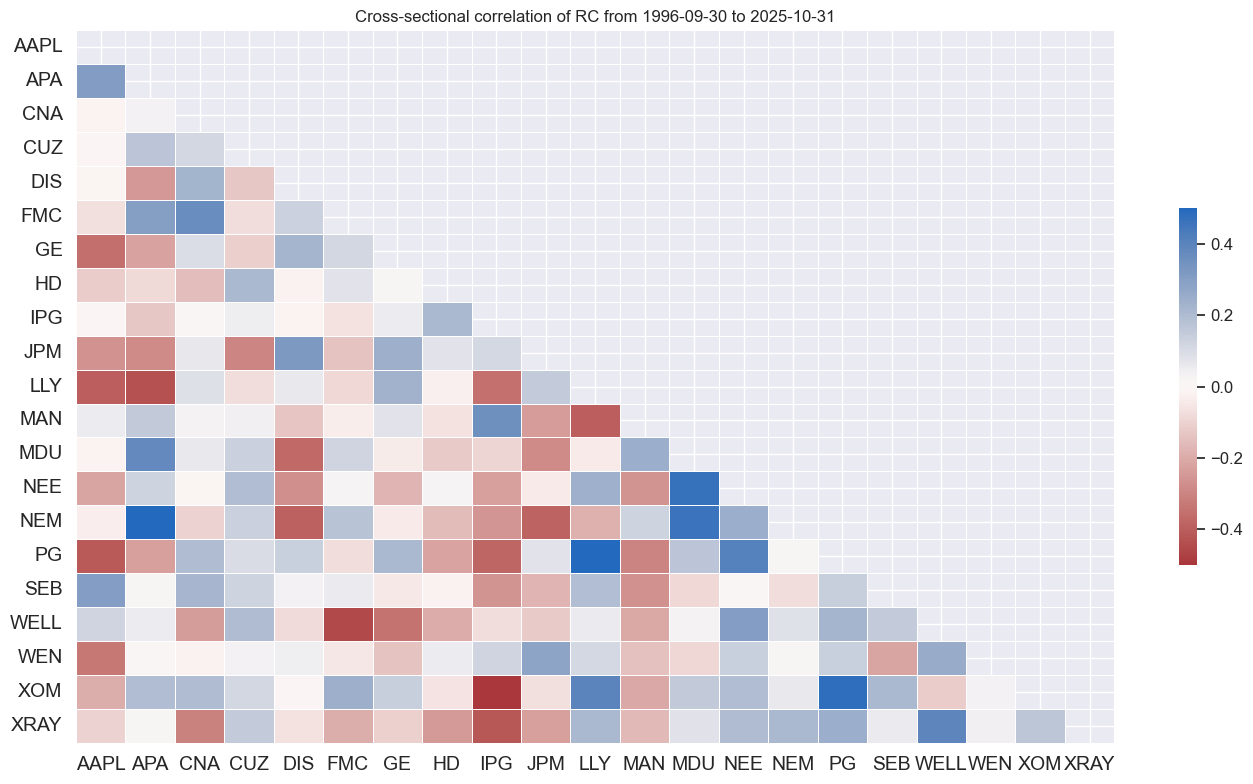

In [307]:
# --- correlation of selected signals ---
msp.correl_matrix(
    df=dfx, freq="M", xcats=["RC"], cids=cids_stocks, max_color=0.5, annot=False
)

In [309]:
# Normalize and winsorize signals
xcatx = ["OLS_SELECT", "LASSO", "SUR_SELECT", "SUR_TW", "RC"]
cidx = cids_stocks

for xcat in xcatx:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xcat,
        cids=cidx,
        sequential=True,
        min_obs=261 * 3,
        neutral="zero",
        pan_weight=1,
        thresh=3,
        postfix="_ZN",
        est_freq="m",
    )
    dfx = msm.update_df(dfx, dfa)

In [311]:
dict_sns = {
    "sigs": ["OLS_SELECT_ZN", "LASSO_ZN", "SUR_SELECT_ZN", "SUR_TW_ZN", "RC_ZN"],
    "targs": ["EQCR_NSAvALL"],
    "cidx": cids_stocks,
    "start": "1994-12-30",
    "crs": None,
    "srr": None,
    "pnls": None,
}

In [369]:
dix = dict_sns

sigs = dix["sigs"]
targs = dix["targs"]
cidx = dix["cidx"]
start = dix["start"]

# Initialize the dictionary to store CategoryRelations instances

dict_cr = {}

for targ in targs:
    for sig in sigs:
        lab = sig + "_" + targ
        dict_cr[lab] = msp.CategoryRelations(
            dfx,
            xcats=[sig, targ],
            cids=cidx,
            freq="M",
            lag=1,
            xcat_aggs=["last", "sum"],
            start=start,
            xcat_trims=(100, 100) # remove single dubious outlier
        )

dix["crs"] = dict_cr

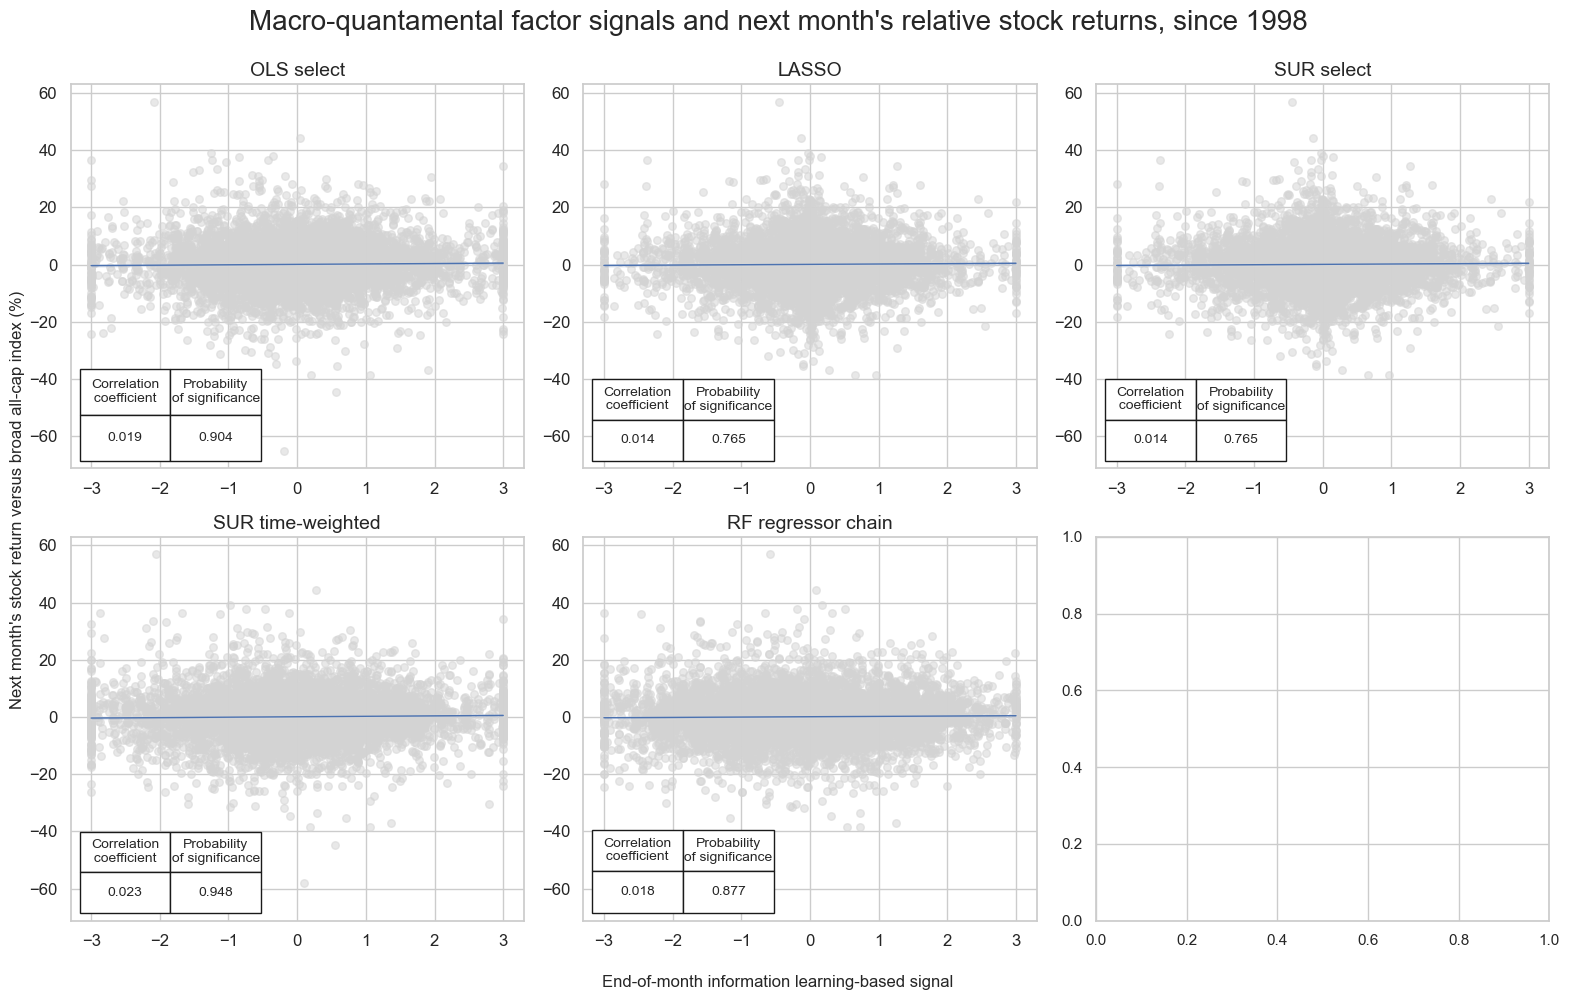

In [371]:
dix = dict_sns
dict_cr = dix["crs"]
sigs = dix["sigs"]
targs = dix["targs"]

scatter_labels = {
    "OLS_SELECT_ZN_EQCR_NSAvALL": "OLS select",
    "LASSO_ZN_EQCR_NSAvALL": "LASSO",
    "SUR_SELECT_ZN_EQCR_NSAvALL": "SUR select",
    "SUR_TW_ZN_EQCR_NSAvALL": "SUR time-weighted",
    "RC_ZN_EQCR_NSAvALL": "RF regressor chain",
}

crs = list(dict_cr.values())
crs_keys = list(dict_cr.keys())
ncol = 3
nrow = 2

msv.multiple_reg_scatter(
    cat_rels=crs,
    ncol=ncol,
    nrow=nrow,
    figsize=(16, 10),
    prob_est="pool",
    coef_box="lower left",
    # separator=2008,
    title="Macro-quantamental factor signals and next month's relative stock returns, since 1998",
    subplot_titles=[scatter_labels[cr] for cr in crs_keys],
    share_axes=False,
    xlab="End-of-month information learning-based signal",
    ylab="Next month's stock return versus broad all-cap index (%)",
    coef_box_font_size=10,
)


In [317]:
dix = dict_sns

sigs = dix["sigs"]
targs = dix["targs"]
cidx = dix["cidx"]
start = dix["start"]

# Initialize the dictionary to store CategoryRelations instances

dict_cr = {}

for targ in targs:
    for sig in sigs:
        lab = sig + "_" + targ
        dict_cr[lab] = msp.CategoryRelations(
            dfx,
            xcats=[sig, targ],
            cids=cidx,
            freq="Q",
            lag=1,
            xcat_aggs=["last", "sum"],
            start=start,
            xcat_trims=(100, 100) # remove single dubious outlier
        )

dix["crs_q"] = dict_cr

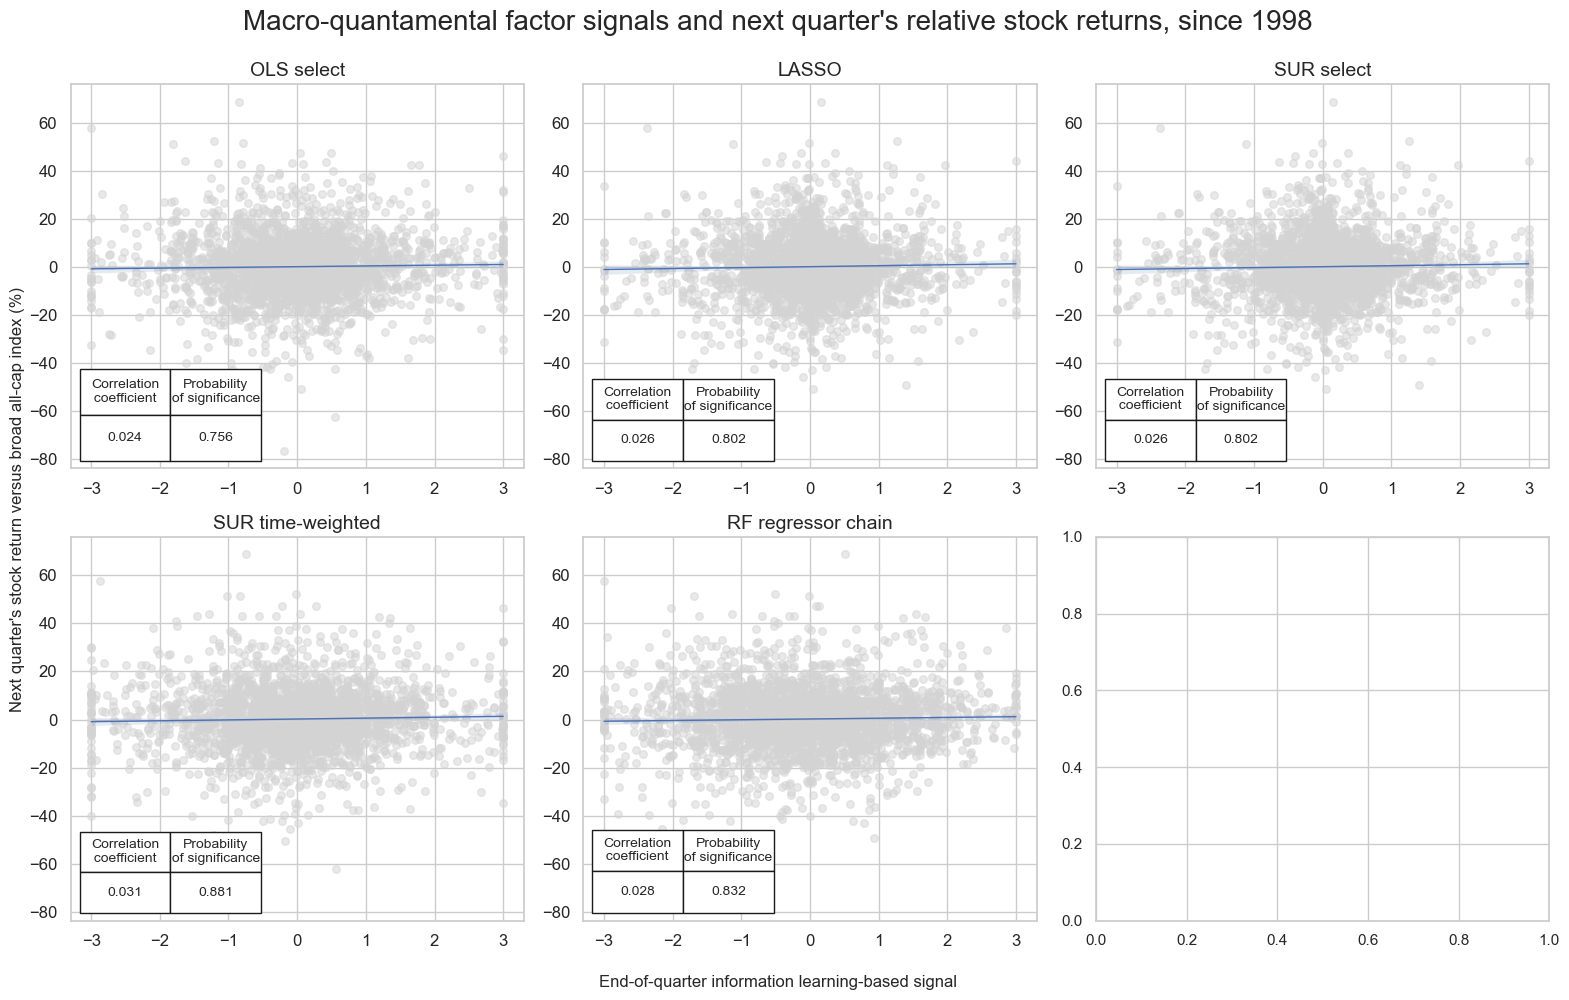

In [319]:
# Plotting panel scatters
dix = dict_sns
dict_cr = dix["crs_q"]
sigs = dix["sigs"]
targs = dix["targs"]

scatter_labels = {
    "OLS_SELECT_ZN_EQCR_NSAvALL": "OLS select",
    "LASSO_ZN_EQCR_NSAvALL": "LASSO",
    "SUR_SELECT_ZN_EQCR_NSAvALL": "SUR select",
    "SUR_TW_ZN_EQCR_NSAvALL": "SUR time-weighted",
    "RC_ZN_EQCR_NSAvALL": "RF regressor chain",
}

crs = list(dict_cr.values())
crs_keys = list(dict_cr.keys())
ncol = 3
nrow = 2

msv.multiple_reg_scatter(
    cat_rels=crs,
    ncol=ncol,
    nrow=nrow,
    figsize=(16, 10),
    prob_est="pool",
    coef_box="lower left",
    # separator=2008,
    title="Macro-quantamental factor signals and next quarter's relative stock returns, since 1998",
    subplot_titles=[scatter_labels[cr] for cr in crs_keys],
    share_axes=False,
    xlab="End-of-quarter information learning-based signal",
    ylab="Next quarter's stock return versus broad all-cap index (%)",
    coef_box_font_size=10,
)

In [321]:
# accuracy and correlation check 
dix = dict_sns

sigs = dix["sigs"]
targs = dix["targs"]
cidx = dix["cidx"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=sigs,
    rets=targs,
    freqs="M",
    start=start,
)

display(srr.multiple_relations_table().round(3).transpose())

dix["srr"] = srr

Return       EQCR_NSAvALL                                             
Signal           LASSO_ZN OLS_SELECT_ZN  RC_ZN SUR_SELECT_ZN SUR_TW_ZN
Frequency               M             M      M             M         M
Aggregation          last          last   last          last      last
accuracy            0.501         0.511  0.507         0.501     0.515
bal_accuracy        0.501         0.511  0.507         0.501     0.515
pos_sigr            0.502         0.507  0.464         0.502     0.486
pos_retr            0.498         0.497  0.497         0.498     0.497
pos_prec            0.499         0.508  0.504         0.499     0.512
neg_prec            0.503         0.514  0.509         0.503     0.517
pearson             0.013         0.019  0.018         0.013     0.022
pearson_pval        0.248         0.103  0.132         0.248     0.058
kendall             0.006         0.016  0.011         0.006     0.025
kendall_pval        0.449         0.045  0.144         0.449     0.001
auc                 0.501         0.511  0.506         0.501     0.515

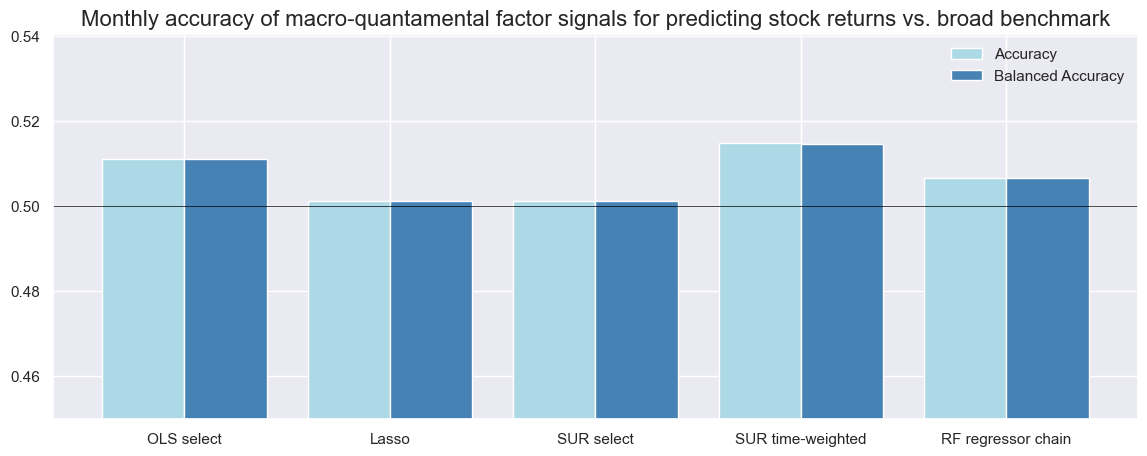

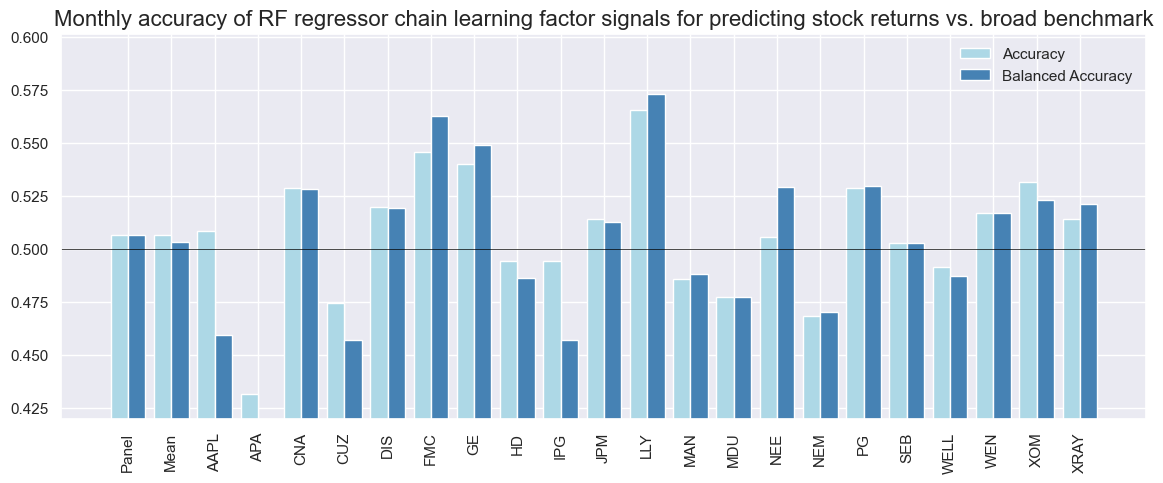

In [323]:
dix = dict_sns
srr = dix["srr"]

signal_labels = {
    "OLS_SELECT_ZN": "OLS select",
    "LASSO_ZN": "Lasso",
    "SUR_SELECT_ZN": "SUR select",
    "SUR_TW_ZN": "SUR time-weighted",
    "RC_ZN": "RF regressor chain",
}

srr.accuracy_bars(
    type="signals",
    ret="EQCR_NSAvALL",
    size=(14, 5),
    title="Monthly accuracy of macro-quantamental factor signals for predicting stock returns vs. broad benchmark",
    x_labels=signal_labels,
    title_fontsize=16,
)

srr.accuracy_bars(
    type="cross_section",
    ret="EQCR_NSAvALL",
    sigs="RC_ZN",
    size=(14, 5),
    title="Monthly accuracy of RF regressor chain learning factor signals for predicting stock returns vs. broad benchmark",
    x_labels=stock_labels,
    x_labels_rotate=90,
    title_fontsize=16,
)

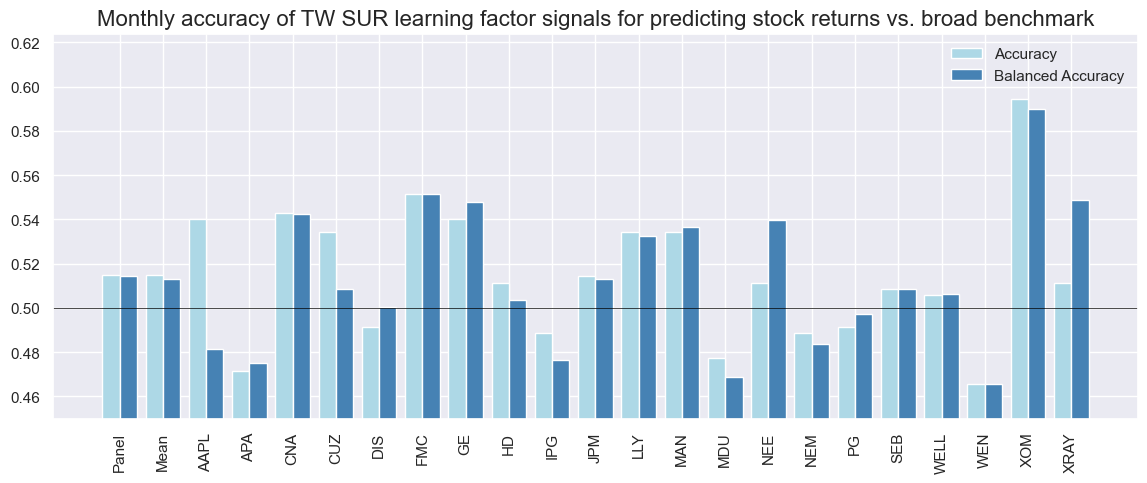

In [379]:
srr.accuracy_bars(
    type="cross_section",
    ret="EQCR_NSAvALL",
    sigs="SUR_TW_ZN",
    size=(14, 5),
    title="Monthly accuracy of TW SUR learning factor signals for predicting stock returns vs. broad benchmark",
    x_labels=stock_labels,
    x_labels_rotate=90,
    title_fontsize=16,
)

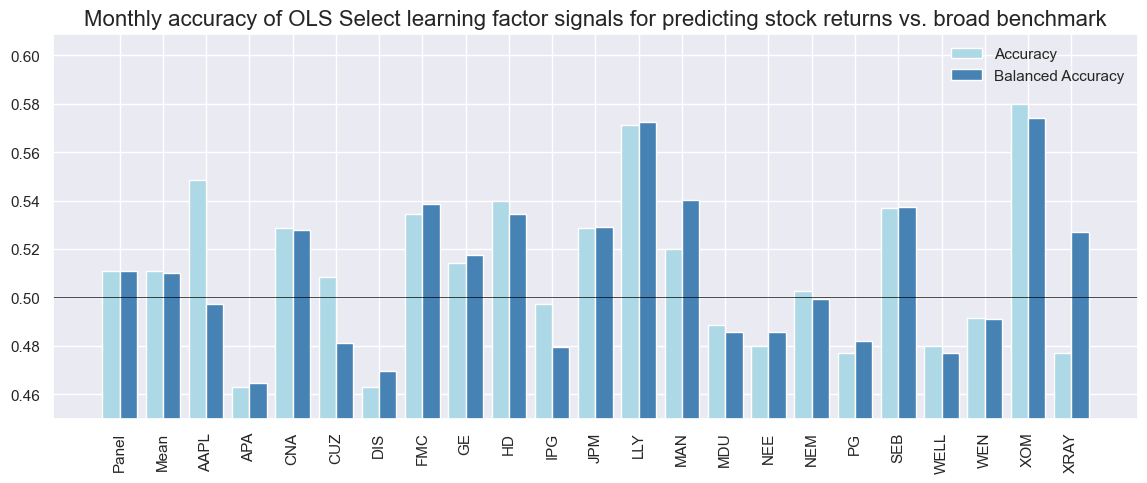

In [383]:
srr.accuracy_bars(
    type="cross_section",
    ret="EQCR_NSAvALL",
    sigs="OLS_SELECT_ZN",
    size=(14, 5),
    title="Monthly accuracy of OLS Select learning factor signals for predicting stock returns vs. broad benchmark",
    x_labels=stock_labels,
    x_labels_rotate=90,
    title_fontsize=16,
)

In [381]:
srr = dix["srr"]
display(srr.cross_section_table().round(2))


accuracy  bal_accuracy  pos_sigr  \
M: OLS_SELECT_ZN/last => EQCR_NSAvALL      0.51          0.51      0.51   
Mean                                       0.51          0.51      0.51   
PosRatio                                   0.57          0.48      0.48   
AAPL                                       0.55          0.50      0.75   
APA                                        0.46          0.46      0.27   
CNA                                        0.53          0.53      0.44   
CUZ                                        0.51          0.48      0.29   
DIS                                        0.46          0.47      0.76   
FMC                                        0.53          0.54      0.42   
GE                                         0.51          0.52      0.58   
HD                                         0.54          0.53      0.56   
IPG                                        0.50          0.48      0.24   
JPM                                        0.53          0.53      0.48   
LLY                                        0.57          0.57      0.63   
MAN                                        0.52          0.54      0.79   
MDU                                        0.49          0.49      0.36   
NEE                                        0.48          0.49      0.29   
NEM                                        0.50          0.50      0.43   
PG                                         0.48          0.48      0.68   
SEB                                        0.54          0.54      0.53   
WELL                                       0.48          0.48      0.32   
WEN                                        0.49          0.49      0.56   
XOM                                        0.58          0.57      0.41   
XRAY                                       0.48          0.53      0.84   

                                       pos_retr  pos_prec  neg_prec  pearson  \
M: OLS_SELECT_ZN/last => EQCR_NSAvALL      0.50      0.51      0.51     0.02   
Mean                                       0.50      0.50      0.52     0.01   
PosRatio                                   0.33      0.43      0.57     0.43   
AAPL                                       0.60      0.60      0.39     0.02   
APA                                        0.52      0.47      0.46    -0.03   
CNA                                        0.49      0.52      0.53     0.06   
CUZ                                        0.44      0.42      0.55    -0.06   
DIS                                        0.47      0.46      0.48     0.01   
FMC                                        0.52      0.57      0.51     0.05   
GE                                         0.48      0.50      0.54     0.08   
HD                                         0.55      0.58      0.49     0.03   
IPG                                        0.48      0.45      0.51    -0.02   
JPM                                        0.51      0.54      0.52    -0.05   
LLY                                        0.51      0.57      0.58     0.07   
MAN                                        0.49      0.51      0.58    -0.00   
MDU                                        0.49      0.48      0.50    -0.04   
NEE                                        0.52      0.50      0.47    -0.01   
NEM                                        0.47      0.47      0.53    -0.01   
PG                                         0.48      0.47      0.50    -0.07   
SEB                                        0.50      0.53      0.54    -0.09   
WELL                                       0.50      0.47      0.49    -0.04   
WEN                                        0.50      0.49      0.49    -0.03   
XOM                                        0.45      0.54      0.61     0.19   
XRAY                                       0.45      0.45      0.60     0.13   

                                       pearson_pval  kendall  kendall_pval  \
M: OLS_SELECT_ZN/last => EQCR_NSAvALL          0.10     0.02          0.04   
Mean  

In [387]:
srr = dix["srr"]
display(srr.single_relation_table(xcat="SUR_TW_ZN", table_type="cross_section").round(2))


accuracy  bal_accuracy  pos_sigr  pos_retr  \
M: SUR_TW_ZN/last => EQCR_NSAvALL      0.51          0.51      0.49      0.50   
Mean                                   0.51          0.51      0.49      0.50   
PosRatio                               0.67          0.67      0.48      0.33   
AAPL                                   0.54          0.48      0.76      0.60   
APA                                    0.47          0.47      0.23      0.52   
CNA                                    0.54          0.54      0.46      0.49   
CUZ                                    0.53          0.51      0.26      0.44   
DIS                                    0.49          0.50      0.66      0.47   
FMC                                    0.55          0.55      0.50      0.52   
GE                                     0.54          0.55      0.63      0.48   
HD                                     0.51          0.50      0.58      0.55   
IPG                                    0.49          0.48      0.31      0.48   
JPM                                    0.51          0.51      0.56      0.51   
LLY                                    0.53          0.53      0.61      0.51   
MAN                                    0.53          0.54      0.57      0.49   
MDU                                    0.48          0.47      0.29      0.49   
NEE                                    0.51          0.54      0.19      0.52   
NEM                                    0.49          0.48      0.41      0.47   
PG                                     0.49          0.50      0.65      0.48   
SEB                                    0.51          0.51      0.54      0.50   
WELL                                   0.51          0.51      0.34      0.50   
WEN                                    0.47          0.47      0.48      0.50   
XOM                                    0.59          0.59      0.44      0.45   
XRAY                                   0.51          0.55      0.74      0.45   

                                   pos_prec  neg_prec  pearson  pearson_pval  \
M: SUR_TW_ZN/last => EQCR_NSAvALL      0.51      0.52     0.02          0.06   
Mean                                   0.51      0.52     0.02          0.43   
PosRatio                               0.57      0.71     0.48          0.33   
AAPL                                   0.59      0.37     0.00          0.94   
APA                                    0.48      0.47    -0.03          0.52   
CNA                                    0.54      0.55     0.07          0.19   
CUZ                                    0.46      0.56    -0.02          0.75   
DIS                                    0.47      0.53    -0.00          0.93   
FMC                                    0.57      0.53     0.07          0.18   
GE                                     0.52      0.58     0.13          0.01   
HD                                     0.55      0.46    -0.04          0.47   
IPG                                    0.44      0.51    -0.02          0.64   
JPM                                    0.52      0.50    -0.01          0.82   
LLY                                    0.54      0.53     0.05          0.31   
MAN                                    0.52      0.55     0.06          0.30   
MDU                                    0.45      0.49    -0.06          0.26   
NEE                                    0.58      0.49    -0.02          0.65   
NEM                                    0.46      0.51    -0.08          0.16   
PG                                     0.48      0.52     0.00          0.96   
SEB                                    0.51      0.51    -0.10          0.07   
WELL                                   0.51      0.50     0.03          0.61   
WEN                                    0.46      0.47    -0.05          0.31   
XOM                                    0.56      0.62     0.21          0.00   
XRAY                                   0.47      0.63     0.21          0.00   

        

In [417]:
# --- backtesting by quarterly rebalancing with volatility targeting @ 10%---
from macrosynergy.pnl.naive_pnl import NaivePnL

# --- Signal setup ---
dix   = dict_sns
sigx  = dix["sigs"]          # list of signal xcats to backtest
targ  = dix["targs"][0]      # return xcat
cidx  = dix["cidx"]          # stock universe
start = dix["start"]         # backtest start date

# --- Set up NaivePnL object ---
naive_pnl = NaivePnL(
    dfx,
    ret=targ,                
    sigs=sigx,
    cids=cidx,
    start=start,
    )

# --- Create PnLs for each signal, with and without +1 bias ---
for sig in sigx:
    for bias in [0, 1]:
        naive_pnl.make_pnl(
            sig=sig,
            sig_add=bias,          # 0 = neutral, 1 = long-biased
            sig_op="zn_score_pan", # transform to panel z-scores inside NaivePnL
            thresh=4,              # winsorize scores at +/-4
            rebal_freq="quarterly",
            vol_scale=10,          # ex-post scaling to 10% ann. vol
            rebal_slip=1,
            pnl_name=f"{sig}_PZN{bias}",
        )

# --- Long-only benchmark PnL on the target return ---
naive_pnl.make_long_pnl(
    label="Long equity vs basket",
    vol_scale=10,
)

# --- Store back into dictionary ---
dix["pnls"] = naive_pnl


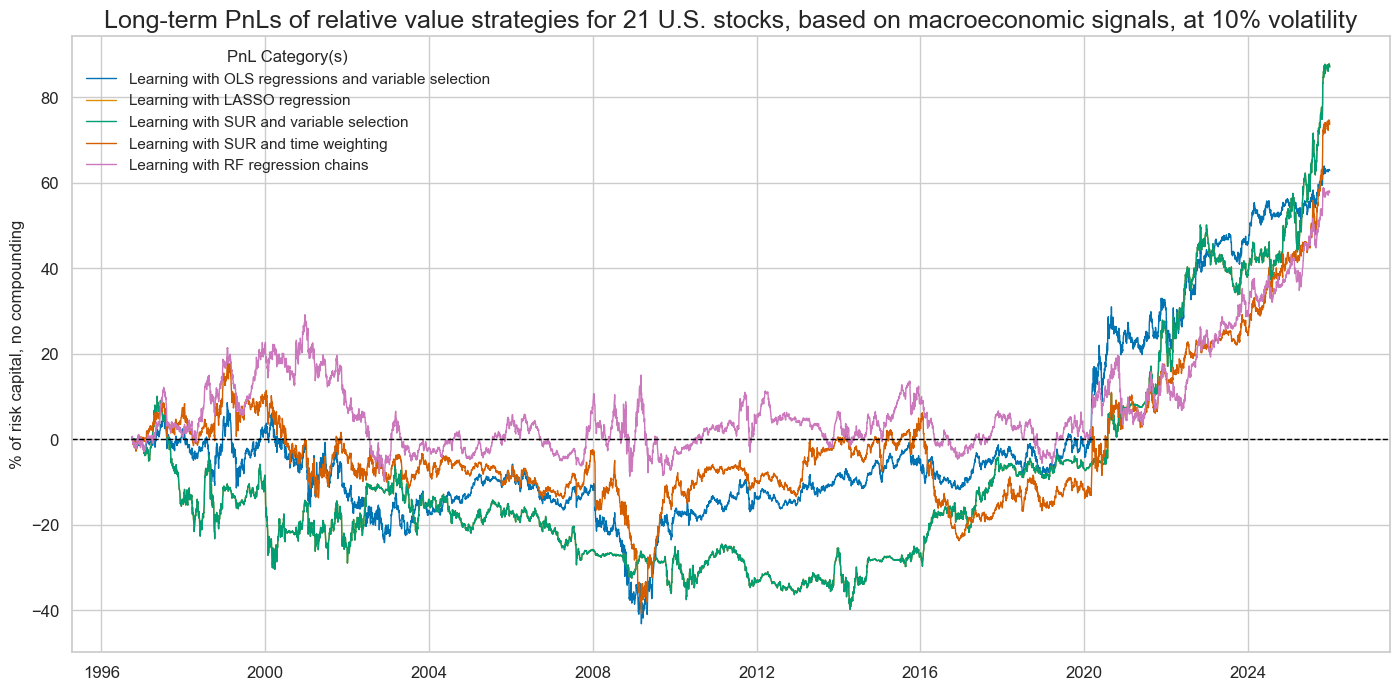

xcat                     OLS_SELECT_ZN_PZN0 LASSO_ZN_PZN0 SUR_SELECT_ZN_PZN0  \
Return %                           2.149541      2.976469           2.976469   
St. Dev. %                             10.0          10.0               10.0   
Sharpe Ratio                       0.214954      0.297647           0.297647   
Sortino Ratio                      0.304233      0.430013           0.430013   
Max 21-Day Draw %                -13.260353    -17.772146         -17.772146   
Max 6-Month Draw %               -21.321611    -24.248478         -24.248478   
Peak to Trough Draw %            -51.695673    -49.813564         -49.813564   
Top 5% Monthly PnL Share           1.917341      1.589994           1.589994   
Traded Months                           352           352                352   

xcat                     SUR_TW_ZN_PZN0 RC_ZN_PZN0  
Return %                       2.517411   1.972064  
St. Dev. %                         10.0       10.0  
Sharpe Ratio                   0.251741   0.197206  
Sortino Ratio                  0.358504   0.274469  
Max 21-Day Draw %             -13.70066 -14.104067  
Max 6-Month Draw %            -24.93555 -19.815925  
Peak to Trough Draw %        -59.941836 -38.868924  
Top 5% Monthly PnL Share       1.645048   1.803363  
Traded Months                       352        352

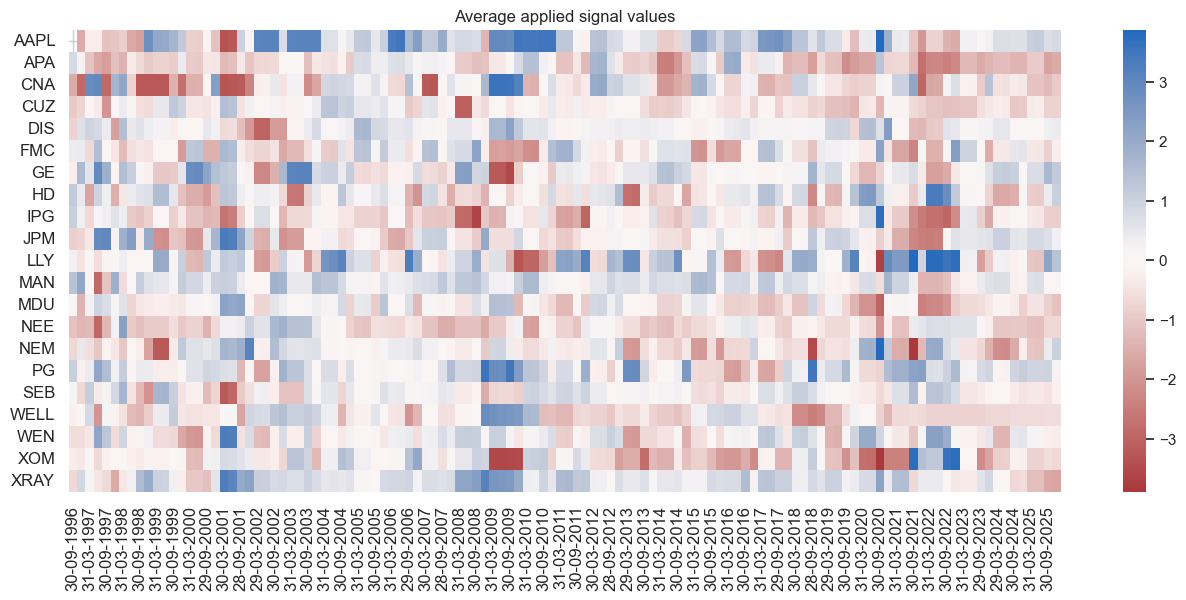

In [418]:
dix = dict_sns

sigx = dix["sigs"]
cidx = dix["cidx"]
start = dix["start"]
naive_pnl = dix["pnls"]

pnl0_labels = {
    "OLS_SELECT_ZN_PZN0": "Learning with OLS regressions and variable selection",
    "SUR_SELECT_ZN_PZN0": "Learning with SUR and variable selection",
    "LASSO_ZN_PZN0": "Learning with LASSO regression",
    "SUR_TW_ZN_PZN0": "Learning with SUR and time weighting",
    "RC_ZN_PZN0": "Learning with RF regression chains",
}


pnls = [s + "_PZN0" for s in sigx]  # + ["Long S12 versus basket"]

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Long-term PnLs of relative value strategies for 21 U.S. stocks, based on macroeconomic signals, at 10% volatility",
    title_fontsize=18,
    figsize=(17, 8),
    xcat_labels=pnl0_labels,
)

display(naive_pnl.evaluate_pnls(pnl_cats=pnls))

naive_pnl.signal_heatmap(
    pnl_name=sigx[0] + "_PZN0", freq="q", start=start, figsize=(16, 6)
)

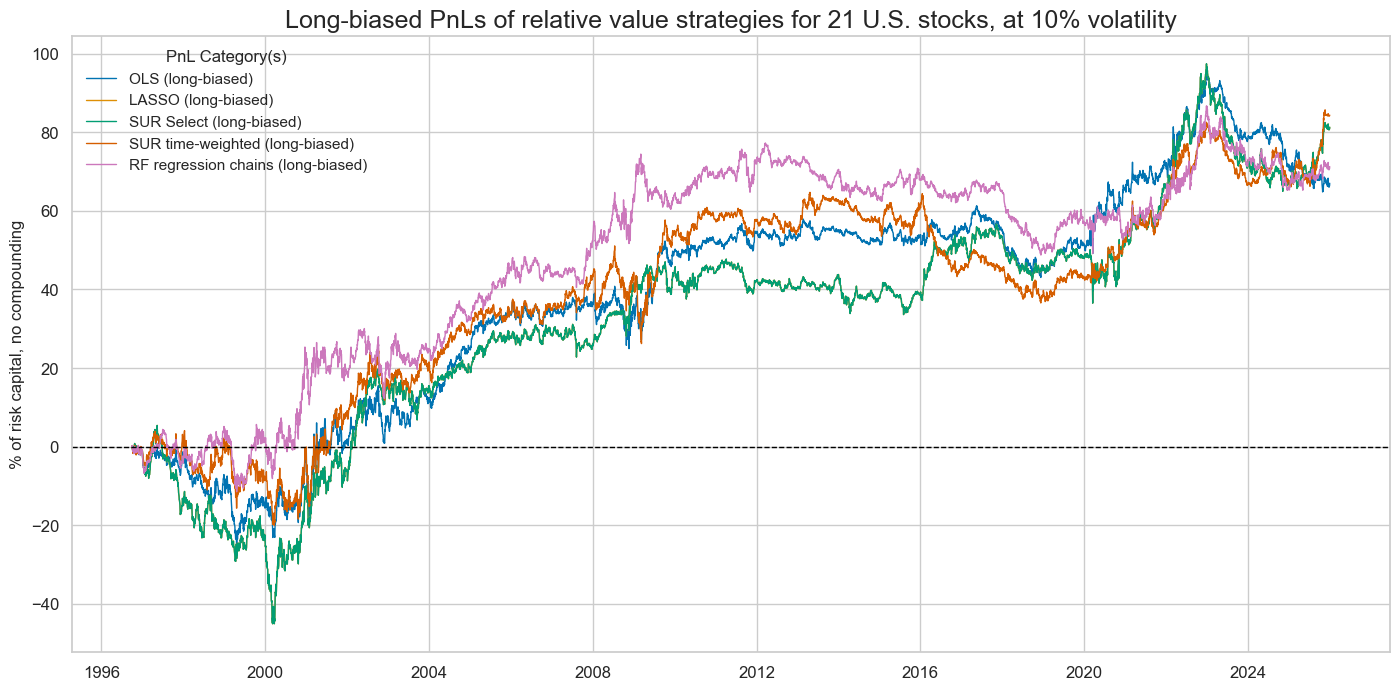

xcat                     OLS_SELECT_ZN_PZN1 LASSO_ZN_PZN1 SUR_SELECT_ZN_PZN1  \
Return %                           2.294016      2.781795           2.781795   
St. Dev. %                             10.0          10.0               10.0   
Sharpe Ratio                       0.229402      0.278179           0.278179   
Sortino Ratio                      0.330812      0.405958           0.405958   
Max 21-Day Draw %                -16.439779    -12.485032         -12.485032   
Max 6-Month Draw %               -16.613326    -25.995253         -25.995253   
Peak to Trough Draw %            -30.047648    -50.531148         -50.531148   
Top 5% Monthly PnL Share           1.649413      1.269181           1.269181   
Traded Months                           352           352                352   

xcat                     SUR_TW_ZN_PZN1 RC_ZN_PZN1  
Return %                       2.887497   2.439126  
St. Dev. %                         10.0       10.0  
Sharpe Ratio                    0.28875   0.243913  
Sortino Ratio                  0.417093   0.344473  
Max 21-Day Draw %            -15.010535 -12.711881  
Max 6-Month Draw %           -16.337709 -17.787296  
Peak to Trough Draw %        -28.160385 -28.548957  
Top 5% Monthly PnL Share       1.242457     1.5466  
Traded Months                       352        352

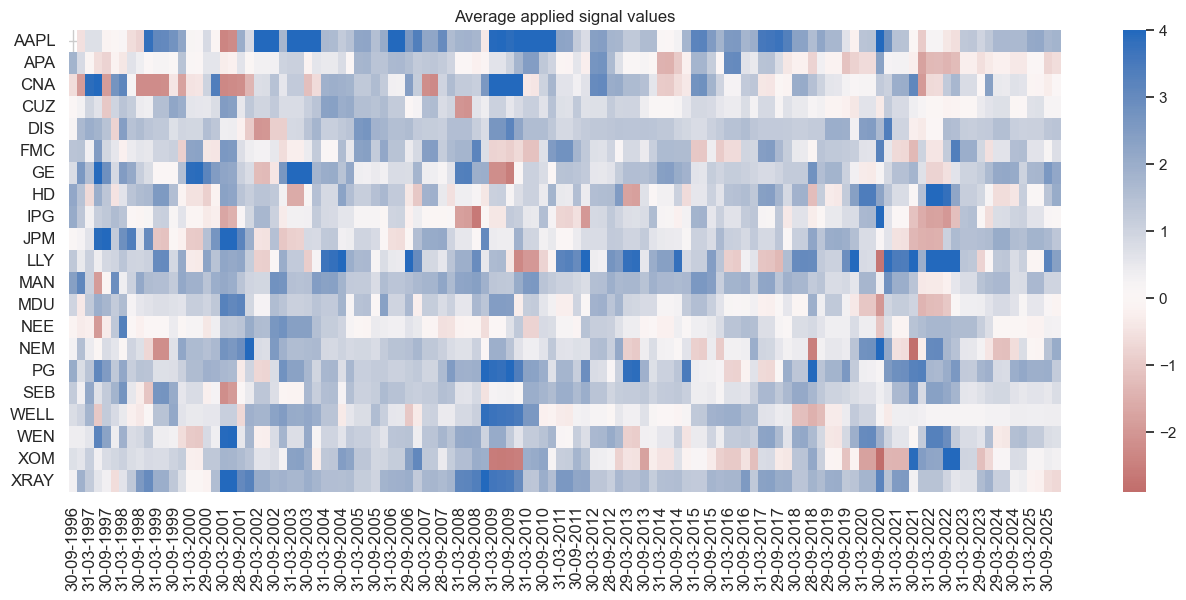

In [421]:
# --- quarterly rebalancing with volatility targeting @10%: Long biased ---
dix        = dict_sns
sigx       = dix["sigs"]
cidx       = dix["cidx"]
start      = dix["start"]
naive_pnl  = dix["pnls"]

# --- Long‑biased PnL names ---
pnls_bias1 = [s + "_PZN1" for s in sigx]

# --- labels for bias=1 versions ---
pnl1_labels = {
    "OLS_SELECT_ZN_PZN1": "OLS (long-biased)",
    "LASSO_ZN_PZN1":      "LASSO (long-biased)",
    "SUR_SELECT_ZN_PZN1": "SUR Select (long-biased)",
    "SUR_TW_ZN_PZN1":     "SUR time-weighted (long-biased)",
    "RC_ZN_PZN1":         "RF regression chains (long-biased)",
}

# --- Plot cumulative PnLs for bias=1 ---
naive_pnl.plot_pnls(
    pnl_cats=pnls_bias1,
    pnl_cids=["ALL"],
    start=start,
    title="Long-biased PnLs of relative value strategies for 21 U.S. stocks, at 10% volatility",
    title_fontsize=18,
    figsize=(17, 8),
    xcat_labels=pnl1_labels,
)

# --- Show performance statistics for bias=1 ---
display(naive_pnl.evaluate_pnls(pnl_cats=pnls_bias1))

# --- Heatmap of one long-biased strategy ---
naive_pnl.signal_heatmap(
    pnl_name=sigx[0] + "_PZN1",
    freq="q",
    start=start,
    figsize=(16, 6),
)


In [423]:
# --- backtesting by monthly rebalancing with volatility targeting @ 10%---
from macrosynergy.pnl.naive_pnl import NaivePnL

# --- Signal setup ---
dix   = dict_sns
sigx  = dix["sigs"]          # list of signal xcats to backtest
targ  = dix["targs"][0]      # return xcat
cidx  = dix["cidx"]          # stock universe
start = dix["start"]         # backtest start date

# --- Set up NaivePnL object ---
naive_pnl = NaivePnL(
    dfx,
    ret=targ,                
    sigs=sigx,
    cids=cidx,
    start=start,
    )

# --- Create PnLs for each signal, with and without +1 bias ---
for sig in sigx:
    for bias in [0, 1]:
        naive_pnl.make_pnl(
            sig=sig,
            sig_add=bias,          # 0 = neutral, 1 = long-biased
            sig_op="zn_score_pan", # transform to panel z-scores inside NaivePnL
            thresh=4,              # winsorize scores at +/-4
            rebal_freq="monthly",
            vol_scale=10,          # ex-post scaling to 10% ann. vol
            rebal_slip=1,
            pnl_name=f"{sig}_PZN{bias}",
        )

# --- Long-only benchmark PnL on the target return ---
naive_pnl.make_long_pnl(
    label="Long equity vs basket",
    vol_scale=10,
)

# --- Store back into dictionary ---
dix["pnls"] = naive_pnl


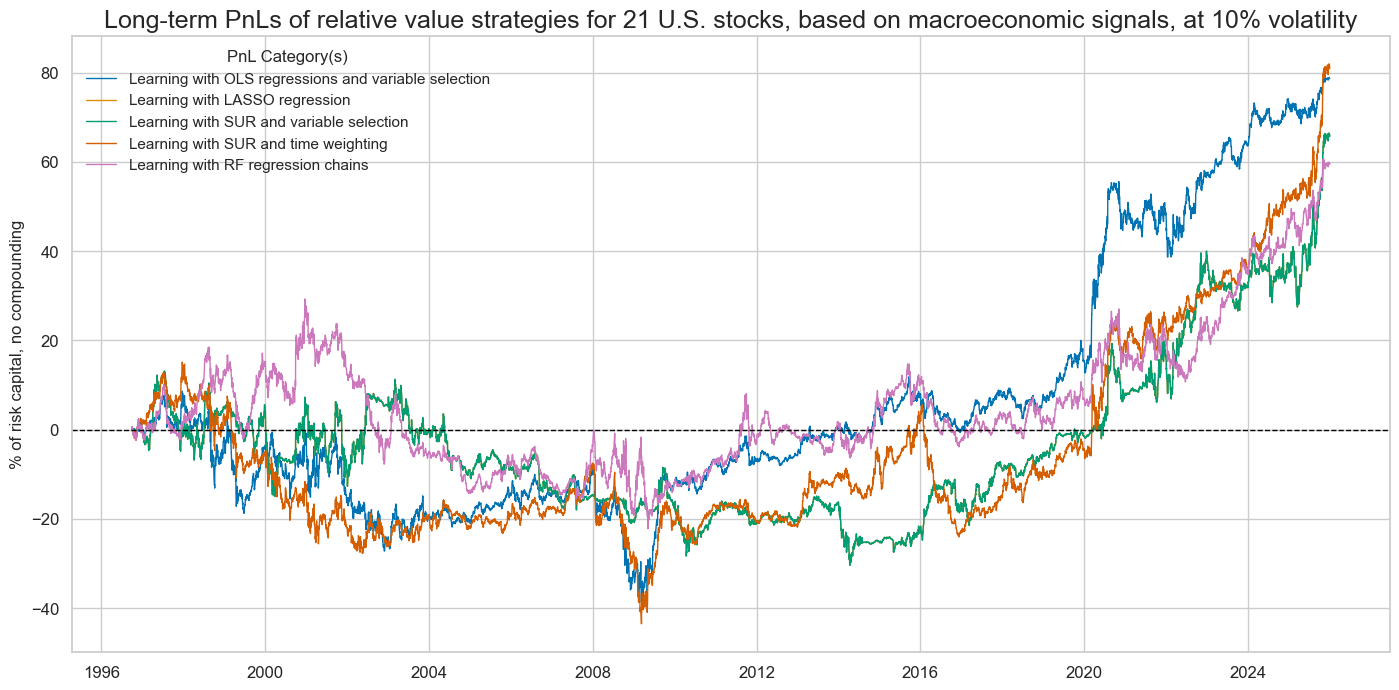

xcat                     OLS_SELECT_ZN_PZN0 LASSO_ZN_PZN0 SUR_SELECT_ZN_PZN0  \
Return %                           2.688852      2.245899           2.245899   
St. Dev. %                             10.0          10.0               10.0   
Sharpe Ratio                       0.268885       0.22459            0.22459   
Sortino Ratio                      0.377491      0.319081           0.319081   
Max 21-Day Draw %                -13.652698    -16.853331         -16.853331   
Max 6-Month Draw %               -20.666194    -16.799644         -16.799644   
Peak to Trough Draw %            -47.351652    -43.532073         -43.532073   
Top 5% Monthly PnL Share           1.565807      1.930436           1.930436   
Traded Months                           352           352                352   

xcat                     SUR_TW_ZN_PZN0 RC_ZN_PZN0  
Return %                       2.766361   2.033246  
St. Dev. %                         10.0       10.0  
Sharpe Ratio                   0.276636   0.203325  
Sortino Ratio                  0.389017   0.285609  
Max 21-Day Draw %            -13.568761 -11.979805  
Max 6-Month Draw %           -23.570945  -19.03352  
Peak to Trough Draw %        -58.632158 -51.479187  
Top 5% Monthly PnL Share       1.529258   1.781959  
Traded Months                       352        352

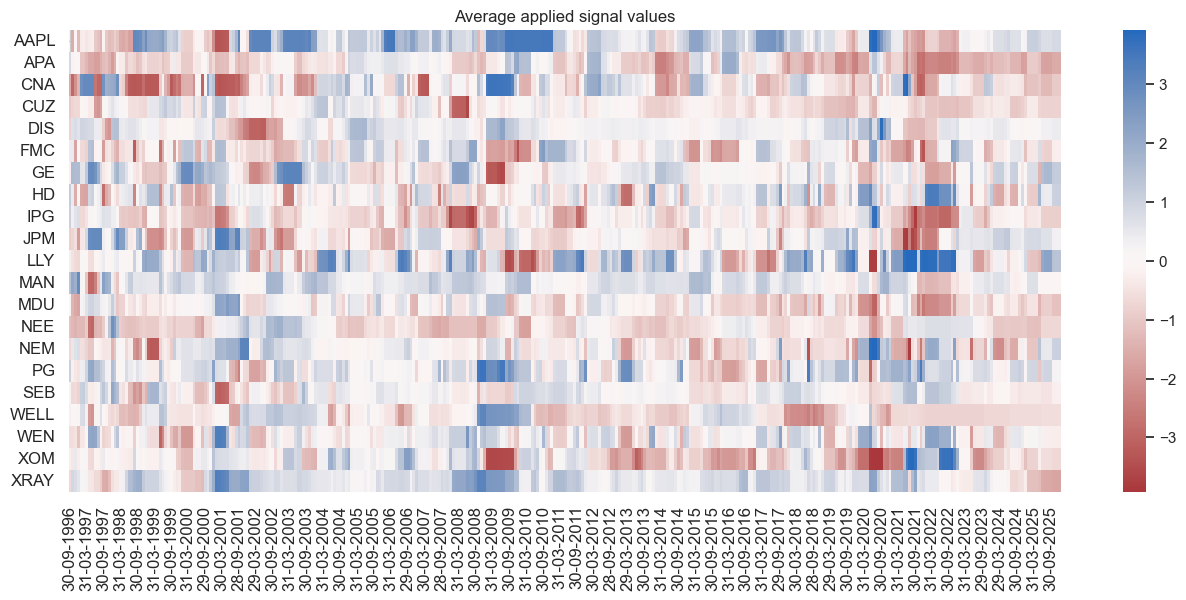

In [429]:
dix = dict_sns

sigx = dix["sigs"]
cidx = dix["cidx"]
start = dix["start"]
naive_pnl = dix["pnls"]

pnl0_labels = {
    "OLS_SELECT_ZN_PZN0": "Learning with OLS regressions and variable selection",
    "SUR_SELECT_ZN_PZN0": "Learning with SUR and variable selection",
    "LASSO_ZN_PZN0": "Learning with LASSO regression",
    "SUR_TW_ZN_PZN0": "Learning with SUR and time weighting",
    "RC_ZN_PZN0": "Learning with RF regression chains",
}


pnls = [s + "_PZN0" for s in sigx]  # + ["Long S12 versus basket"]

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Long-term PnLs of relative value strategies for 21 U.S. stocks, based on macroeconomic signals, at 10% volatility",
    title_fontsize=18,
    figsize=(17, 8),
    xcat_labels=pnl0_labels,
)

display(naive_pnl.evaluate_pnls(pnl_cats=pnls))

naive_pnl.signal_heatmap(
    pnl_name=sigx[0] + "_PZN0", freq="m", start=start, figsize=(16, 6)
)

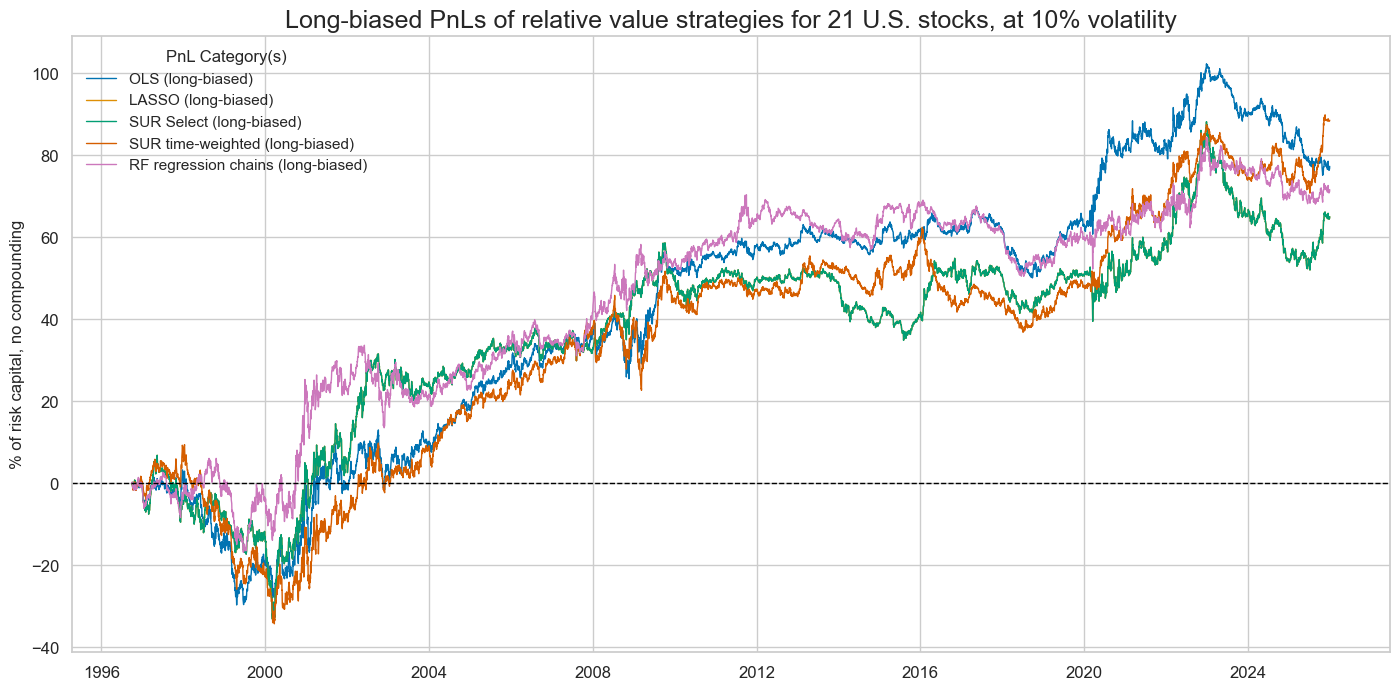

xcat                     OLS_SELECT_ZN_PZN1 LASSO_ZN_PZN1 SUR_SELECT_ZN_PZN1  \
Return %                           2.641973      2.222135           2.222135   
St. Dev. %                             10.0          10.0               10.0   
Sharpe Ratio                       0.264197      0.222213           0.222213   
Sortino Ratio                      0.378813       0.31935            0.31935   
Max 21-Day Draw %                -15.988703    -11.966623         -11.966623   
Max 6-Month Draw %               -18.927774     -22.61516          -22.61516   
Peak to Trough Draw %            -32.946483    -40.155896         -40.155896   
Top 5% Monthly PnL Share           1.466146      1.586306           1.586306   
Traded Months                           352           352                352   

xcat                     SUR_TW_ZN_PZN1 RC_ZN_PZN1  
Return %                        3.02676   2.447641  
St. Dev. %                         10.0       10.0  
Sharpe Ratio                   0.302676   0.244764  
Sortino Ratio                  0.434383   0.346291  
Max 21-Day Draw %            -14.726537  -12.36465  
Max 6-Month Draw %           -20.881778 -20.112244  
Peak to Trough Draw %        -43.691336 -22.897431  
Top 5% Monthly PnL Share       1.212013   1.541544  
Traded Months                       352        352

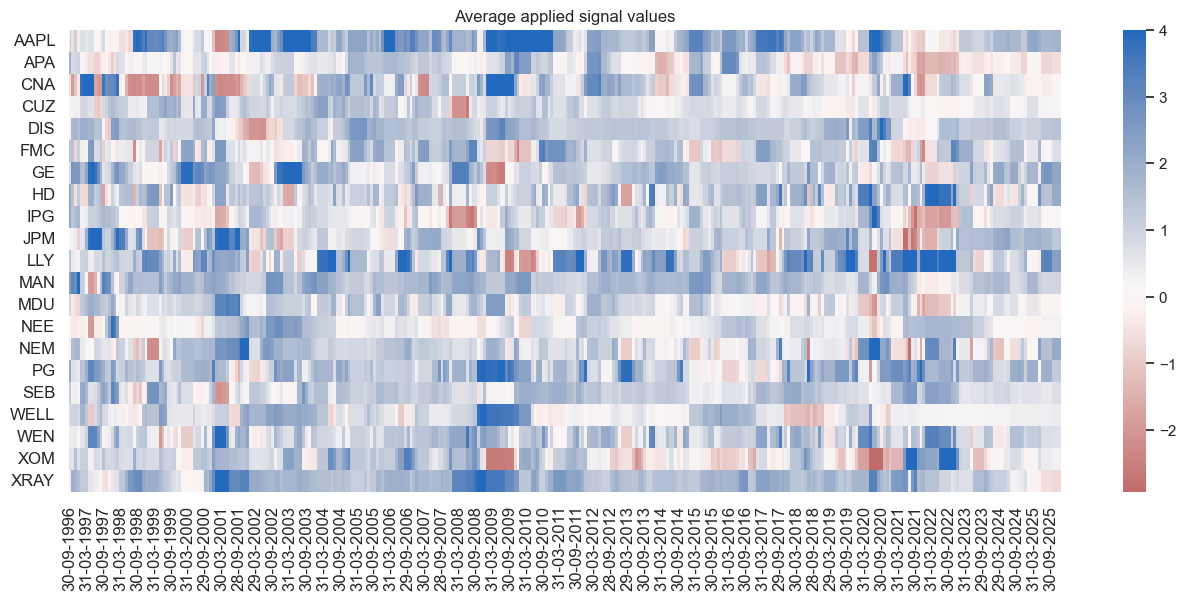

In [431]:
# --- monthly rebalancing with volatility targeting @10%: Long biased ---
dix        = dict_sns
sigx       = dix["sigs"]
cidx       = dix["cidx"]
start      = dix["start"]
naive_pnl  = dix["pnls"]

# --- Long‑biased PnL names ---
pnls_bias1 = [s + "_PZN1" for s in sigx]

# --- labels for bias=1 versions ---
pnl1_labels = {
    "OLS_SELECT_ZN_PZN1": "OLS (long-biased)",
    "LASSO_ZN_PZN1":      "LASSO (long-biased)",
    "SUR_SELECT_ZN_PZN1": "SUR Select (long-biased)",
    "SUR_TW_ZN_PZN1":     "SUR time-weighted (long-biased)",
    "RC_ZN_PZN1":         "RF regression chains (long-biased)",
}

# --- Plot cumulative PnLs for bias=1 ---
naive_pnl.plot_pnls(
    pnl_cats=pnls_bias1,
    pnl_cids=["ALL"],
    start=start,
    title="Long-biased PnLs of relative value strategies for 21 U.S. stocks, at 10% volatility",
    title_fontsize=18,
    figsize=(17, 8),
    xcat_labels=pnl1_labels,
)

# --- Show performance statistics for bias=1 ---
display(naive_pnl.evaluate_pnls(pnl_cats=pnls_bias1))

# --- Heatmap of one long-biased strategy ---
naive_pnl.signal_heatmap(
    pnl_name=sigx[0] + "_PZN1",
    freq="m",
    start=start,
    figsize=(16, 6),
)


In [335]:
# Equal weights
cidx = cids_stocks

calcs = [
    "EQWGT = 0 * EQCR_NSA + 1",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfa["tot_cids"] = dfa.groupby(["real_date", "xcat"])["value"].transform("count")
dfa["value"] = dfa["value"] / dfa["tot_cids"]

dfx = msm.update_df(dfx, dfa.drop(columns=["tot_cids"]))

In [337]:
dfa["tot_cids"]

0         20
1         20
2         21
3         21
4         21
          ..
179965    21
179966    21
179967    21
179968    21
179969    21
Name: tot_cids, Length: 179970, dtype: int64

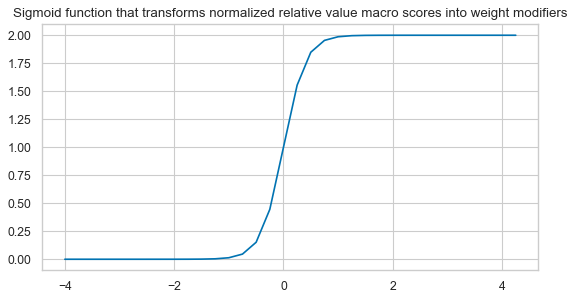

In [339]:
# ---  Define appropriate sigmoid function for adjusting weights ---

amplitude = 2
steepness = 5
midpoint = 0


def sigmoid(x, a=amplitude, b=steepness, c=midpoint):
    return a / (1 + np.exp(-b * (x - c)))


ar = np.array([i / 4 for i in range(-16, 18)])
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(ar, sigmoid(ar))
plt.title(
    "Sigmoid function that transforms normalized relative value macro scores into weight modifiers"
)
plt.show()

In [341]:
# --- Calculate adjusted weights ---

cidx = cids_stocks
xcatx = ["OLS_SELECT_ZN", "LASSO_ZN", "SUR_SELECT_ZN", "SUR_TW_ZN", "RC_ZN"]

for xcat in xcatx:
    dfj = adjust_weights(
        dfx,
        weights_xcat="EQWGT",
        adj_zns_xcat=xcat,
        method="generic",
        adj_func=sigmoid,
        cids=cidx,
        adj_name="WGT_" + xcat,
    )
    dfx = msm.update_df(dfx, dfj)

weightz = ["WGT_" + xcat for xcat in xcatx]

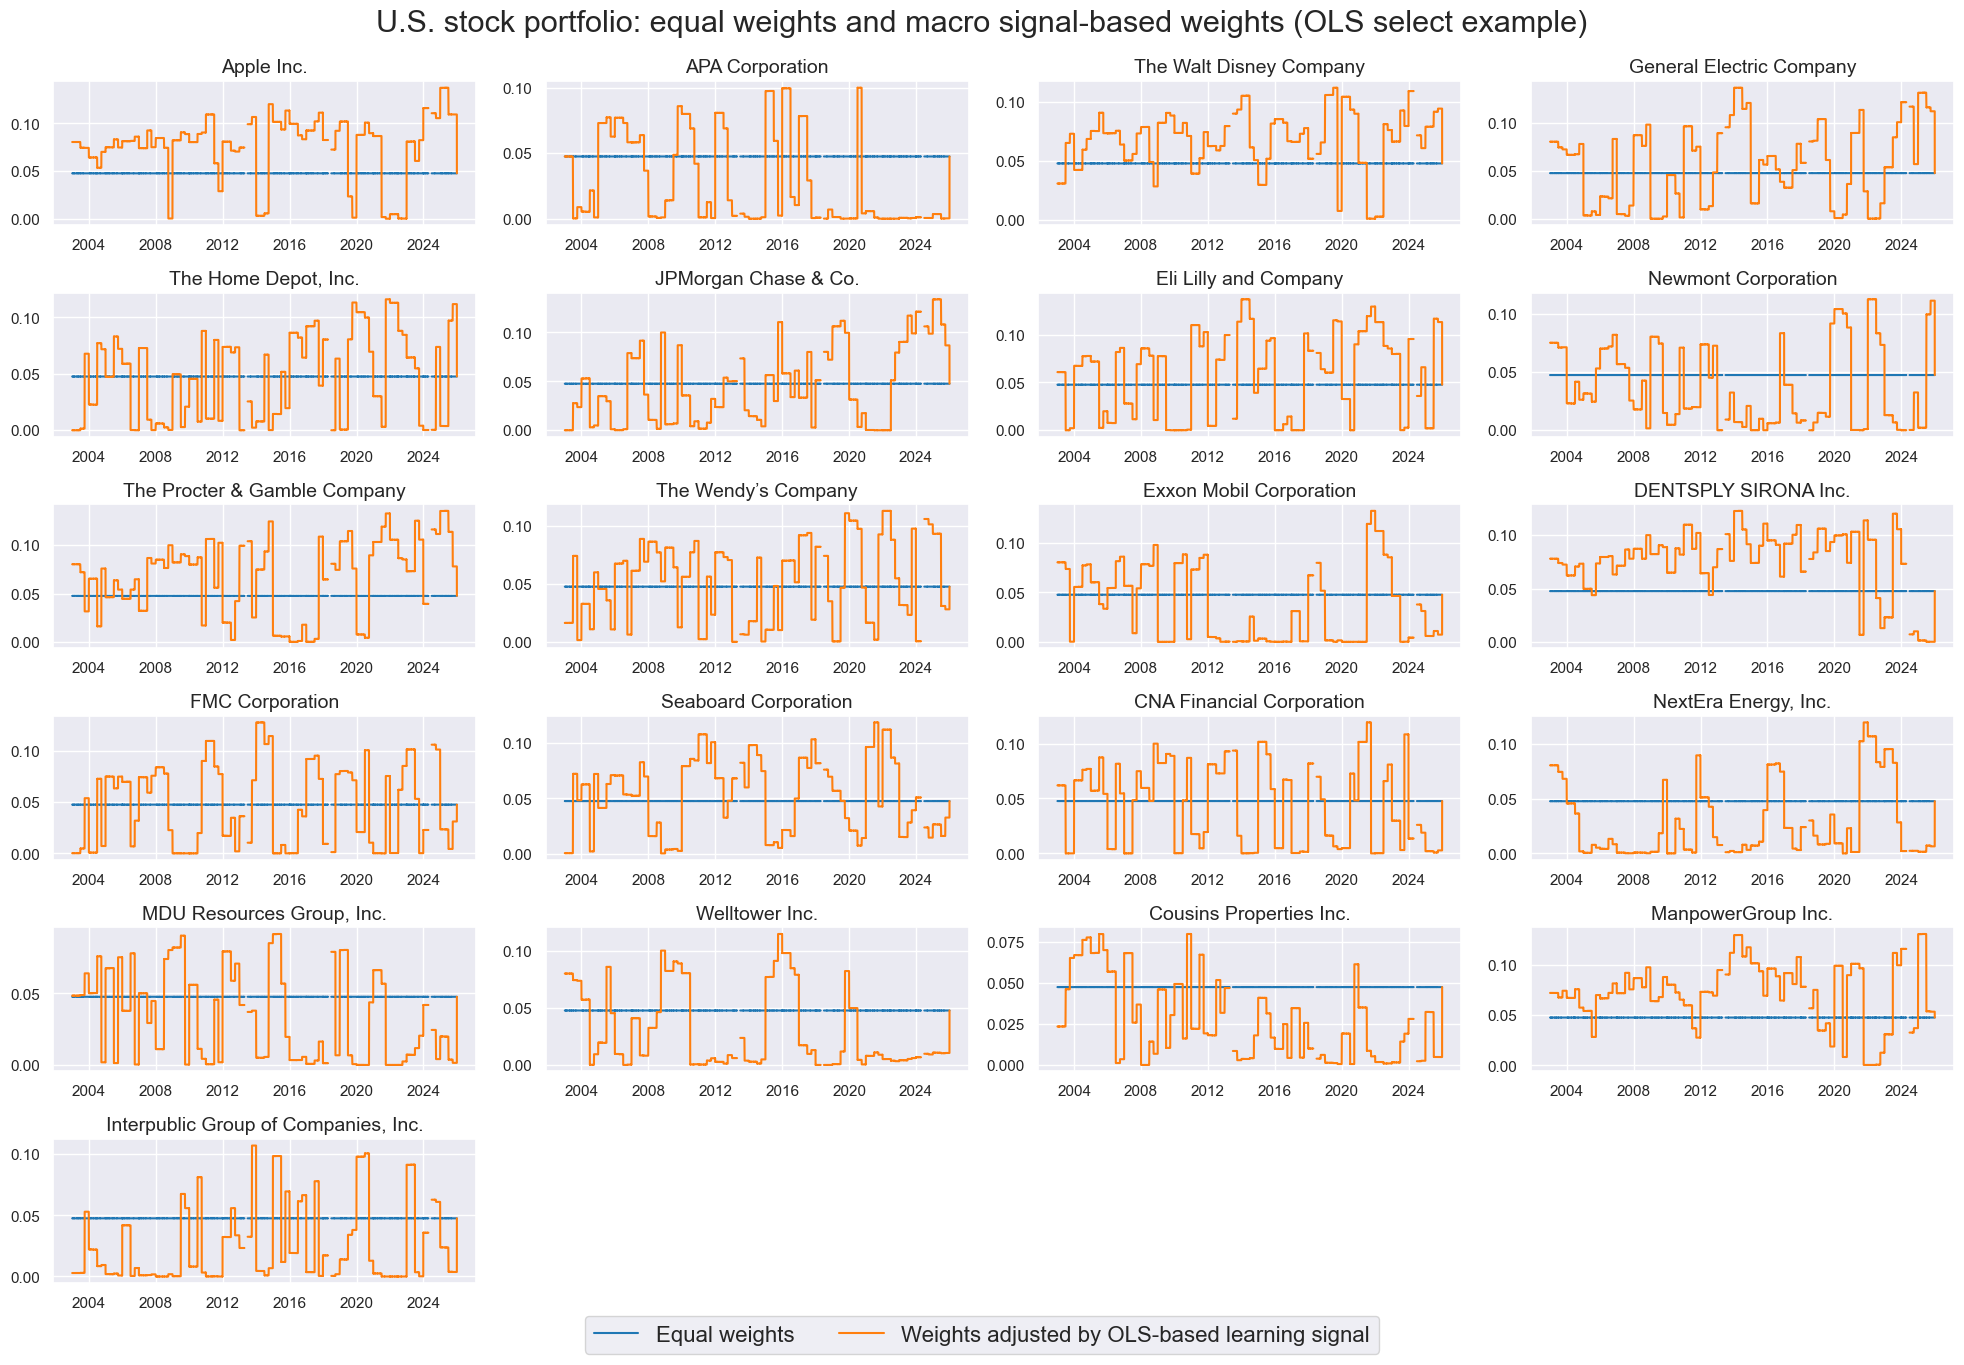

In [343]:
# --- Visualize weights ---

cidx = cids_stocks
xcatx = ["EQWGT", "WGT_OLS_SELECT_ZN"]

# Reduce frequency to monthly in accordance with PnL simulation
for xc in xcatx:
    dfa = dfx.loc[dfx["xcat"] == xc]
    dfa["last_period_bd"] = pd.to_datetime(
        dfa["real_date"]
    ) + pd.tseries.offsets.BQuarterEnd(0)
    mask = pd.to_datetime(dfa["last_period_bd"]) == pd.to_datetime(dfa["real_date"])
    dfa.loc[~mask, "value"] = np.nan
    dfa["value"] = dfa.groupby("cid")["value"].ffill(limit=75)  # max 25 business days
    dfa = dfa.drop(columns="xcat").assign(xcat=f"{xc}_M")
    dfx = msm.update_df(dfx, dfa)

xcatxx = [xc + "_M" for xc in xcatx]
weight_labels = {
    "EQWGT_M": "Equal weights",
    "WGT_OLS_SELECT_ZN_M": "Weights adjusted by OLS-based learning signal",
}

msp.view_timelines(
    dfx,
    xcats=xcatxx,
    cids=cidx,
    ncol=4,
    start="2003-01-01",
    same_y=False,
    cumsum=False,
    title="U.S. stock portfolio: equal weights and macro signal-based weights (OLS select example)",
    title_fontsize=22,
    cid_labels=stock_labels,
    xcat_labels=weight_labels,
    height=1.5,
    aspect=2.2,
    legend_fontsize=16,
    all_xticks=True,
    ax_hline=None,
)


In [345]:
dict_mod = {
    "sigs": ["EQWGT"] + weightz,
    "targ": "EQCR_NSA",
    "cidx": cids_stocks,
    "start": "1998-01-01",
    "srr": None,
    "pnls": None,
}

In [347]:
dix = dict_mod

sigs = dix["sigs"]
ret = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

pnls = msn.NaivePnL(
    df=dfx,
    ret=ret,
    sigs=sigs,
    cids=cidx,
    start=start,
)
for sig in sigs:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        rebal_freq="quarterly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
    )

dix["pnls"] = pnls

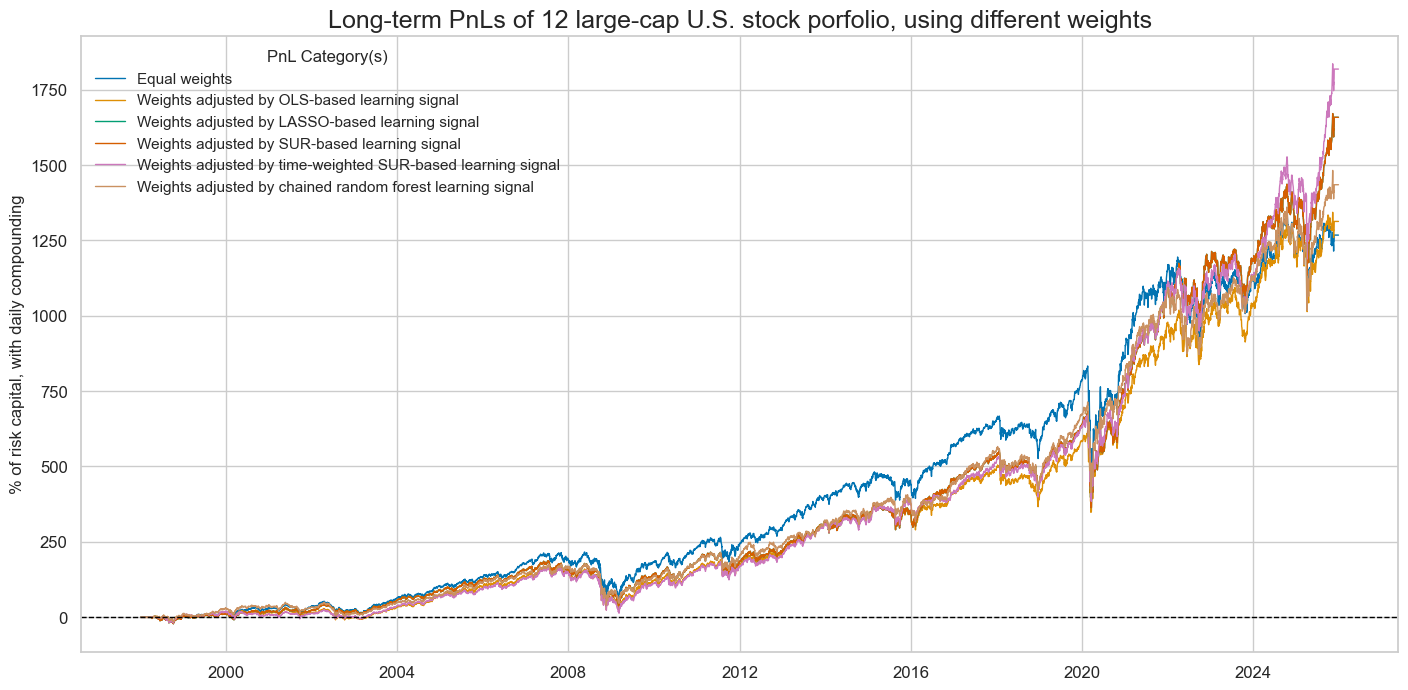

xcat                      PNL_EQWGT PNL_WGT_OLS_SELECT_ZN PNL_WGT_LASSO_ZN  \
Return %                  11.653488             11.769437        12.640227   
St. Dev. %                19.822166             19.787078        20.093945   
Sharpe Ratio               0.587902              0.594804         0.629057   
Sortino Ratio              0.837328              0.839889         0.894057   
Max 21-Day Draw %        -48.731796             -43.52222       -47.726735   
Max 6-Month Draw %       -55.954481            -64.323898       -60.872595   
Peak to Trough Draw %    -59.465843            -70.449416       -65.852391   
Top 5% Monthly PnL Share   0.562949              0.556441         0.531436   
Traded Months                   336                   336              336   

xcat                     PNL_WGT_SUR_SELECT_ZN PNL_WGT_SUR_TW_ZN PNL_WGT_RC_ZN  
Return %                             12.640227         12.909308     12.054774  
St. Dev. %                           20.093945         19.832287     19.680022  
Sharpe Ratio                          0.629057          0.650924      0.612539  
Sortino Ratio                         0.894057          0.925975      0.864635  
Max 21-Day Draw %                   -47.726735          -41.6336    -41.709256  
Max 6-Month Draw %                  -60.872595        -63.474864    -59.123198  
Peak to Trough Draw %               -65.852391        -72.313088    -61.979376  
Top 5% Monthly PnL Share              0.531436          0.503558      0.530214  
Traded Months                              336               336           336

In [351]:
# --- quarterly signal weighted rebalancing without volatility target ---
dix = dict_mod
pnls = dix["pnls"]
sigs = dix["sigs"]
pnl_cats = ["PNL_" + sig for sig in sigs]

pnl_labels = {
    "PNL_EQWGT": "Equal weights",
    "PNL_WGT_OLS_SELECT_ZN": "Weights adjusted by OLS-based learning signal",
    "PNL_WGT_LASSO_ZN": "Weights adjusted by LASSO-based learning signal",
    "PNL_WGT_SUR_SELECT_ZN": "Weights adjusted by SUR-based learning signal",
    "PNL_WGT_SUR_TW_ZN": "Weights adjusted by time-weighted SUR-based learning signal",
    "PNL_WGT_RC_ZN": "Weights adjusted by chained random forest learning signal",
}

pnls.plot_pnls(
    pnl_cats=pnl_cats,
    title="Long-term PnLs of 12 large-cap U.S. stock porfolio, using different weights",
    title_fontsize=18,
    compounding=True,
    xcat_labels=pnl_labels,
    figsize=(17, 8),
)
pnls.evaluate_pnls(pnl_cats=pnl_cats)

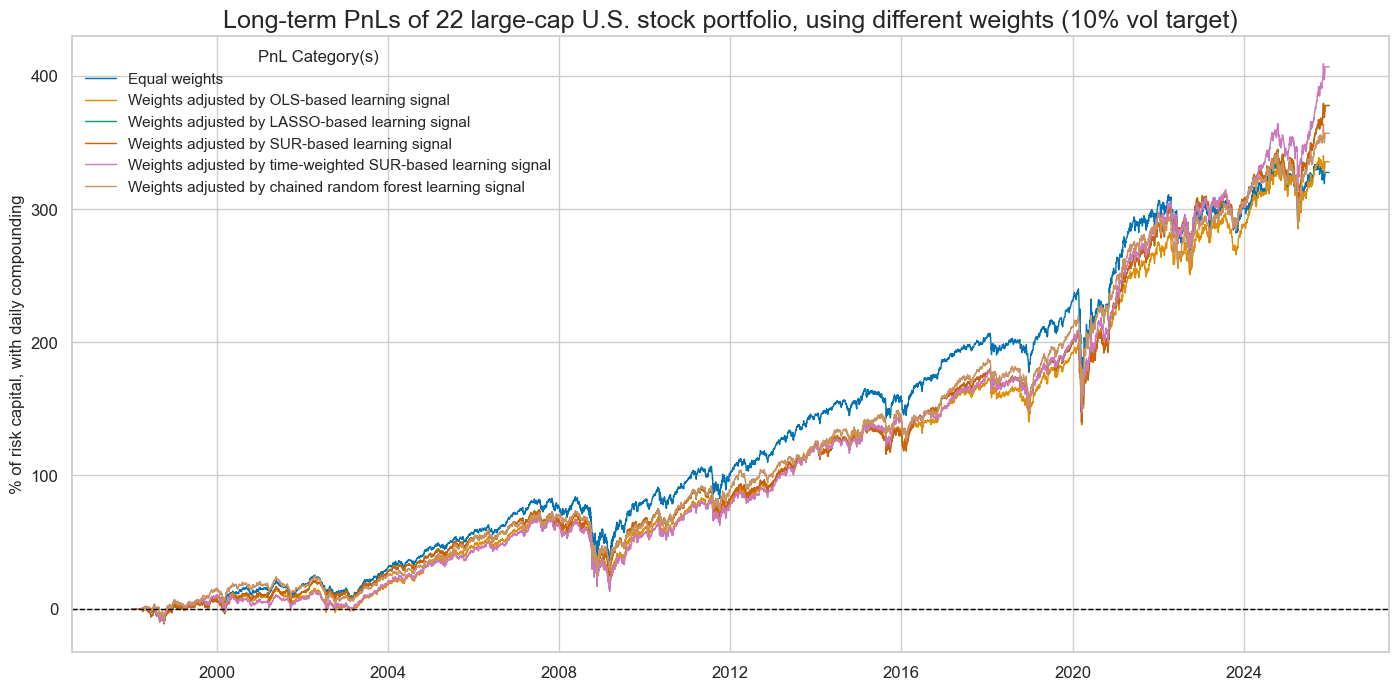

xcat                      PNL_EQWGT PNL_WGT_OLS_SELECT_ZN PNL_WGT_LASSO_ZN  \
Return %                   5.879019              5.948042         6.290565   
St. Dev. %                     10.0                  10.0             10.0   
Sharpe Ratio               0.587902              0.594804         0.629057   
Sortino Ratio              0.837328              0.839889         0.894057   
Max 21-Day Draw %        -24.584495            -21.995273       -23.751799   
Max 6-Month Draw %       -28.228237            -32.508032       -30.293999   
Peak to Trough Draw %    -29.999669            -35.603748       -32.772255   
Top 5% Monthly PnL Share   0.562949              0.556441         0.531436   
Traded Months                   336                   336              336   

xcat                     PNL_WGT_SUR_SELECT_ZN PNL_WGT_SUR_TW_ZN PNL_WGT_RC_ZN  
Return %                              6.290565          6.509238      6.125386  
St. Dev. %                                10.0              10.0          10.0  
Sharpe Ratio                          0.629057          0.650924      0.612539  
Sortino Ratio                         0.894057          0.925975      0.864635  
Max 21-Day Draw %                   -23.751799        -20.992839    -21.193704  
Max 6-Month Draw %                  -30.293999        -32.005822    -30.042241  
Peak to Trough Draw %               -32.772255        -36.462304    -31.493549  
Top 5% Monthly PnL Share              0.531436          0.503558      0.530214  
Traded Months                              336               336           336

In [353]:
# --- quarterly signal weighted rebalancing with volatility target of 10% ---
dix  = dict_mod

sigs  = dix["sigs"]
ret   = dix["targ"]
cidx  = dix["cidx"]
start = dix["start"]

# Rebuild NaivePnL with 10% vol scaling
pnls = msn.NaivePnL(
    df=dfx,
    ret=ret,
    sigs=sigs,
    cids=cidx,
    start=start,
)

for sig in sigs:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        rebal_freq="quarterly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=10,    # <-- scale each PnL to 10% annual volatility
    )

dix["pnls"] = pnls

# Plot and evaluate scaled PnLs
dix      = dict_mod
pnls     = dix["pnls"]
sigs     = dix["sigs"]
pnl_cats = ["PNL_" + sig for sig in sigs]

pnl_labels = {
    "PNL_EQWGT": "Equal weights",
    "PNL_WGT_OLS_SELECT_ZN": "Weights adjusted by OLS-based learning signal",
    "PNL_WGT_LASSO_ZN": "Weights adjusted by LASSO-based learning signal",
    "PNL_WGT_SUR_SELECT_ZN": "Weights adjusted by SUR-based learning signal",
    "PNL_WGT_SUR_TW_ZN": "Weights adjusted by time-weighted SUR-based learning signal",
    "PNL_WGT_RC_ZN": "Weights adjusted by chained random forest learning signal",
}

pnls.plot_pnls(
    pnl_cats=pnl_cats,
    title="Long-term PnLs of 22 large-cap U.S. stock portfolio, using different weights (10% vol target)",
    title_fontsize=18,
    compounding=True,
    xcat_labels=pnl_labels,
    figsize=(17, 8),
)

pnls.evaluate_pnls(pnl_cats=pnl_cats)


In [355]:
# --- reblancing monthly to see how the performance changes ---
dict_mod = {
    "sigs": ["EQWGT"] + weightz,
    "targ": "EQCR_NSA",
    "cidx": cids_stocks,
    "start": "1998-01-01",
    "srr": None,
    "pnls": None,
}

dix = dict_mod

sigs = dix["sigs"]
ret = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

pnls = msn.NaivePnL(
    df=dfx,
    ret=ret,
    sigs=sigs,
    cids=cidx,
    start=start,
)
for sig in sigs:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
    )

dix["pnls"] = pnls

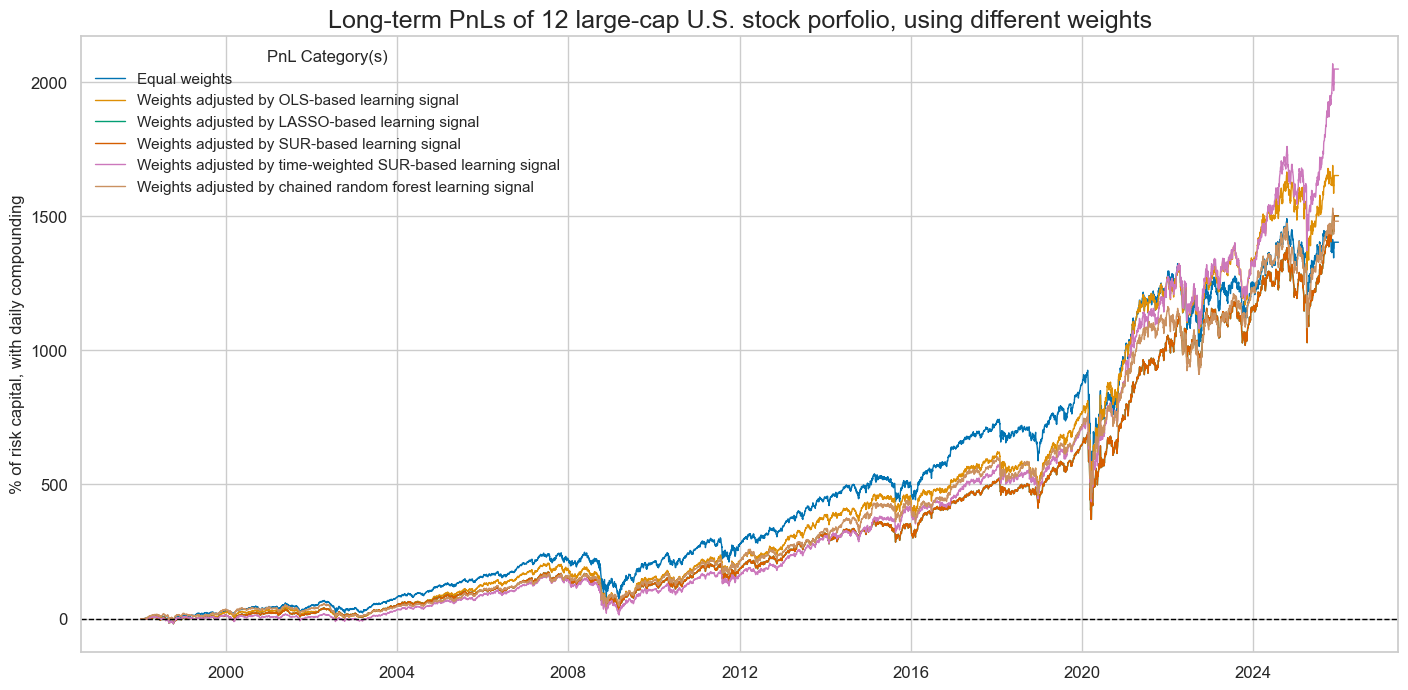

xcat                      PNL_EQWGT PNL_WGT_OLS_SELECT_ZN PNL_WGT_LASSO_ZN  \
Return %                  12.006344             12.574321        12.288592   
St. Dev. %                19.837366             19.832282         20.06684   
Sharpe Ratio               0.605239              0.634033         0.612383   
Sortino Ratio              0.862366              0.896044         0.869079   
Max 21-Day Draw %        -48.731796            -43.523327        -47.71972   
Max 6-Month Draw %       -55.954481            -65.110861       -61.343847   
Peak to Trough Draw %    -59.465843            -71.553806       -65.110638   
Top 5% Monthly PnL Share   0.546404              0.520481         0.532525   
Traded Months                   336                   336              336   

xcat                     PNL_WGT_SUR_SELECT_ZN PNL_WGT_SUR_TW_ZN PNL_WGT_RC_ZN  
Return %                             12.288592            13.322     12.123406  
St. Dev. %                            20.06684          19.79754     19.469503  
Sharpe Ratio                          0.612383          0.672912      0.622687  
Sortino Ratio                         0.869079          0.957134      0.880192  
Max 21-Day Draw %                    -47.71972        -42.279994    -41.707352  
Max 6-Month Draw %                  -61.343847        -64.158023    -52.796072  
Peak to Trough Draw %               -65.110638        -71.537312    -55.652253  
Top 5% Monthly PnL Share              0.532525          0.485203      0.526569  
Traded Months                              336               336           336

In [357]:
# --- visualization of monthly rebalancing w/o vol target ---
dix = dict_mod
pnls = dix["pnls"]
sigs = dix["sigs"]
pnl_cats = ["PNL_" + sig for sig in sigs]

pnl_labels = {
    "PNL_EQWGT": "Equal weights",
    "PNL_WGT_OLS_SELECT_ZN": "Weights adjusted by OLS-based learning signal",
    "PNL_WGT_LASSO_ZN": "Weights adjusted by LASSO-based learning signal",
    "PNL_WGT_SUR_SELECT_ZN": "Weights adjusted by SUR-based learning signal",
    "PNL_WGT_SUR_TW_ZN": "Weights adjusted by time-weighted SUR-based learning signal",
    "PNL_WGT_RC_ZN": "Weights adjusted by chained random forest learning signal",
}

pnls.plot_pnls(
    pnl_cats=pnl_cats,
    title="Long-term PnLs of 12 large-cap U.S. stock porfolio, using different weights",
    title_fontsize=18,
    compounding=True,
    xcat_labels=pnl_labels,
    figsize=(17, 8),
)
pnls.evaluate_pnls(pnl_cats=pnl_cats)

In [359]:
# --- reblancing monthly to see how the performance changes with volatility target at 10% ---
dict_mod = {
    "sigs": ["EQWGT"] + weightz,
    "targ": "EQCR_NSA",
    "cidx": cids_stocks,
    "start": "1998-01-01",
    "srr": None,
    "pnls": None,
}

dix = dict_mod

sigs = dix["sigs"]
ret = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

pnls = msn.NaivePnL(
    df=dfx,
    ret=ret,
    sigs=sigs,
    cids=cidx,
    start=start,
)
for sig in sigs:
    pnls.make_pnl(
        sig=sig,
        sig_op="raw",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=10,
    )

dix["pnls"] = pnls

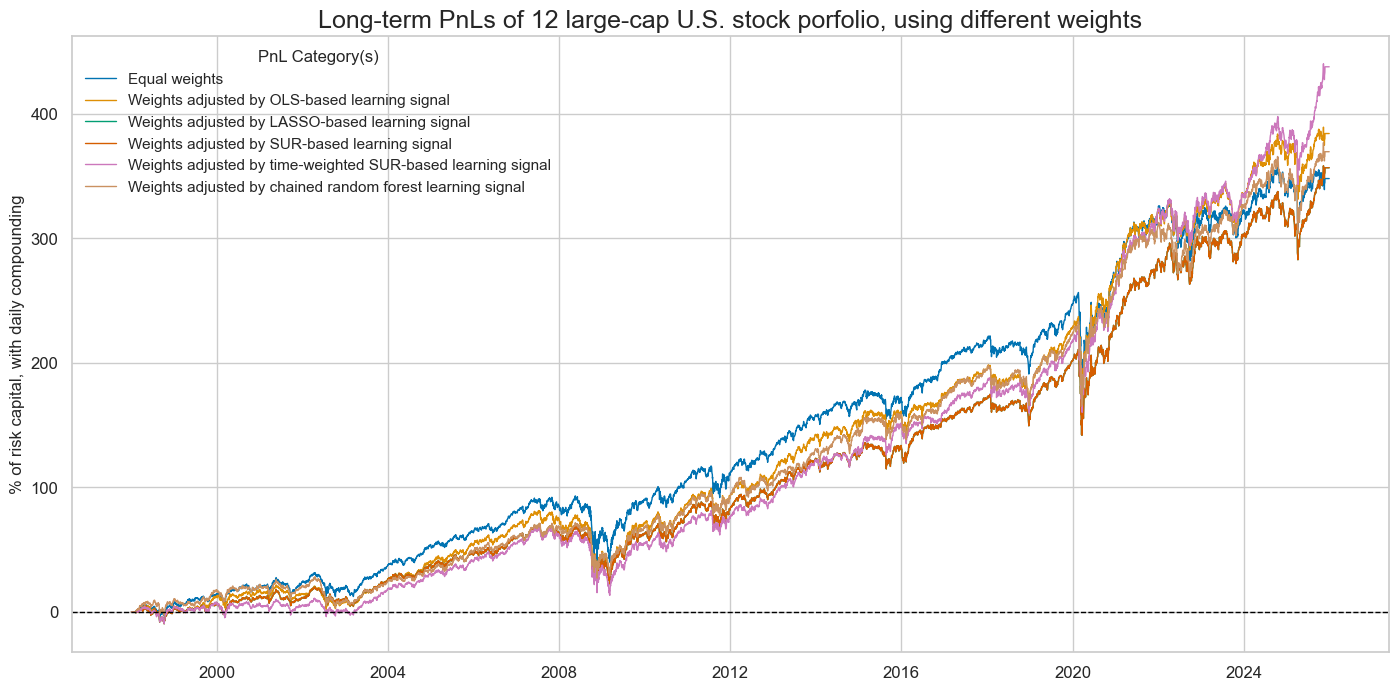

xcat                      PNL_EQWGT PNL_WGT_OLS_SELECT_ZN PNL_WGT_LASSO_ZN  \
Return %                   6.052388               6.34033          6.12383   
St. Dev. %                     10.0                  10.0             10.0   
Sharpe Ratio               0.605239              0.634033         0.612383   
Sortino Ratio              0.862366              0.896044         0.869079   
Max 21-Day Draw %        -24.565658            -21.945698       -23.780386   
Max 6-Month Draw %       -28.206608            -32.830746       -30.569759   
Peak to Trough Draw %    -29.976683            -36.079462       -32.446881   
Top 5% Monthly PnL Share   0.546404              0.520481         0.532525   
Traded Months                   336                   336              336   

xcat                     PNL_WGT_SUR_SELECT_ZN PNL_WGT_SUR_TW_ZN PNL_WGT_RC_ZN  
Return %                               6.12383          6.729119       6.22687  
St. Dev. %                                10.0              10.0          10.0  
Sharpe Ratio                          0.612383          0.672912      0.622687  
Sortino Ratio                         0.869079          0.957134      0.880192  
Max 21-Day Draw %                   -23.780386        -21.356186    -21.421888  
Max 6-Month Draw %                  -30.569759        -32.407069    -27.117319  
Peak to Trough Draw %               -32.446881        -36.134445    -28.584321  
Top 5% Monthly PnL Share              0.532525          0.485203      0.526569  
Traded Months                              336               336           336

In [361]:
# --- plot for volatility target at 10% ---
dix = dict_mod
pnls = dix["pnls"]
sigs = dix["sigs"]
pnl_cats = ["PNL_" + sig for sig in sigs]

pnl_labels = {
    "PNL_EQWGT": "Equal weights",
    "PNL_WGT_OLS_SELECT_ZN": "Weights adjusted by OLS-based learning signal",
    "PNL_WGT_LASSO_ZN": "Weights adjusted by LASSO-based learning signal",
    "PNL_WGT_SUR_SELECT_ZN": "Weights adjusted by SUR-based learning signal",
    "PNL_WGT_SUR_TW_ZN": "Weights adjusted by time-weighted SUR-based learning signal",
    "PNL_WGT_RC_ZN": "Weights adjusted by chained random forest learning signal",
}

pnls.plot_pnls(
    pnl_cats=pnl_cats,
    title="Long-term PnLs of 12 large-cap U.S. stock porfolio, using different weights",
    title_fontsize=18,
    compounding=True,
    xcat_labels=pnl_labels,
    figsize=(17, 8),
)
pnls.evaluate_pnls(pnl_cats=pnl_cats)